<a id='toc'></a>

### Background

We've previously discussed the inner working of Ordinary least squares regression [here](https://github.com/AmMoPy/Fifty_shades_of_OLS_), it's time to focus on statistical analysis and uncovering patterns using [The General Linear Model (GLM)](https://en.wikipedia.org/wiki/General_linear_model).

In a nutshell, GLM is a conceptual framework used to test hypothesis about a dependent variable ($y$) that is measured numerically (e.g., Income, Sale price, Height, etc..). 

##### We'll be exploring: 
- Practical application of GLM covering ANOVA and Post hoc analysis
- Importance of explanatory data analysis (EDA) in understanding data, uncovering hidden patterns and drawing correct conclusions for modeling
- Pitfalls leading to wrong conclusions

##### Following a step-by-step approach to understand individual concepts then wrapping it up with an attempt to automate parts of EDA process!


##### Table of contents

* <a href="#eda" style='color:#a52a2a'>Exploratory Data Analysis (EDA)</a>
* <a href="#uni" style='color:#a52a2a'>Univariate Analysis</a>
* <a href="#" style='color:#a52a2a'>Bivariate analysis - Numeric vs Numeric variables</a>
    * <a href="#corr" style='color:#dc143c'>Correlation</a>
    * <a href="#tl" style='color:#dc143c'>Trend Lines</a>
    * <a href="#rhomo" style='color:#dc143c'>Residuals Homoscedasticity assumption</a>
    * <a href="#rnorm" style='color:#dc143c'>Residuals Normality assumption</a>
    * <a href="#expvi" style='color:#dc143c'>Experimenting with violation fixes</a>
* <a href="#bicat" style='color:#a52a2a'>Bivariate analysis - Categorical vs Categorical variables</a>
* <a href="#bicatv" style='color:#a52a2a'>Bivariate analysis - Categorical vs numeric variables</a>
    * <a href="#anov" style='color:#dc143c'>One-way ANOVA</a>
    * <a href="#mltcom" style='color:#dc143c'>Multiple comparisons tests</a>
* <a href="#multi" style='color:#a52a2a'>Multivariate analysis</a>
* <a href="#mdl" style='color:#a52a2a'>Modeling</a>
    * <a href="#fd" style='color:#dc143c'>Full Data</a>
    * <a href="#ms" style='color:#dc143c'>Model Selection</a>
    * <a href="#sg" style='color:#dc143c'>Smokers Group</a>
    * <a href="#nsg" style='color:#dc143c'>Non-Smokers Group</a>
* <a href="#ms" style='color:#a52a2a'>Modeling Summary</a>
* <a href="#auto" style='color:#a52a2a'>Automation</a>
    * <a href="#scra" style='color:#dc143c'>Starting from scratch - Insurance Dataset</a>
    * <a href="#hp" style='color:#dc143c'>House Price Dataset</a>

In [1]:
# the good stuff

import pandas as pd
import numpy as np
import re
import tqdm

import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.diagnostic import het_breuschpagan, het_white
from statsmodels.stats.multicomp import MultiComparison
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy import stats

from patsy import dmatrices
from itertools import combinations
from collections import Counter
# from tqdm.notebook import tnrange

from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_extraction import DictVectorizer
from sklearn.preprocessing import MinMaxScaler, PowerTransformer

import seaborn as sns
from matplotlib import pyplot as plt
from IPython.display import display

# from jupyterthemes import jtplot
# jtplot.style(context='notebook', ticks=True, grid=False)

%matplotlib inline

<a id='eda'></a>

### Exploratory Data Analysis (EDA):

The goal of EDA is to: 
- Assess the relationship between features (independent variables) and target (dependent variables) through:
    - Univariate Statistics
        - General Information: (data type, count of observations and features, number of unique values, missing values, etc..)
        - Range:
            - Numeric variables: (min, max, mean, median, mode, quartiles).
            - Categorical variables: (mode - the most common value)
        - Normality and spread: for Numeric variables (standard deviation, skew, and kurtosis)
    - Bivariate Statistics
        - Relationship between pairs of variables (i.e.: height and weight) 
        - Effect size: amount of effect each feature has on the target. Examples of bivariate analysis:
            - Numeric to numeric data: effect size measure is correlation (i.e.: Pearson) and primary visualization is scatterplot
            - Numeric to categorical data: effect size measure is ANOVA and primary visualization is bar chart
            - Categorical to categorical data: effect size measure is Pearson chi-square and primary visualization is Crosstab

- Understand underlying data, uncover patterns and data problems (e.g., Missing values, Outliers, Skew, unequal variance, etc..)
- Identify ways to fix data problems and their impact on modeling if left without fixing
- Identify candidate predictive models (e.g.: linear or non-linear)
- Identify features likely to have an impact on model performance

**Before we dive in there are several key concepts that we need to be aware of**

##### Assumptions of linear regression:
- Obviously, existence of Linear relationship between features and target. The linearity is in the parameter. Assume that regression equation is $y$ = $\beta_0$ + $\beta_1$$x_1$ + $\beta_2$$x_2$ + ... + $\beta_n$$x_n$ + $ε$, where $\beta_0$...$\beta_n$ are model parameters; linear in the parameter means that $y$ is a function of linear combination of input features, this also means that feature values $x_1$...$x_n$ need not to be linear! Allowing for non-linear transformation (e.g.,: Quadratic 'U' shape (square and interactions), Exponential, Logarithmic, Polynomial) of feature values to represent non-linear relationship by a linear model.

- **Residuals**, difference between fitted (predicted) and actual values, are : 
    - Normally distributed.
    - Of equal variance (Homoscedastic relationship); refers to the consistency of the relationship across all values of x and y, if the relationship is not consistent (Heteroscedastic) then predictions in ranges with less variance (spread) will be more accurate than those with wider spread.
    
- Observations are independent; there is no relation between the different samples, this can be understood from the data collection process rather than the data itself. Example of dependent observations: time series data of specific value/measurement where observations at closer intervals are more related than those from long ago; Example of independent data: randomly sampled participants for a given survey, randomness ensures that are no hidden relationships between observations.

- Absence of Multicollinearity; features are not **severely** correlated with each other. The reason is that if two independent variables are correlated, they explain the same information. The model will not be able to know which of the two variables is actually responsible for a change in the dependent variable.

How to know and what to do if these assumptions were violated? This is what we will be exploring ahead.

##### Central Limit Theorem (CLT):

CLT states that if our sample is large enough, the distribution of means (sampling distribution) is relatively normal (Gaussian), even if the distribution of the underlying samples is not normal. Since most statistical tests (such as the t-test and ANOVA) are concerned only with differences between means, the Central Limit Theorem lets these tests work well even when the populations are not Gaussian. For this to be valid, the samples have to be reasonably large. How large is that? It depends on how far the population distribution differs from a Gaussian distribution. Assuming the population doesn't have a really unusual distribution, a sample size of 40 or so is generally enough to invoke the Central Limit Theorem.

##### Hypothesis testing:

We saw that there are many assumptions that we need to account for when performing statistical analysis, we can validate these assumptions either visually (using different types of plots) or statistically through hypothesis testing. In hypothesis testing we establish a belief (Null hypothesis) and a counter belief (Alternative hypothesis) then assess the significance of our results by examining the probability (p-value) of obtaining similar results if same test was repeated (results are not due to chance); which either supports the Null (p-value > selected threshold) or reject the Null (p-value < selected threshold).

##### Parametric and nonparametric statistics:
What if our data clearly violates some assumptions, we can perform nonparametric tests (distribution-free tests). However, arametric tests are generally more powerful when the normality assumption holds, also, nonparametric tests often requires modification of the hypotheses (tests about the population center test the median instead of the mean).

For example, if we have a violation in normality assumption, the statistical power of a test that assumes normal distribution will be questionable (we can't comfortably rely on test results), thus, we use nonparametric statistical tests instead.

##### P-hacking:
Simply calculating a bunch of statistics and select the ones that have significance, straight into a biased analysis.

#### The real challenge

1. How to approach a new dataset and form a preliminary, correct, conclusion on the nature of the problem and uncover hidden patterns?

2. How to make use of this preliminary conclusion in building a predictive model?

##### Let's find out!

In [2]:
# load data

ins_df = pd.read_csv('insurance.csv')

display(ins_df.info(), ins_df.isnull().sum(), ins_df.nunique(), ins_df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


None

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

age           47
sex            2
bmi          548
children       6
smoker         2
region         4
charges     1337
dtype: int64

age     sex     bmi  children smoker     region      charges
0   19  female  27.900         0    yes  southwest  16884.92400
1   18    male  33.770         1     no  southeast   1725.55230
2   28    male  33.000         3     no  southeast   4449.46200
3   33    male  22.705         0     no  northwest  21984.47061
4   32    male  28.880         0     no  northwest   3866.85520

In [3]:
# duplicate value
ins_df.mode()

age   sex   bmi  children smoker     region    charges
0   18  male  32.3         0     no  southeast  1639.5631

In [4]:
# Separate Numeric and Categorical features
cat_cols_ins = ins_df.select_dtypes('object').columns
num_cols_ins = ins_df.columns[~ins_df.columns.isin(cat_cols_ins)]

print('Cat cols: ', ', '.join([*cat_cols_ins]), '\n', 'Num cols: ', ', '.join([*num_cols_ins]), sep = '')

Cat cols: sex, smoker, region
Num cols: age, bmi, children, charges


##### Problem definition:
Assess customers **risk** (how much a customer is going to cost the insurance company) in order to : 

1. Properly calculate insurance premium (selling price of insurance coverage) for each customer, 
2. Decide whether to accept/reject customer based on risk profile.

##### Dataset Summary:

- 2 Numeric and 3 Categorical features
- No missing values
- Only one duplicate charge value (total observations 1338 and only 1337 unique ones). This can be captured by the '.mode()' method which counts the number of value that appears most often and sorts them in a descending order. Since we have only 2 duplicates we'd expect the mode to be equal to the value of these duplicates.
- **Charges are the medical expense (cost) of existing customers, this is the dependent variable (target).**

**<a href="#toc" style='color:#00ffff'>Table of contents</a>**

<a id='uni'></a>

### Univariate Analysis

In [5]:
# descriptive stats
display(ins_df.describe(include = 'all').T.round(), 'charges std - numpy', round(np.std(ins_df.charges)))

count unique        top  freq          mean           std  \
age       1338.0    NaN        NaN   NaN     39.207025      14.04996   
sex         1338      2       male   676           NaN           NaN   
bmi       1338.0    NaN        NaN   NaN     30.663397      6.098187   
children  1338.0    NaN        NaN   NaN      1.094918      1.205493   
smoker      1338      2         no  1064           NaN           NaN   
region      1338      4  southeast   364           NaN           NaN   
charges   1338.0    NaN        NaN   NaN  13270.422265  12110.011237   

                min         25%       50%           75%          max  
age            18.0        27.0      39.0          51.0         64.0  
sex             NaN         NaN       NaN           NaN          NaN  
bmi           15.96    26.29625      30.4      34.69375        53.13  
children        0.0         0.0       1.0           2.0          5.0  
smoker          NaN         NaN       NaN           NaN          NaN  
region          NaN         NaN       NaN           NaN          NaN  
charges   1121.8739  4740.28715  9382.033  16639.912515  63770.42801

'charges std - numpy'

12105

##### Summary:
- Charges appear to have positive skew distribution, mean > median
- Balanced customer base, males are slightly higher than females (51% vs 49%) and majority of customers are from southeast region
- Most customers are non-smokers
- Absence of high cardinality categorical (cat) features, cardinality refers to number of groups within each cat feature (e.g., smoker and non-smoker groups in smoker feature)

##### Notes:
- Percentiles (25% and 75%) are not necessarily an actual values in the dataframe rather an indication of value below which the data lies. For example we can say that 25% of the data have charges value below 4,740 and so on for the rest of percentiles.

- 50% percentile is the median.

- Standard deviation (STD) is distance from the mean, higher values indicates more spread of data around the mean; it could also be the effect of outliers.

- We always assume that we are working with a sample data, so all measurments need to introduce 'bias' which is basically dividing by $n-1$ where $n$ is the total number of observations. Example, in variance calculation $\frac {1}{n}$$\sum _{i=1}^{n}$($x_{i}$ - $\bar{x}$)$^2$ we divide by $n-1$ so that sample statistics be slightly higher than those of population. Pandas methods (mean, median..) automatically assumes a sample calculation unlike numpy which auto assume a population calculation (i.e.: 12,110 vs 12,105) unless changed by 'ddof' parameter.

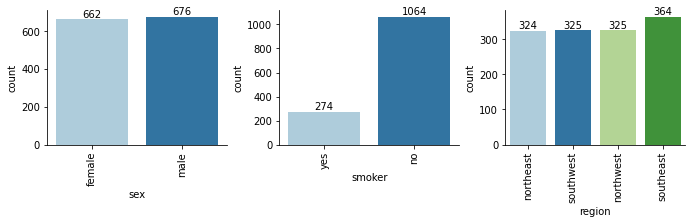

In [6]:
# visualize cat features
fig = plt.figure(constrained_layout=True, figsize = (12,3))

for i, v  in enumerate(cat_cols_ins):
    fig.add_subplot(int(np.ceil(len(num_cols_ins)/4)), 4, i+1)
    ax = sns.countplot(x = v, data = ins_df, palette = 'Paired', order = ins_df[v].value_counts().sort_values().index)
    ax.bar_label(ax.containers[0])
    plt.gca().spines[['top', 'right']].set_visible(False)
    plt.xticks(rotation = 90);

Same conclusion as earlier, balanced customer base in terms of gender and majority are non-smokers. Southeast region have slightly more customers than rest of regions.

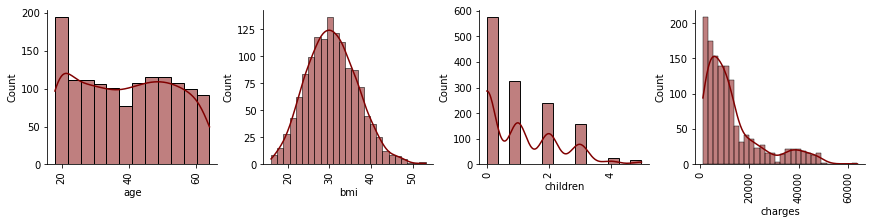

In [7]:
# visualize numeric distribution
fig = plt.figure(constrained_layout=True, figsize = (12,3))

for i, v  in enumerate(num_cols_ins):
    fig.add_subplot(int(np.ceil(len(num_cols_ins)/4)), 4, i+1)
    sns.histplot(x = ins_df[v], color = 'maroon', kde = True)
    plt.gca().spines[['top', 'right']].set_visible(False)
    plt.xticks(rotation = 90);

##### Summary:
- Indeed 'children' and 'charges' have positive skew (long tail to the right), indicating that majority of customers have small families (less than two children) and existence of few risky customers having high insurance cost.
- 'Bmi' is normally distributed
- 'Age' is uniformly distributed between 20 and 60, although there seems to be more samples (observations) of customers below the age of 20 and less samples in range of 35 to 40.
- Kernel Density Estimation (KDE) shows the concentration of observations along x-axes, smoothing the histogram (display continuous version of a histogram) specially for discrete values.

##### Notes:

- 'Children' is discrete value (unlike charges and age which are continuous), discrete values are still conceptually valid ranges only when something can be expressed in decimals(.1, .4, .6, etc..) and still be meaningful; However, this is not the case with children as it is meaningless to say someone have 1.5 children which is better be dealt with as categorical data (binning) specially in the case of missing values and when data is skewed; It is also important to check whether there are numeric data that is ordinal (i.e.: rating of books) and deal with it in the same way.

Recall the normality assumption of linear regression, it is important to know that it is not concerned with the distribution of features rather the **residuals** (difference between actual and predicted charges which typically obtained **after** fitting a model). 

##### So why do we even bother looking at histograms of individual features?

- Although the data don’t have to be normal, it’s still a good idea to check data distributions in order to:
    - Understand the data, we go a basic idea about the nature of customers in our dataset and spread of values across features; we also able to identify skewed distributions which need to be further checked for outliers 
    - Assess impact of skewed data, the relationship between two features may be non-linear (which will be detect with scatterplot as we will see later). In that case transforming one or both features may be necessary.

##### Does this mean that we can run linear regression analysis on non-normal data?

Yes! None of features have to be normal in linear regression analysis which includes t-test and ANOVA. In fact, linear regression analysis works well, even with non-normal residuals; **But**, the problem of non-normal residuals will affect p-values for hypothesis testing.

P-value?

Regression is a hypothesis testing where we assume no relationship between features and target (Null hypothesis), it outputs an estimate of effect size (coefficients) and their statistical significance (p-value), if residuals are not normally distributed (one of main assumptions of linear regression) then we cannot really trust the p-vale to draw a valid conclusion about the hypothesis tested.


##### you just said 'it works well, even with non-normal residuals'  then said 'we cannot really trust the p-vale to draw a valid conclusion if residuals are non-normal', what is going on?!

- The condition of normality of residuals only needs to hold approximately. This means that in case of non-normal residuals the amount of error in the model is not consistent across the full range of target (observed data/dependent variable), this means that prediction errors depends on the feature value and will vary across its full range values. Thus, coefficients technically mean different things at different levels of feature values; The least square regression coefficient will not be t-distributed, so the associated p values will be unreliable.

In-short, the model works but is less efficient. So this will affect model interpretability and overall quality of predictions.

Side note: t-distribution is similar to Normal distribution, but accounts for sample STD rather than population STD.

##### Ok, what to do in case of non-normal residuals?

Scatter plot the residuals against predictions (fitted values) or feature values **using the same scale** and understand why residual histogram appeared to be not normal, residuals are the unexplained variance by our model it is the actual value of target - regression effect; so it will be easier to observe residual behavior when regression effect is removed. Things to look for in the scatter plot:

1. Outliers - Few residuals that are much larger in magnitude than others.
2. Curved residuals
3. Progressive change in variability of residuals as the fitted value increase
4. Skew (or other non-normal distribution) of the residual

After understanding the reason of non-normality in residuals we can: 

- In case of (1) remove the samples causing large residuals and fit model on remainder of data, 
- For (2, 3 or 4) change scale of target (e.g., log transformation).
- If (2) only change scale of feature (e.g., log transformation) or add a polynomial (e.g. feature^2)

##### Conclusion:

- Examine histograms of features to understand data and apply transformation if needed to make relationship with target linear (e.g. log transformation) for regression and other parametric tests.
- We can run linear regression on non-normal data, but residuals need to be approximately normal for interpretability and significance of results
- Fixing non normal residuals, if applicable, can be done through transformation or using polynomial features.
- There are few consequences associated with a violation of the normality assumption, as it does not contribute to bias or inefficiency in regression models. It is only important for the calculation of p-values for significance testing, but this is only a consideration when the sample size is very small. When the sample size is sufficiently large (>200), the normality assumption is not needed at all as the Central Limit Theorem ensures that the distribution of residuals will approximate normality. 
- Understanding WHY DATA IS NOT NORMAL is important, maybe there are outliers causing this behavior.
- Outliers could be due errors or valid points; dealing with them depends on the context of the analysis and underlying data. In general, they have an impact on calculated statistics.
- Transforming scale of variables (feature, target or both) may result in improved linear model, the strength of transformations tends to go from 1. Logarithmic, 2. Square Root, 3. Inverse (1/x).

##### We can conclude that skew is problematic both feature and residual wise, but how much is too much?

In [8]:
# Assessing severity of non-normality - feature wise

for feat in num_cols_ins:
    print(f'{feat}_skew: ', ins_df[feat].skew().round(2), ' '*4, f'{feat}_Kurtosis: ', ins_df[feat].kurt().round(2), sep = '')

age_skew: 0.06    age_Kurtosis: -1.25
bmi_skew: 0.28    bmi_Kurtosis: -0.05
children_skew: 0.94    children_Kurtosis: 0.2
charges_skew: 1.52    charges_Kurtosis: 1.61


##### Summary:

- Only charges appears to be highly skewed, as we've concluded from the histograms earlier

##### Notes:

   - Skew:
        - Is when data is not normally distributed (do not follow a bell shaped curve), it can be either positive (tail to the right) or negative (tail to the left) skew.
        - Positive skew means most observations have lower values and only few have higher ones, contrary to negative skew.
        - Skew score is a metric for how much the data is skewed, ideally a given feature should have a skew score between 1 or -1 either representing positive (score > 0) or negative (score < 0) skew to be considered among predictive features.
        - Skew score of 0 means the data(feature) is normally distributed.
        - Models can handle a slightly skewed data (i.e.: between 1 and -1), however, highly skewed data > 1 or -1 can affect predictions to some extent.

   - Kurtosis:
        - Is measure of how high or low the peak of the data is, high peaks indicates that data is less spread contrary to low peaks.
        - Kurtosis score is a metric for measuring kurtosis, ideally the score should be between 1 or -1 each representing high peaks (kurt > 0) and low peaks (kurt < 0).
        - Kurt score of 0 means the data (feature) is normally distributed.
        - Kurtosis does not have the same effect on predictive ML models as skew.

   - Handling skew is more important than kurtosis.

##### Conclusion:

   - Transform 'charges' scale
   - Consider nonparametric tests if using untransformed 'charges'.
   
##### Now we have slightly better understanding of data and nature of underlying problem, it's time for bivariate analysis.

In [ ]:
stats.kurtosis()

**<a href="#toc" style='color:#00ffff'>Table of contents</a>**

<a id='corr'></a>

### Bivariate analysis - Numeric vs Numeric variables

#### Pearson Correlation (r)

- In order for Pearson correlation to be valid, three assumptions must be met. The degree to which these assumptions hold true determines the degree to which we can trust the calculated r:
    - Continuous data: interval or ratio level data, example: for age variable the difference between age 28 and 29 is the same as the difference between 68 and 69; unlike in ranked data the difference between rank 1 and 2 is may not be the same as the difference between 2 and 3. If data is not continuous it will often result in violation of the other two assumptions.
    - Linear relationship: line can be fitted through the data.
    - Homoscedastic relationship: refers to the consistency of the relationship across all values of x and y, Pearson correlation is a single measure that represents the entire relationship. If that relationship is not consistent (i.e.: fans out towards the end or the observations along the fitted line are spread at some regions and not at others) then a single measure doesn't apply to all values. This means that in regions where observations are not spread we’ll make predictions with fewer errors unlike spread regions and we have to be aware of that.
    - Absence of outliers
- When assessing Pearson correlation coefficient the rule of thumb, following Cohen's standard, is:
    - Small effect size .10 < r <.29
    - Medium effect size .30 < r <.49
    - Large effect size .50 < r 
- Less correlated variables still can be statistically significant

##### Notes:

- If data is not continuous this doesn’t mean we can’t calculated r, but we need to be careful with the related interpretation.
- The reason we measure skew and kurtosis and generate histograms during Univariate analysis is to assess how much our data violates the above assumptions which is usually the result of the two numeric variables not having normal distributions. Thus, it is important to assess Univariate normality before calculating r.
- If the above assumptions are not met, we can:
    - Use other measure of correlation, non-parametric (distribution-free). (i.e.: Kendall's or Spearman's correlation)
    - Transform data (i.e.: log transformation).
    
##### we know that charges (dependent variable) does not have normal distribution and that skew score exceed rule of thumb, can we still rely on Pearson r? Will transformation affect correlation coefficient? Is nonparametric correlation measure wildly different? let’s find out.

In [9]:
# Calculate Pearson (linear) and Spearman (monotonic)

def corr(df, y, num_cols, figsize = (12,3)):
    """ 
    Calculate Pearson (linear) and Spearman (monotonic) Correlation using scipy for non-null numeric values,
    results are sorted following pearson coefficient
    """
    assert type(num_cols) == list, 'please pass columns as a list'
    
    corr = []

    for col in num_cols:
        if df[col].isnull().sum() == 0: # execlude columns with null values
            r_pea, p_pea = stats.pearsonr(df[y], df[col])
            r_spr, p_spr = stats.spearmanr(df[y], df[col])
            corr.append((col, r_pea, p_pea, r_spr, p_spr))

    corr_df = pd.DataFrame([c[1:] for c in corr], columns = ['r_pear', 'p_val(r_pear)', 'r_spr', 'p_val(r_spr)'], 
                           index = np.array(corr)[:,:1].ravel())
    # visualize
    plt.figure(figsize = figsize)
    plt.title(f'Correlation Heatmap - {y}')
    sns.heatmap(corr_df[['r_pear', 'r_spr']].sort_values('r_pear', ascending = False).T, square=True, annot=True, 
                fmt='.2f', linecolor='white', cbar=False);

    return corr_df.sort_values('r_pear', ascending = False).round(3).T

age    bmi  children
r_pear         0.299  0.198     0.068
p_val(r_pear)  0.000  0.000     0.013
r_spr          0.534  0.119     0.133
p_val(r_spr)   0.000  0.000     0.000

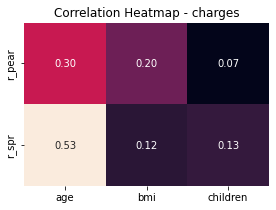

In [10]:
# correlation - skewed target
corr(ins_df, 'charges', list(num_cols_ins.drop('charges')), figsize = (12,3))

##### Summary:
- P-values are significant so we can conclude that there is a relationship between these features and target variable.
- The relationship is positive so we'd expect that increase in one feature corresponds to increase in insurance charges.

##### Notes:
- Correlation does not imply causation, being old doesn't cause sickness! [Stanisław Kowalski](https://en.wikipedia.org/wiki/Stanis%C5%82aw_Kowalski)

##### Conclusion:
- Both metrics points to the same direction (positive correlation), but which coefficient to trust in terms of magnitude? does age have a medium effect size according to Pearson or large effect size according to spearman?

##### Given current skewed status of charges, I'd be inclined to follow spearman coefficient.

age  children    bmi
r_pear         0.528     0.161  0.133
p_val(r_pear)  0.000     0.000  0.000
r_spr          0.534     0.133  0.119
p_val(r_spr)   0.000     0.000  0.000

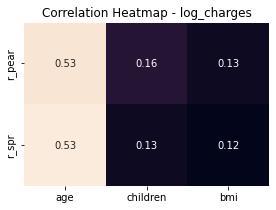

In [11]:
# correlation - transformed target

ins_df['log_charges'] = np.log1p(ins_df.charges)

corr(ins_df, 'log_charges', list(num_cols_ins.drop('charges')), figsize = (12,3))

##### Summary:

Magic! Coefficients now are almost equal, suggesting same effect size according to both measurements. Log transformation tends to 'linearize' the variable thus affect correlation calculation.

Let's inspect the distribution of transformed charges.

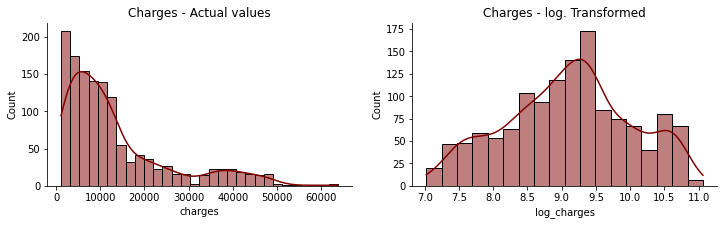

In [12]:
# Transformed charges distribution
fig, axes = plt.subplots(ncols =2, nrows = 1, figsize = (12 , 3))
ax1, ax2 = axes

sns.histplot(x = ins_df.charges, color = 'maroon', kde = True, ax = ax1)
ax1.spines[['top', 'right']].set_visible(False)
ax1.set_title('Charges - Actual values');

sns.histplot(x = ins_df.log_charges, color = 'maroon', kde = True, ax = ax2)
ax2.spines[['top', 'right']].set_visible(False)
ax2.set_title('Charges - log. Transformed');

##### Summary:
- Charges now is approximately normal, although we still have a small peak in the right tail (around 10.5)
- Transforming charges may improve predictions

##### Notes:
- We would typically opt for transforming dependent variable as discussed earlier, the reason I'll keep analyzing charges using untransformed values is that transformation gets in the way of interpretability and we are still exploring the data not in modeling phase.
- Calculating both parametric and nonparametric statistic should not lead to p-hacking, we calculate both to supplement our analysis and we should decide which to choose upfront depending on nature of underlying data not on test results to avoid biased, and eventually, wrong conclusions.

**<a href="#toc" style='color:#00ffff'>Table of contents</a>**

<a id='tl'></a>

#### Trend Lines

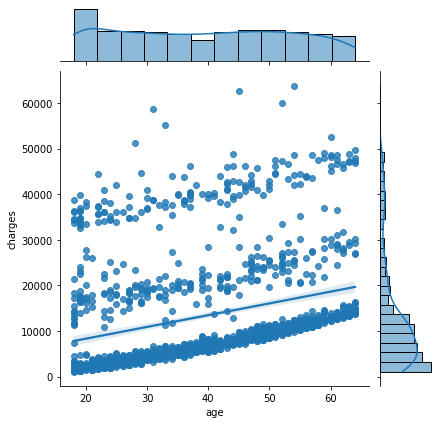

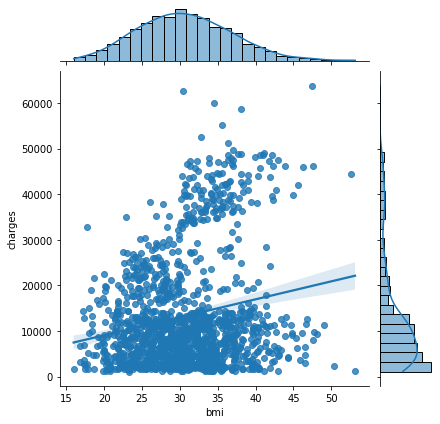

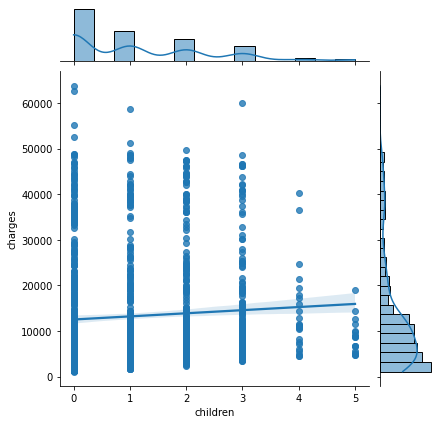

In [13]:
# visualize trend lines

for i, v  in enumerate(num_cols_ins.drop('charges')):
    sns.jointplot(x = ins_df[v], y = ins_df.charges, kind = 'reg')
    plt.gca().spines[['top', 'right']].set_visible(False)
    plt.show()

##### Summary
- Joint plots combine both scatter and histogram of the two numeric features.
- The line represents linear regression estimate of best fit, distances between the line and each value (dots) are the residuals.
- We can observe upward trend in all features plotted, this means that charges is positively affected by each of underlying feature; same was noted from correlation earlier.
- We'd be interested in observing the spread of data points around the fitted line, we are looking for equal spread around the line as this means that our predictions will be consistent across all feature values.
- We can observe that spread around the line is not consistent for 'bmi' and 'children' features, for example 'bmi' in the range of 20-30 have nearly equal spread then it fans out towards higher values; this can also be captured by the shaded area around the line which represents uncertainty about location of fitted line, the wider the interval the less certain regression estimates.
- Spread of observations is fairly consistent around the line for 'age' feature
- To be investigated:
    1. Three distinct horizontal groups in 'age' plot
    2. What is pulling the line in 'age' plot towards the bottom?
    3. Unique group of 'bmi' between 30 - 40 that have high charge values 
    4. Customers of 'bmi' >= 50 that have significantly different charge values
    
##### Notes
- Age and Children are discrete (no decimals) data so that’s why their scatter plot appears like vertical straight lines.
- Discrete data are tough to visualize so it’s better to have trend line to note the trend in data.

##### Conclusion

Using scatter plots with trend lines we aim to explore what sort of relationship exists between features and target, which could be one of the following:
   - Both feature (x) and target (y) lies nearly on a straight line
   - Both feature and target lies nearly on a smooth curve, not a straight line
   - Target are scattered without relationship to feature values
   - Something intermediate between 1,2 and 3
   - Most feature and target lies close to line or smooth curve, but few are scattered along the way.

In our example, we can say that condition 4 is applicable as target values are not randomly scattered but are not nearly a straight line either. Also, we have some data points that are far away from the line but not much from adjacent data points. 

##### So what’s next?

Case 5 is an indication of outliers that need to be dealt with by either separation or correcting values if erroneous, as for 2 we can apply transformation either values or both (feature and target) and for 3 we can consider a non-linear model or adding polynomial features.

In [14]:
# Investigating 1 and 2
display(ins_df[ins_df.charges < 10000].drop(['charges', 'log_charges'], axis = 1).describe(include = 'all').T, 
        ins_df[(ins_df.charges > 10000) 
               & (ins_df.charges < 30000)].drop(['charges', 'log_charges'], axis = 1).describe(include = 'all').T,
        ins_df[ins_df.charges > 30000].drop(['charges', 'log_charges'], axis = 1).describe(include = 'all').T)

count unique        top freq       mean       std    min     25%  \
age       712.0    NaN        NaN  NaN  33.091292  10.51615   18.0   23.75   
sex         712      2       male  357        NaN       NaN    NaN     NaN   
bmi       712.0    NaN        NaN  NaN  30.260351  6.183319  15.96  25.885   
children  712.0    NaN        NaN  NaN   1.075843  1.175168    0.0     0.0   
smoker      712      1         no  712        NaN       NaN    NaN     NaN   
region      712      4  southeast  193        NaN       NaN    NaN     NaN   

              50%       75%    max  
age          33.0      42.0   54.0  
sex           NaN       NaN    NaN  
bmi       29.9225  34.12875  53.13  
children      1.0       2.0    5.0  
smoker        NaN       NaN    NaN  
region        NaN       NaN    NaN

count unique        top freq       mean       std     min    25%  \
age       464.0    NaN        NaN  NaN   48.18319   13.7344    18.0  39.75   
sex         464      2     female  248        NaN       NaN     NaN    NaN   
bmi       464.0    NaN        NaN  NaN  29.821756  5.813147  17.195  25.46   
children  464.0    NaN        NaN  NaN   1.099138  1.273962     0.0    0.0   
smoker      464      2         no  342        NaN       NaN     NaN    NaN   
region      464      4  northeast  128        NaN       NaN     NaN    NaN   

            50%     75%    max  
age        53.0    58.0   64.0  
sex         NaN     NaN    NaN  
bmi       28.88  33.535  49.06  
children    1.0     2.0    5.0  
smoker      NaN     NaN    NaN  
region      NaN     NaN    NaN

count unique        top freq       mean        std     min      25%  \
age       162.0    NaN        NaN  NaN  40.376543  14.472512    18.0     27.0   
sex         162      2       male  103        NaN        NaN     NaN      NaN   
bmi       162.0    NaN        NaN  NaN  34.845432   4.736925  17.765  31.6925   
children  162.0    NaN        NaN  NaN   1.166667   1.137994     0.0      0.0   
smoker      162      2        yes  152        NaN        NaN     NaN      NaN   
region      162      4  southeast   61        NaN        NaN     NaN      NaN   

            50%      75%    max  
age        42.0    52.75   64.0  
sex         NaN      NaN    NaN  
bmi       34.65  37.0275  52.58  
children    1.0      2.0    4.0  
smoker      NaN      NaN    NaN  
region      NaN      NaN    NaN

##### Summary:
- Smoker feature seems to be causing such variation in charges, rest of features appears to be balanced among the three distinct groups; they can be summarized as follows:
    - group one, charges < 10k, represents 53% (712/1338) of customers and **all** are non-smokers.
    - group two, charges > 10k but < 30k, represents 35% of customers among which 27% (122/464) are smokers.
    - group three, charges > 30k, represents 12% of customers among which 94% are smokers.
- Since concentration of customers tends to be at lower end of charges this is what causing the line to be pulled down towards the bottom of plot.

In [15]:
# Investigating 3 and 4
display('Unique groups of \'bmi\' between 30 - 40 that have high charge values', 
        ins_df[(ins_df.bmi > 30) & (ins_df.bmi <= 40) 
               & (ins_df.charges < 30000)].drop(['bmi', 'charges', 'log_charges'], axis = 1).describe(include = 'all').T, 
        ins_df[(ins_df.bmi > 30) & (ins_df.bmi <= 40) & (ins_df.charges > 30000) 
               & (ins_df.charges < 50000)].drop(['bmi', 'charges', 'log_charges'], axis = 1).describe(include = 'all').T,
        'Customers of \'bmi\' >= 50 that have significantly different charge values',
        ins_df[(ins_df.bmi > 50)].T)

"Unique groups of 'bmi' between 30 - 40 that have high charge values"

count unique        top freq      mean        std   min   25%   50%  \
age       486.0    NaN        NaN  NaN      40.5  14.493902  18.0  27.0  42.0   
sex         486      2     female  245       NaN        NaN   NaN   NaN   NaN   
children  486.0    NaN        NaN  NaN  1.102881   1.193501   0.0   0.0   1.0   
smoker      486      1         no  486       NaN        NaN   NaN   NaN   NaN   
region      486      4  southeast  145       NaN        NaN   NaN   NaN   NaN   

           75%   max  
age       53.0  64.0  
sex        NaN   NaN  
children   2.0   5.0  
smoker     NaN   NaN  
region     NaN   NaN

count unique        top freq       mean        std   min    25%  \
age       122.0    NaN        NaN  NaN  39.590164  14.757407  18.0  26.25   
sex         122      2       male   75        NaN        NaN   NaN    NaN   
children  122.0    NaN        NaN  NaN   1.139344    1.14499   0.0    0.0   
smoker      122      2        yes  117        NaN        NaN   NaN    NaN   
region      122      4  southeast   42        NaN        NaN   NaN    NaN   

           50%    75%   max  
age       38.5  51.75  64.0  
sex        NaN    NaN   NaN  
children   1.0    2.0   4.0  
smoker     NaN    NaN   NaN  
region     NaN    NaN   NaN

"Customers of 'bmi' >= 50 that have significantly different charge values"

847         1047       1317
age                 23          22         18
sex               male        male       male
bmi              50.38       52.58      53.13
children             1           1          0
smoker              no         yes         no
region       southeast   southeast  southeast
charges      2438.0552  44501.3982  1163.4627
log_charges   7.799366   10.703298   7.060015

##### Summary:
- Smoker is the main difference between the two distinct groups in 'bmi' range having significantly different charge values, same for the 3 customers; however, there must be additional factors not included in the dataset contributing to the variation in charge specially between the first two customers (maybe their medical condition)
    
##### Conclusion:
- Smoker categorical feature appears to have an impact on medical charges, but of what magnitude?

##### it would be nice to display regression coefficient in previous plots to get a sense of contribution of each feature

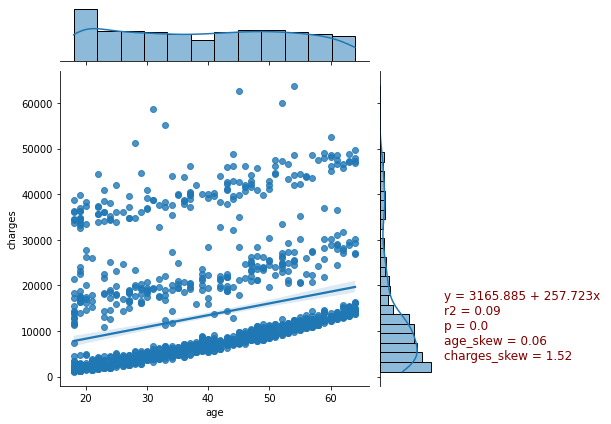

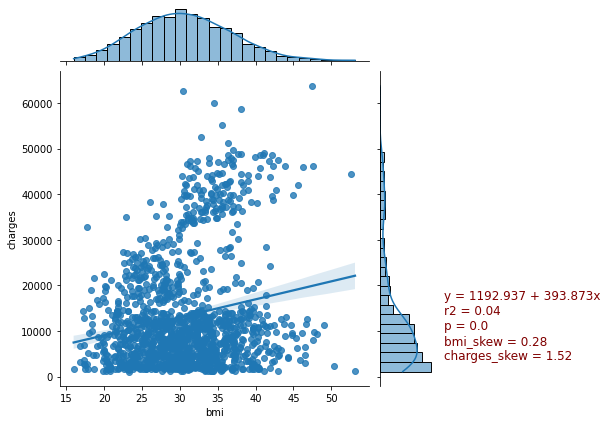

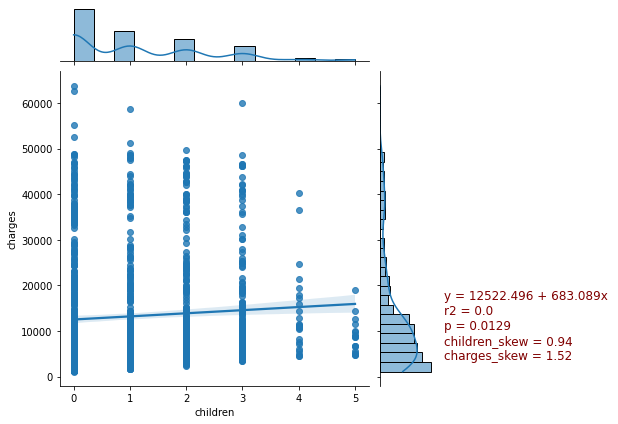

In [16]:
# visualize trend lines - adding regression estimates

for col in num_cols_ins.drop('charges'):
    
    model = sm.OLS(ins_df.charges, ins_df[[col]].assign(const=1)).fit()
    
    text = f'y = {model.params[1].round(3)} + {model.params[0].round(3)}x \n' + f'r2 = {model.rsquared.round(2)} \n' + \
                f'p = {model.pvalues[0].round(4)} \n' + f'{col}_skew = {ins_df[col].skew().round(2)} \n' + \
                f'charges_skew = {ins_df.charges.skew().round(2)} \n'
    
    ax = sns.jointplot(x = ins_df[col], y = ins_df.charges, kind = 'reg')
    ax.fig.text(1, 0.116, text, verticalalignment='bottom', horizontalalignment='left', 
                        transform = plt.gcf().transFigure, color='maroon', fontsize = 12)
    
    plt.gca().spines[['top', 'right']].set_visible(False)
    plt.show()

In [17]:
# calculating r for 'age' feature
# sqrt(r2)
np.sqrt(0.09)

0.3

##### Summary:
   - $r^2$ is the percentage of explained variance in charges by the fitted model, low $r^2$ means that individual features do not contribute much to the model. 
   
   - $r^2$ (Coefficient of Determination) is the square of Pearson Coefficient of Correlation. 
   
   - Correlation and Regression are different, they both measure relationship between variables but from different perspective; having High correlation coefficient does not necessarily translate to a good regression fit.
   
   - p-value indicates significance of each feature to the model, however, this is not readily noticeable from $r^2$. Can we trust the estimates of this model as is?

##### Notes:
- We are glancing at $r^2$ to gain an initial *flavor* of how good/bad a feature is, there are other robust metrics to test model performance; however, we are exploring not modeling yet and $r^2$ gives some idea of the quality of the fit.

- We know that log transformation improved Pearson coefficient of Correlation, will this also apply to the model?

##### let's test assumptions of linear regression so we can conclude if the results we are seeing valid or not, we are going to test:
   1. Residuals normality assumption
   2. Residuals equal variance assumption

**<a href="#toc" style='color:#00ffff'>Table of contents</a>**

<a id='rhomo'></a>

#### Residuals Homoscedasticity assumption

In [18]:
# Residuals equal variance assumption (homoscedasticity) - statistical method

# collect model results
resd_df = ins_df.copy()
model_params = []

for col in num_cols_ins.drop('charges'):
    # calculate reg line
    # Q("{col}")' controls column names having numbers and spaces
    model = ols(formula = f'charges~Q("{col}")', data = ins_df).fit()
    # #similar to above but output index change so consider this in print statement
    #model = sm.OLS(ins_df.charges, ins_df[[col]].assign(const=1)).fit()
    resd_df[f'{col}_pred'] = model.fittedvalues
    resd_df[f'{col}_resid'] = model.resid
    resd_df[f'{col}_abs_resid'] = np.abs(model.resid)
    model_params.append((model.params[0], model.params[1]))

    # model.resid -- >error (prediction-actual)
    # model.model.exog -- > feature values (i.e.: age) printed with intercept
    white_test = het_white(model.resid, model.model.exog)
    bpgn_test = het_breuschpagan(model.resid, model.model.exog)

    # adding stats to plot
    print(f'{col} \n', '*'*30, '\n', f'y = {model.params[0].round()} + {model.params[1].round()}x \n',  
          f'r2 = {model.rsquared.round(2)} \n', f'p = {model.pvalues[1].round(4)} \n', 
          f'{col}_skew = {ins_df[col].skew().round(2)} \n', f'charges_skew = {ins_df.charges.skew().round(2)} \n', 
          f'p-value(W_LM) {white_test[1].round(4)} \n', f'p-value(W_F) {white_test[3].round(4)} \n', 
          f'p-value(B_LM) {bpgn_test[1].round(4)} \n', f'p-value(B_F) {bpgn_test[3].round(4)} \n', '*'*30, '\n', sep = '')

age 
******************************
y = 3166.0 + 258.0x 
r2 = 0.09 
p = 0.0 
age_skew = 0.06 
charges_skew = 1.52 
p-value(W_LM) 0.9986 
p-value(W_F) 0.9986 
p-value(B_LM) 0.9838 
p-value(B_F) 0.9838 
******************************

bmi 
******************************
y = 1193.0 + 394.0x 
r2 = 0.04 
p = 0.0 
bmi_skew = 0.28 
charges_skew = 1.52 
p-value(W_LM) 0.0 
p-value(W_F) 0.0 
p-value(B_LM) 0.0 
p-value(B_F) 0.0 
******************************

children 
******************************
y = 12522.0 + 683.0x 
r2 = 0.0 
p = 0.0129 
children_skew = 0.94 
charges_skew = 1.52 
p-value(W_LM) 0.2971 
p-value(W_F) 0.2976 
p-value(B_LM) 0.8156 
p-value(B_F) 0.8158 
******************************



##### Summary:

- *Homo* means equal, *scedasticity* means spread. So it’s (equal spread) of residuals around the fitted line

- Homoscedasticity of residuals is one of the assumptions of linear regression, when it is violated we say that we have a heteroscedasticity (unequal spread) issue

- Importance of spread is to indicate the consistency/inconsistency of predictions given any feature value (x), if spread is not consistent then our predictions will be off at values away from the line (i.e.: we obtain different error magnitude depending on value of x)

- We tested for heteroscedasticity using two methods (White test and Breusch–Pagan test) the null hypothesis is that the variance of is equal, if p-values are significant (<0.05) then we reject null and conclude that residual variance is not equal and the assumption of equal variance is not met

- If both tests results supports each other either being significant or not we conclude that we either do not have or do have a heteroscedasticity problem.

- If one test is significant and other is not then we can conclude that there is generally no significant heteroscedasticity problem.

- If 3 out of 4 stats (p-values) are significant (<0.05) then we conclude that there is a heteroscedasticity problem and vice versa.

- We do not have heteroscedasticity problem for age and children features contrary to bmi, what does this mean? We need to: 
    - Consider this in our interpretation of regression estimates, 
    - Attempt to fix it (as discussed earlier) 
    - Try different model.

##### Notes:

- Breusch-Pagan assumes heteroscedasticity is linear, which makes it inapplicable in some cases (as is the case with U-shaped residual distribution), while White does not make assumptions about the shape of the heteroscedasticity.

- Breusch-Pagan tests for the presence of heteroscedasticity, while White tests for bias due to heteroscedasticity

##### Since we have heteroscedasticity issue, we need to further understand the reason behind it; visual inspection of residuals vs fitted(predicted)/actual values can be helpful.

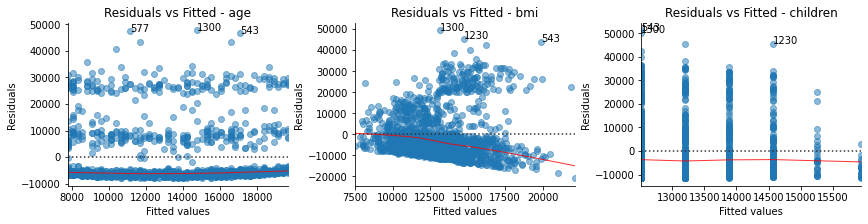

In [19]:
# Residuals equal variance assumption (homoscedasticity) - visual method

cols_plot = num_cols_ins.drop('charges')

fig = plt.figure(constrained_layout=True, figsize = (15,3))

for i, v in enumerate(cols_plot):
    fig.add_subplot(int(np.ceil(len(cols_plot)/4)), 4, i+1)
    ax = sns.residplot(x = resd_df[f'{v}_pred'], y =  resd_df.charges, lowess = True, scatter_kws={'alpha': 0.5}, 
                              line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8})
    ax.set_title(f'Residuals vs Fitted - {v}')
    ax.set_xlabel('Fitted values')
    ax.set_ylabel('Residuals')
    plt.gca().spines[['top', 'right']].set_visible(False)

    # annotations
    abs_resid = resd_df[f'{v}_abs_resid'].sort_values(ascending=False)
    abs_resid_top_3 = abs_resid.iloc[:3]
    for i in abs_resid_top_3.index:
        ax.annotate(i, xy=(resd_df[f'{v}_pred'][i], resd_df[f'{v}_resid'][i]));

##### Summary

-  Residplot fits and removes a simple linear regression, then plots the residual values for each observation. Ideally, these values should be randomly scattered around y = 0. If there is structure in the residuals, it suggests that simple linear regression is not appropriate

- Lowess curve is [lowess smoother](https://en.wikipedia.org/wiki/Local_regression) that fits [nonparametric regression](https://en.wikipedia.org/wiki/Nonparametric_regression). The red curve passes through the deterministic part of the variation in the data captured by current feature. So, for 'age' and 'bmi' features it simply means that those features alone are good at capturing trend in 'non-smoker' group (because this is where the curve passes and are randomly scattered around the line); how did we know this? If you remember the groups we explored earlier, the area where the curve passes are all non-smokers! If you look closely at 'bmi' residual plot you will notice that residuals fan outs and the curve follows the non-smoker group.

- Spread of residuals in 'age' and 'children' is fairly consistent around y = 0, although 'age' seems to have more even spread than 'children' unlike 'bmi' which have non-constant variance that fans out; this is reflected in magnitude of p-values of homoscedasticity tests

- Outliers worth further inspection and testing to determine their influence on regresison, removing them can improve model

- Unequal variance, so what? Regression estimates are unbiased but inefficient, p-value and confidence interval is unreliable. So, overall inefficient model.

##### Notes
- Even though 'bmi' actual values are normally distributed it failed equal variance test, having data that is normally distributed does not always guarantee to pass linear regression assumptions.

- One of the purposes of Lowess is to provide a general idea prior to committing to a specific parametric model, there is no requirement to specify a global function to fit to the data. Instead, locally weighted regression is performed on a pre-defined number of nearest neighbors around each data point, then the composite of each locally weighted regression is plotted along with a scatterplot of the original (x,y) data. 

##### Conclusion
- 'bmi' violates equal variance assumption contrary to 'age' and 'children' features.

**<a href="#toc" style='color:#00ffff'>Table of contents</a>**

<a id='rnorm'></a>

#### Residuals Normality assumption

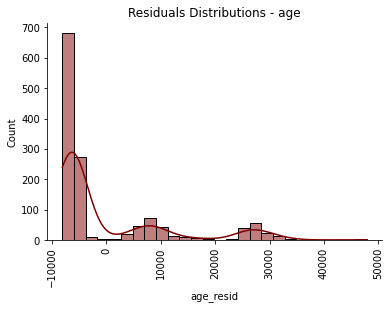

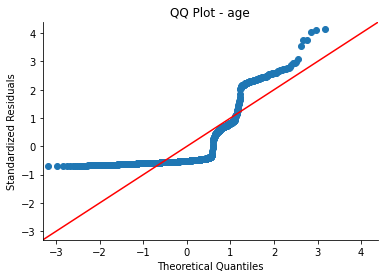

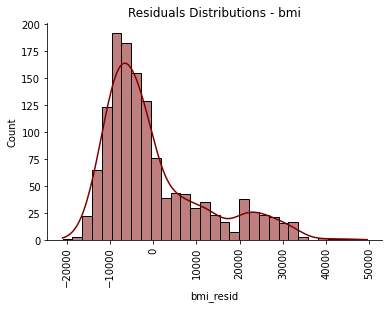

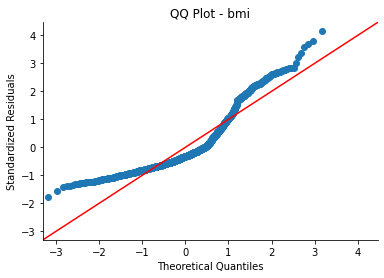

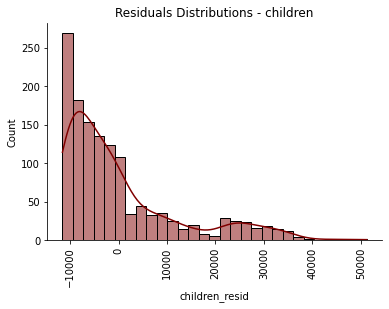

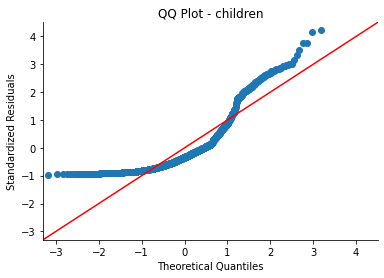

In [20]:
# Residuals Normal distribution assumption - visual method

for col in cols_plot:
    # histograms
    sns.histplot(x = resd_df[f'{col}_resid'], color = 'maroon', kde = True)
    plt.title(f'Residuals Distributions - {col}')
    plt.gca().spines[['top', 'right']].set_visible(False)
    plt.xticks(rotation = 90);
    
    # QQ plot
    sm.qqplot(resd_df[f'{col}_resid'], fit=True, line='45')
    plt.title(f'QQ Plot - {col}')
    plt.xlabel("Theoretical Quantiles")
    plt.ylabel("Standardized Residuals")
    plt.gca().spines[['top', 'right']].set_visible(False)
    plt.show()

##### Summary:

- Quantile-Quantile (QQ) plots helps determine if data follows a selected distribution, here we are testing for normality; the closer the standardized residuals to the 45 degree line the closer the data is to being *approximately* normally distributed.

- Skewed data can also be spotted from QQ plots, notice how bottom tail deviates from 45 degree line in 'age' and 'children' features

- Residuals used in QQ plots are standardized so it is easier to spot outliers (points drifting away from line)

- Despite that 'bmi' violates residual equal variance assumption, residuals are **approximately** normally distributed. We are actually not looking for perfect normality rather **approximate** normality.

What does this means?

Simply put, building a model based on data that violates the model assumption is not efficient; the model will work but will be less reliable. What we are trying to do so far is to assess compliance of data to model assumptions in order to select best approach to model the data.

##### Conclusion

- Unless there is a very strong relationship between the features (independent variable, X) and target (dependent variable, y) the distribution of the residuals is very close to that of the dependent variable, Y. This is evidenced in 'age' and 'children' residuals distributions; they tend to follow the distribution of actual charges values! That is why the commonly stated assumption for regression is that the target needs to be normally distributed.

- 'age' and 'children' violates residual normality assumption but not equal variance assumption, contrary to 'bmi'. None of regression estimates calculated so far can be reliable.

- Status of residual assumptions so far is:

    - 'bmi' pass normality but violates equal variance
    - 'age' and 'children' pass equal variance but violate normality

##### It's time to pause and experiment with different methods for fixing assumption violations before diving into categorical and multivariate feature analysis.

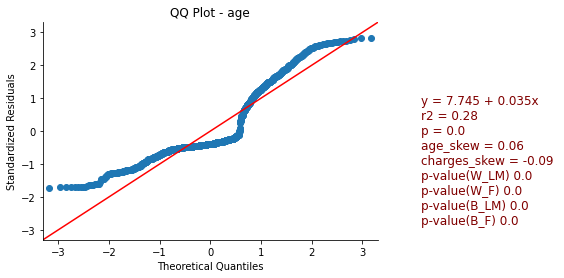

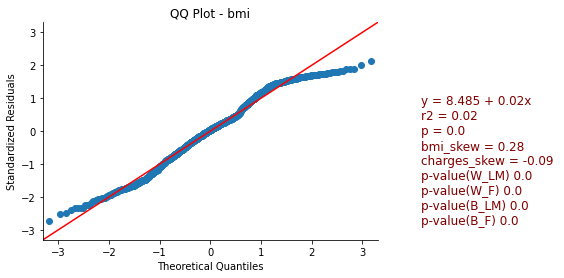

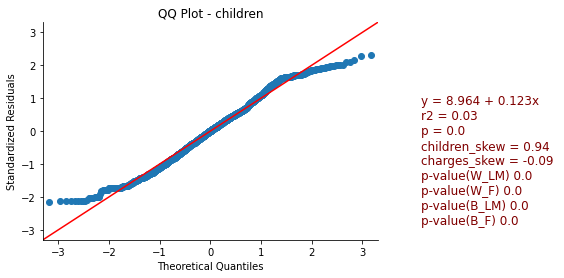

In [21]:
# Residuals Normal distribution assumption - visual method, log transforming target(dependent) variable

for i, col in enumerate(num_cols_ins.drop('charges')):
    
    # fit model
    model = sm.OLS(ins_df.log_charges, ins_df[[col]].assign(const=1)).fit()
    
    # test equal variance assumption
    white_test = het_white(model.resid, model.model.exog)
    bpgn_test = het_breuschpagan(model.resid, model.model.exog)

    text = f'y = {model.params[1].round(3)} + {model.params[0].round(3)}x \n' + f'r2 = {model.rsquared.round(2)} \n' + \
           f'p = {model.pvalues[0].round(4)} \n' + f'{col}_skew = {ins_df[col].skew().round(2)} \n' + \
           f'charges_skew = {ins_df.log_charges.skew().round(2)} \n' + f'p-value(W_LM) {white_test[1].round(4)} \n' + \
           f'p-value(W_F) {white_test[3].round(4)} \n' + f'p-value(B_LM) {bpgn_test[1].round(4)} \n' + \
           f'p-value(B_F) {bpgn_test[3].round(4)} \n'
    
    # plot distribution
    
    # QQ plot
    ax = sm.qqplot(model.resid, fit=True, line='45')
    ax.text(1, 0.116, text, verticalalignment='bottom', horizontalalignment='left', 
            transform = plt.gcf().transFigure, color='maroon', fontsize = 12)
    plt.title(f'QQ Plot - {col}')
    plt.xlabel("Theoretical Quantiles")
    plt.ylabel("Standardized Residuals")
    plt.gca().spines[['top', 'right']].set_visible(False)
    plt.show()

##### Summary:

- Residuals appear to be normally distributed now, so we can conclude that each model passes normality test.

##### Conclusion:

- Normally distributed residuals does not necessary result in equal variance, heteroscedasticity characterizes a relationship between residual size and predictions whereas normality tells us nothing about how the residuals relate to anything else.

- Log transforming target variable fixed residual non-normality but not heteroscedasticity.

##### Still have other options to try
- Change transformation type
- Add more features
- Remove influential points

**<a href="#toc" style='color:#00ffff'>Table of contents</a>**

<a id='expvi'></a>

#### Experimenting with violation fixes

In [22]:
# helper functions

def hists(df, cols, figsize = (10, 5)):  
    """
    visualize numeric distribution
    """ 
    assert type(cols) == list, 'please pass columns as a list'
    
    fig = plt.figure(constrained_layout=True, figsize = figsize)

    for i, v  in enumerate(cols):
        fig.add_subplot(int(np.ceil(len(col)/4)), 4, i+1)
        sns.histplot(x = df[v], bins = 30, color = 'maroon', kde = True)
        plt.gca().spines[['top', 'right']].set_visible(False)
        plt.xticks(rotation = 90);
        
###############################
        
def reg_res_vis(df, cols, target, res_plot = False, disp_res = False):
    """
    Regress and visualize residuals
    """
    assert type(cols) == list, 'please pass columns as a list'

    # fit model

    # linear formula
    # Q("{col}")' controls column names having numbers and spaces
    feats = '+'.join(['Q("%s")' % c for c in cols])  
    formula = f'{target}~{feats}'
    # auto drop one group (cat feat) and add intercept
    model = ols(formula, data = df).fit()
    
    if disp_res:            
        print(model.summary())
    
    if res_plot:
        # plot residuals vs predictions (fitted values)
        ax = sns.residplot(x = model.fittedvalues, y = df[target], lowess = True, scatter_kws={'alpha': 0.5}, 
                                      line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8})
        ax.set_title(f'Residuals vs Fitted')
        ax.set_xlabel('Fitted values')
        ax.set_ylabel('Residuals')
        plt.gca().spines[['top', 'right']].set_visible(False);

    # test for heteroscedasticity
    try:

        white_test = het_white(model.resid, model.model.exog)
        bpgn_test = het_breuschpagan(model.resid, model.model.exog)
        
        # plot text
        text = f'r2 = {model.rsquared.round(2)} \n' + f'{target}_skew = {df[target].skew().round(2)} \n' + \
               f'p-value(W_LM) {white_test[1].round(4)} \n' + f'p-value(W_F) {white_test[3].round(4)} \n' + \
               f'p-value(B_LM) {bpgn_test[1].round(4)} \n' + f'p-value(B_F) {bpgn_test[3].round(4)} \n'
    except:
        bpgn_test = het_breuschpagan(model.resid, model.model.exog)
        
        # plot text
        text = f'r2 = {model.rsquared.round(2)} \n' + f'{target}_skew = {df[target].skew().round(2)} \n' + \
        f'p-value(B_LM) {bpgn_test[1].round(4)} \n' + f'p-value(B_F) {bpgn_test[3].round(4)} \n'
        
    # plot residuals distribution
    # QQ plot
    ax2 = sm.qqplot(model.resid, fit=True, line='45')
    ax2.text(1, 0.116, text, verticalalignment='bottom', horizontalalignment='left', 
            transform = plt.gcf().transFigure, color='maroon', fontsize = 12)
    plt.title(f'QQ Plot - {target}')
    plt.xlabel("Theoretical Quantiles")
    plt.ylabel("Standardized Residuals")
    plt.gca().spines[['top', 'right']].set_visible(False)
    plt.show()
    
    return model
    
############################### 

def inf_points(df, model, alpha = 0.05):
    """
    Identify influential points based on Cook’s Distance and Studentized Residuals estimates 
    """
    n = len(df)
    
    # Cook’s Distance
    c_d = model.get_influence().summary_frame()['cooks_d']   
    # inf points >= 4 / n
    rthumb_cook = np.abs(c_d) >= 4 / n
    c_d_idx = c_d[rthumb_cook].index
    
    # Studentized Residuals
    e_s_r = model.get_influence().summary_frame()['student_resid']
    # accounting for intercept
    p = model.df_model + 1
    # ppf is inverse cumulative distribution function (ICDF) - percentiles
    # assuming 0 mean and 1 std (defaults)
    # df is degree of freedom
    # returned value represents threshold within 95% confidence interval (1 - 0.05 /2)
    ppf = stats.t.ppf(1 - alpha / 2, df = n - p - 1)
    # inf points are > ppf
    rthumb_stur = np.abs(e_s_r) > ppf
    e_s_r_idx = e_s_r[rthumb_stur].index
    
    # intersection both cook distance and external student residuals
    cook_index = set(c_d_idx)
    ext_index = set(e_s_r_idx)
    index_inter = list(set.intersection(cook_index, ext_index))
    index_inter.sort()

    # union both cook distance and external student residuals
    index_union = list(set.union(cook_index, ext_index))
    index_union.sort()
    
    return c_d_idx, e_s_r_idx, index_inter, index_union

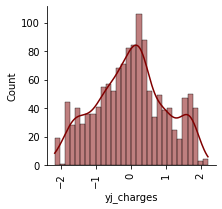

In [147]:
# apply different transformation to targets

scaler = PowerTransformer()

# yeo-johnson
ins_df['yj_charges'] = scaler.fit_transform(ins_df[['charges']])

# visualize
hists(ins_df, ['yj_charges'])

In [24]:
# type of transformation applied
scaler.lambdas_

array([0.04352322])

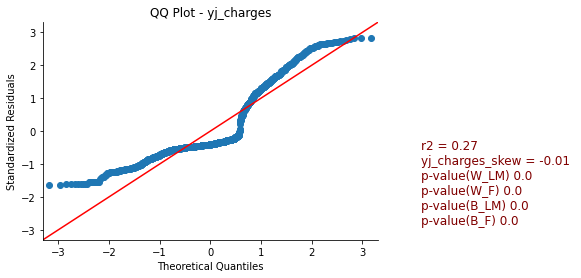

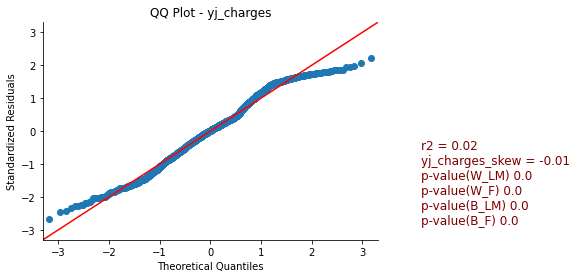

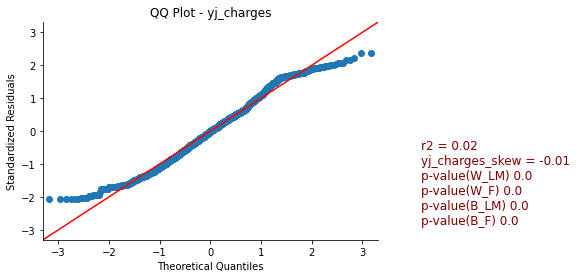

In [148]:
# test residual normality and equal variance after applying transformation
for col in ['age', 'bmi', 'children']:
    reg_res_vis(ins_df, [col], 'yj_charges')

##### Summary:

- The applied transformation is in fact log-transformation, same conclusion as earlier.

##### Notes:

- PowerTransformer makes the data distribution more-Gaussian and optionally standardize the result, centering the values on the mean value of 0 and a standard deviation of 1.0.

- A hyperparameter, often referred to as lambda is used internally to control the nature of the transform depending on data as follows:
    - lambda = -1. is a reciprocal transform.
    - lambda = -0.5 is a reciprocal square root transform.
    - lambda = 0.0 is a log transform.
    - lambda = 0.5 is a square root transform.
    - lambda = 1.0 is no transform.

- Transforming does not always work depending on data, it is most effective when the data distribution is nearly-Gaussian to begin with and is afflicted with a skew or outliers.

- The log transform is a specific example of power transforms, although this may or may not be the best power transform for a given variable.

- Standardizing the raw dataset prior to transformation can sometimes result in better performance.

##### Conclusion:
- Let's model charges as a function of numeric features only and test different approaches to address assumption violations having all features combined, with and without transformation.

                            OLS Regression Results                            
Dep. Variable:                charges   R-squared:                       0.120
Model:                            OLS   Adj. R-squared:                  0.118
Method:                 Least Squares   F-statistic:                     60.69
Date:                Sat, 31 Dec 2022   Prob (F-statistic):           8.80e-37
Time:                        12:00:12   Log-Likelihood:                -14392.
No. Observations:                1338   AIC:                         2.879e+04
Df Residuals:                    1334   BIC:                         2.881e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept     -6916.2433   1757.480     -3.935

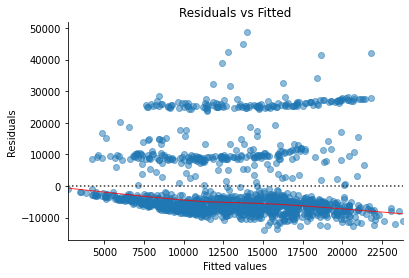

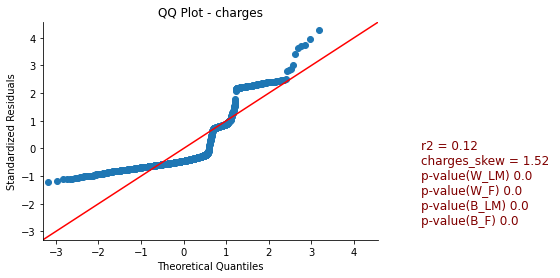

In [26]:
# ols - num feats only - original target

model_org = reg_res_vis(ins_df, ['age', 'bmi', 'children'], 'charges', res_plot = True, disp_res = True)

                            OLS Regression Results                            
Dep. Variable:            log_charges   R-squared:                       0.303
Model:                            OLS   Adj. R-squared:                  0.302
Method:                 Least Squares   F-statistic:                     193.7
Date:                Sat, 31 Dec 2022   Prob (F-statistic):          2.90e-104
Time:                        12:00:18   Log-Likelihood:                -1543.7
No. Observations:                1338   AIC:                             3095.
Df Residuals:                    1334   BIC:                             3116.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         7.3194      0.119     61.655

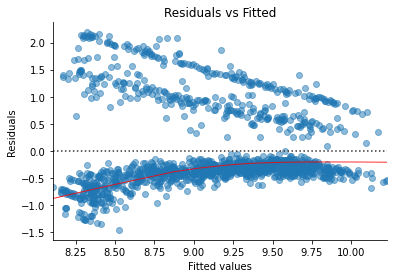

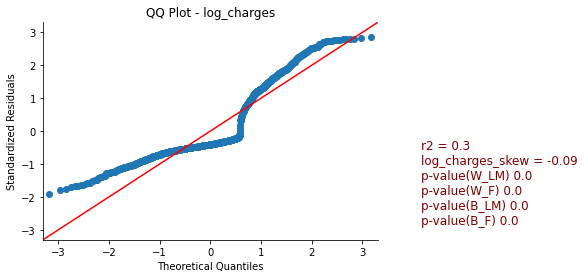

In [27]:
# ols - num feats only - transformed target

model_trns = reg_res_vis(ins_df, ['age', 'bmi', 'children'], 'log_charges', res_plot = True, disp_res = True)

##### Summary:
- Adjusted $r^2$ is almost equal to r-squared in both models (before and after transformation), this means that each feature is contributing to the model.

- Size of F-statistic and low p-vale means that the model (combination of features) are significant to the model.

- Size of t and low p-val indicates that coefs have statistical significance in explaining variation in charges. In our model 'age' seems to have biggest influence.

- Omnibus is relatively high and the Prob(Omnibus) is significant (0), indicating that residuals are not normally distributed, this can be observed also from Skew score exceeding 1 which means that residuals are positively skewed.

- Since the residual plot doesn't change proportionally with the fitted values after transformation, this approach will likely not work well for the stabilization of variance of this model.

##### Conclusion:
- Normality assumption is violated, however, skew is not significant.

- Log transformation evidently improved the model estimates; however, there remains a significant heteroscedasticity problem.

- Split the model based on smoker groups and reassess

In [28]:
# remove smoker group
ins_nosmk_df = ins_df[ins_df.smoker == 'no']
ins_nosmk_df.head()

age     sex     bmi  children smoker     region      charges  log_charges  \
1   18    male  33.770         1     no  southeast   1725.55230     7.453882   
2   28    male  33.000         3     no  southeast   4449.46200     8.400763   
3   33    male  22.705         0     no  northwest  21984.47061     9.998137   
4   32    male  28.880         0     no  northwest   3866.85520     8.260455   
5   31  female  25.740         0     no  southeast   3756.62160     8.231541   

   yj_charges  
1    8.805045  
2   10.142157  
3   12.526567  
4    9.940531  
5    9.899133

                            OLS Regression Results                            
Dep. Variable:            log_charges   R-squared:                       0.676
Model:                            OLS   Adj. R-squared:                  0.675
Method:                 Least Squares   F-statistic:                     735.6
Date:                Sat, 31 Dec 2022   Prob (F-statistic):          1.79e-258
Time:                        12:00:25   Log-Likelihood:                -595.94
No. Observations:                1064   AIC:                             1200.
Df Residuals:                    1060   BIC:                             1220.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         7.0426      0.074     95.543

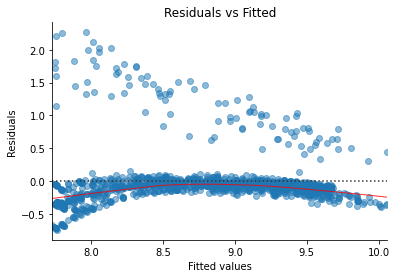

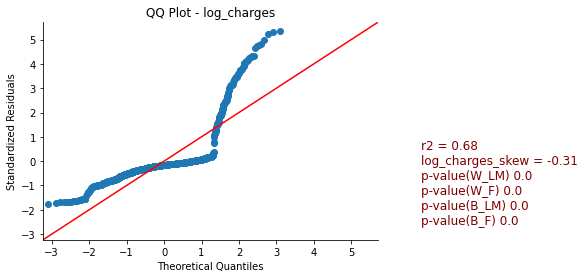

In [29]:
# ols non-smokers - num feats only - transformed target

model_trns_nsmk = reg_res_vis(ins_nosmk_df, ['age', 'bmi', 'children'], 'log_charges', res_plot = True, disp_res = True)

##### Summary:

- Removing non-smokers did improve mode, but still both normality & homoscedasticity assumptions are violated

- 'bmi' shifted from being significant to being insignificant after transformation

##### Conclusion:
- We are moving in the correct direction but still can't fully trust model estimates because of linear assumptions violations. This means that we can't say that shift in 'bmi' significance is true as p-values are unreliable.

- We can assume normality based on the central limit theorem as we have 1k samples which is > 30 * df, but it is too early as we still have categorical features to further improve results.

##### Let’s examine the effect of dropping influential points.

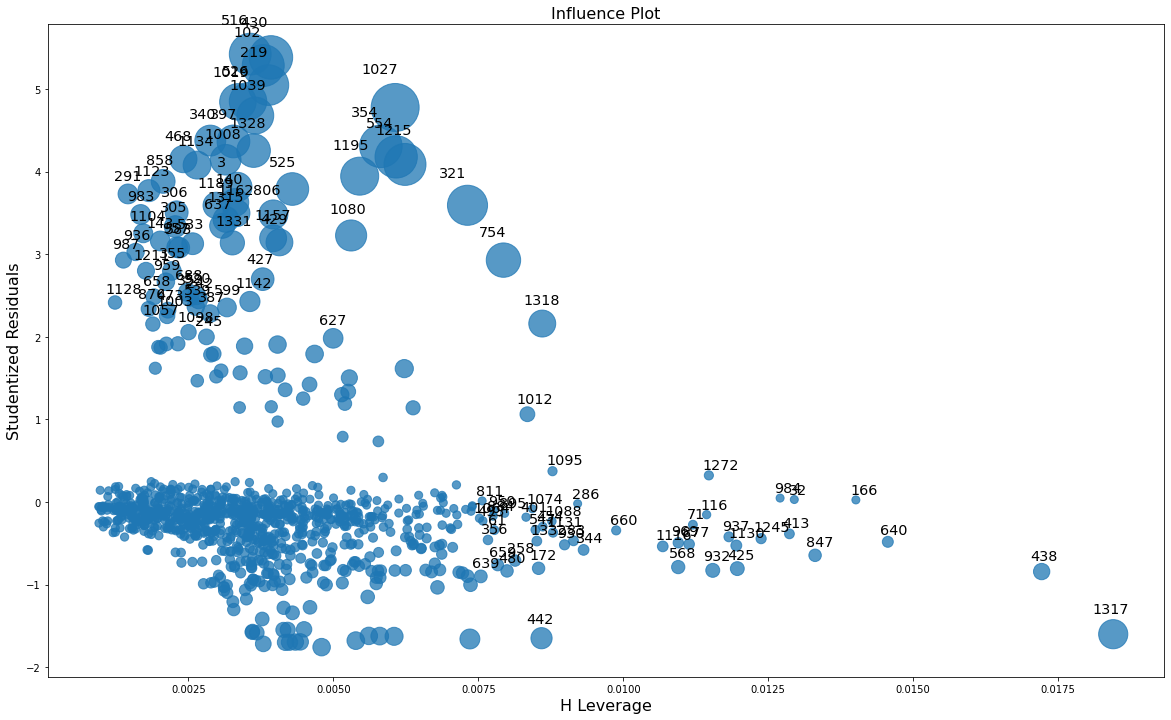

In [30]:
# Checking influential points based on Cook's distance calculation
fig, ax = plt.subplots(figsize = (20,12))
sm.graphics.influence_plot(model_trns_nsmk, ax = ax);

##### Summary:

- Annotated points are influential points flagged for further analysis
- Removing influential points can improve model estimates and heteroscedasticity issues

##### Notes:

- An outlier is a data point whose response $y$ does not follow the general trend of the rest of the data, A data point has *high leverage* if it has 'extreme' $x$ values. For example (just for demonstrating concept, this is not an interpretation of above plot):
    - Ignore all data points > $y$ = 1 in the above plot and imagine a line passing through $y$ = 0; point '1012' is an outlier as it does not follow general trend but does not have high leverage as $x$ value is not extreme, point '438' has high leverage but not an outlier (follows the trend but has extreme $x$ value).
    
    - Are any of these points influential? Yes, **IF** regression estimate is significantly affected by the removal of these points; an easy way to find this out is to compute regression twice - once with and another without the point.
    
    - Outliers with high leverage are influential, example point '1317'

- Studentized Residuals: For a specific point is the residuals of the model without that observation included over the
estimated standard deviation without that observation included, mainly used for detecting outliers (unusual observations in $y$).

- Cook’s distances: Cook’s distance is a combination of an observation’s leverage and residual value, mainly used for detecting influential points (unusual observations in $x$ & $y$).

##### Conclusion:

- We'll experiment with different approaches to identify and remove influential points:
    - Cook’s Distance only 
    - Studentized Residuals only
    - Union of points highlighted by both Cook’s Distance and Studentized Residuals.
    - Intersection of points highlighted by both Cook’s Distance and Studentized Residuals.

In [31]:
# get index of influential points using cook distance & student residuals
cook_list, ext_list, c_e_inter, c_e_union = inf_points(ins_nosmk_df, model_trns_nsmk, alpha = 0.05)

In [32]:
# drop inf points - Studentized Residuals estimates
df_nsmk_inf_free = ins_nosmk_df.drop(ext_list)

df_nsmk_inf_free.head()

age     sex    bmi  children smoker     region    charges  log_charges  \
1   18    male  33.77         1     no  southeast  1725.5523     7.453882   
2   28    male  33.00         3     no  southeast  4449.4620     8.400763   
4   32    male  28.88         0     no  northwest  3866.8552     8.260455   
5   31  female  25.74         0     no  southeast  3756.6216     8.231541   
6   46  female  33.44         1     no  southeast  8240.5896     9.016949   

   yj_charges  
1    8.805045  
2   10.142157  
4    9.940531  
5    9.899133  
6   11.042355

                            OLS Regression Results                            
Dep. Variable:            log_charges   R-squared:                       0.933
Model:                            OLS   Adj. R-squared:                  0.933
Method:                 Least Squares   F-statistic:                     4610.
Date:                Sat, 31 Dec 2022   Prob (F-statistic):               0.00
Time:                        12:00:54   Log-Likelihood:                 284.03
No. Observations:                 997   AIC:                            -560.1
Df Residuals:                     993   BIC:                            -540.4
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         6.7833      0.032    208.738

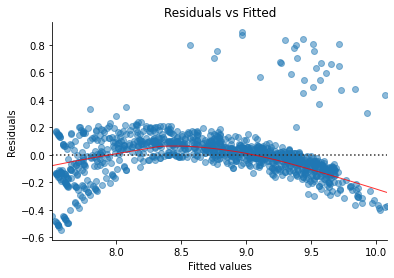

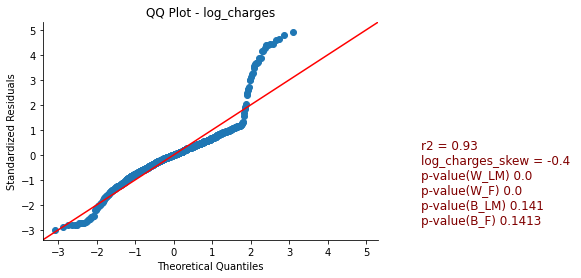

In [33]:
# ols - nsmoker and inf points dropped (studentized), transformed target

model_trns_nsmk_ninf = reg_res_vis(df_nsmk_inf_free, ['age', 'bmi', 'children'], 'log_charges', res_plot = True, disp_res = True)

Yaaay! Approximately normal distribution with fairly equal residuals. The down side is that we lost some information removing 67 (1,064 - 997) observations from model; these points worth investigation to understand the reason behind their influence.

Ok, we stop here and dig into categorical features then back to modeling; we already have a rough idea about what needs to be done:

- Two models for different smoker groups, our analysis so far indicates that smoker feature is the causing significant deviation in charges

- Remove influential points

- Transform target variable

What's important to consider is even if the current model met all regression assumptions, is it relevant? Can we trust it? I believe that modeling medical expenses based only on someone’s age, weight and number of children is, generally, not sufficient; unless there is a strong evidence to believe otherwise. To sum-up, even if the model meets regression assumptions, we need to question its relevance to the intended use.

On the other hand, If the model violates some assumptions, we just don't throw it away; the degree of violation needs to be assessed and reported.

##### Notes:

- 'bmi' is now significant, we can trust this model's estimates than the previous ones and rely on p-values.

##### Now let's get right into categorical feature and multivariate analysis!

**<a href="#toc" style='color:#00ffff'>Table of contents</a>**

<a id='bicat'></a>

### Bivariate analysis - Categorical vs Categorical variables

In [34]:
# smoker given region
print(ins_df.smoker.value_counts(normalize=True).round(2))

pd.crosstab(ins_df.smoker, ins_df.region, normalize = 'index', margins = True).round(2)

no     0.8
yes    0.2
Name: smoker, dtype: float64


region  northeast  northwest  southeast  southwest
smoker                                            
no           0.24       0.25       0.26       0.25
yes          0.24       0.21       0.33       0.21
All          0.24       0.24       0.27       0.24

In [35]:
# smoker given sex
pd.crosstab(ins_df.smoker, ins_df.sex, normalize = 'index', margins = True).round(2)

sex     female  male
smoker              
no        0.51  0.49
yes       0.42  0.58
All       0.49  0.51

In [36]:
# sex given region
pd.crosstab(ins_df.sex, ins_df.region, normalize = 'index', margins = True).round(2)

region  northeast  northwest  southeast  southwest
sex                                               
female       0.24       0.25       0.26       0.24
male         0.24       0.24       0.28       0.24
All          0.24       0.24       0.27       0.24

##### Summary:
- Smokers represent 20% of all observations of which 58% are males, 33% of smokers are from 'southeast' of which 28% are males, 'southeast' region represents only 27% of all observations!

##### Notes:
- 'All' row represents frequency of feature values (e.g.: 27% of all observations are from 'southeast'), columns do not add up to 100%
- Rows represents the distribution of one categorical feature across the corresponding categorical feature, they add up to 100%.

##### Conclusion:
- In this particular dataset, we'd expect that majority of smokers are males from 'southeast' region

- Since we know that smoker is highly significant predictor of charges, it might be causing *fake* significance for 'southeast' region as well; having high percentage of smokers compared to other regions. By *fake* we mean that 'region' may not be a significant predictor of charges and the reason for variation follows smokers distribution. In other words, having both 'smoker' and 'region' features in a model results in a same model as having 'smoker' feature only.

##### Is smoker contingent (depends) on sex and/or region, or are they independent?

In [155]:
# test independence of variables
# null: both categories are independent

crss_res = []

for comb in combinations(cat_cols_ins,2):
    crss_tab = pd.crosstab(ins_df[comb[0]], ins_df[comb[1]])
    chi2, p = stats.chi2_contingency(crss_tab)[:2]
    crss_res.append((comb[0], comb[1], chi2, p))
    
pd.DataFrame(crss_res, columns = ['feature', 'feat', 'chi2', 'p_val(chi2)']).set_index('feature').rename_axis(None).round(3).T

sex     sex  smoker
feat         smoker  region  region
chi2          7.393   0.435   7.343
p_val(chi2)   0.007   0.933   0.062

##### Conclusion:

- Significant p-value (< 0.05) suggests that relationship between smoker and gender(sex) is significant, both categories are dependent, which means that partitioning of smoker feature by gender (sex) results in different frequencies; this is also noted from crosstab of both features.

- Same with 'smoker' and 'region' features, p-value suggests that the relationship is not significant thus both categoris are independent. However, the p-value is close to significance threshold 0.05 of rejecting null.

##### Does this mean that smoker feature only have same influence on charges as  smoker, sex and region combined ?  

**<a href="#toc" style='color:#00ffff'>Table of contents</a>**

<a id='bicatv'></a>

### Bivariate analysis - Categorical vs numeric variables

We'll explore two common tests:

- **Student's t-tests (t):** suitable for comparing two groups. Identifies the difference between two group mean values using a separate numeric variable, example: for smoker feature the test will identify difference in mean medical charges between the two groups (smoker and non-smoker). It answers to 'is there a statistically significant difference between the mean of the two groups?'. If the means of these two groups are far enough (i.e.: different) then we conclude that this feature has a statistically significant relationship to the target. The further the means of the two groups the larger the t-statistic.

- **One-way analysis of variance ANOVA (F):** similar to t-test, the main difference is that ANOVA is applicable to features with more than two groups (e.g.: region). ANOVA results are exactly the same as t-test if used on two groups only. In short, ANOVA is used to find out how the mean value of a numerical target depends on one or more feature.

Assumptions to consider when carrying out ANOVA are:

- Residuals are:
    - Homoscedastic (have equal variance).
    - Approximately normally distributed.
   
- Observations are independent - meaning the observed values are not correlated in some way. 

Notice that these assumptions all have to do with the residuals (after fitting model), not with independent variable itself (groups) Of course, for a t-test, saying the residuals are normally distributed is the same as saying each group is normally distributed.

##### Notes:

- Groups refer to the cardinality of categorical feature. Example, 'sex' has two groups (male and female) while region has four groups (southeast, southwest, northeast, northwest)

- t-stat: 

    - One or two sided test? In order to determine whether the test is 'one-tailed' or 'two-tailed' we need to have a good theoretical explanation for why we would never expect a significant difference in means of one of the two directions. Example: Smoking is known to cause health issues so we expect that not only there is a difference between the insurance charges means of the two groups (smoker and non-smoker) we would also expect that the mean of smoker charges to be significantly higher than those of non-smokers and not other way around. Thus we want to retrieve the p-value based on 'one-sided' test, this means that we will only consider the insurance charges means to be different if that of smokers is greater than that of the non-smokers, And, if results shows that non-smokers costs more insurance charges than smokers, then we will consider the result is only due to chance and we will not consider it a significant difference
    
    - Two sided test means that we do not have a good theory which group will be higher or lower than another and we want to explore it. **By default python use two sided test.**
    
    -  If the sample sizes in the two groups being compared are equal, t-test is highly robust to the presence of unequal variances
    
- One-way ANOVA:

    - The ANOVA model is robust to the violation of normality assumption, which means that it will have a non-significant effect on Type I error rate and p values will remain reliable as long as there are no outliers
    
    - F value is inversely related to p value and higher F value (greater than F critical value) indicates a significant p value
    
    - If the group sample size and variances are unequal, the statistical power of an ANOVA is reduced
    
- Both methods tests the null hypothesis that there is no difference between group means

In [38]:
# Check sample size

for col in cat_cols_ins:
    print(col, (ins_df[col].value_counts().min(), ins_df[col].value_counts().max(), round(ins_df[col].value_counts().std())))

sex (662, 676, 10)
smoker (274, 1064, 559)
region (324, 364, 20)


##### Conclusion:

- Sample size for smoker group is not equal, should consider this in interpreting ANOVA and t-test results

**<a href="#toc" style='color:#00ffff'>Table of contents</a>**

<a id='anov'></a>

#### One-way ANOVA

In [39]:
# One-way ANOVA and
# Kruskal-Wallis H (non-parametric equivalent of the One-Way ANOVA)

def anova(df, cols, target, figsize = (12,3)):

    summary = []

    fig = plt.figure(constrained_layout=True, figsize = figsize)

    for i, v in enumerate(cols):

        # groups within cat feature
        groups = [df[target][df[v] == g] for g in df[v].unique()]

        # One-way ANOVA
        f, p_f = stats.f_oneway(*groups)

        # Kruskal-Wallis H (non-parametric equivalent of the One-Way ANOVA)
        h, p_h = stats.kruskal(*groups)

        # Checking Homogeneity of variances

        # assuming data is not normally distributed
        p_v = stats.levene(*groups).pvalue
        # assuming data is normally distributed
        p_b = stats.bartlett(*groups).pvalue

        acc_rej_lev = [f'True ({p_v.round(4)})' if  p_v > 0.05 else f'False ({p_v.round(4)})'][0]
        acc_rej_bar = [f'True ({p_b.round(4)})' if  p_b > 0.05 else f'False ({p_b.round(4)})'][0]

        # update results
        summary.append((v, round(f,0), round(p_f,4), round(h,0), round(p_h,4), acc_rej_lev, acc_rej_bar))

        # visualize numeric distribution
        fig.add_subplot(int(np.ceil(len(cols)/4)), 4, i+1)
        ax = sns.kdeplot(x = df[target], hue = ins_df[v])
        sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
        plt.gca().spines[['top', 'right']].set_visible(False)
        plt.xticks(rotation = 90); 

    # ANOVA/Krus dataframe
    anova_df = pd.DataFrame(summary, 
                            columns = ['feature', 'f_stat', 'p_val(f)', 'h_stat', 'p_val(h)', 'eq_var(lev)', 'eq_var(bart)'])
    return anova_df

feature  f_stat  p_val(f)  h_stat  p_val(h)     eq_var(lev)    eq_var(bart)
0     sex     4.0    0.0361     0.0    0.7286  False (0.0017)  False (0.0001)
1  smoker  2178.0    0.0000   589.0    0.0000     False (0.0)     False (0.0)
2  region     3.0    0.0309     5.0    0.1923  False (0.0009)     False (0.0)

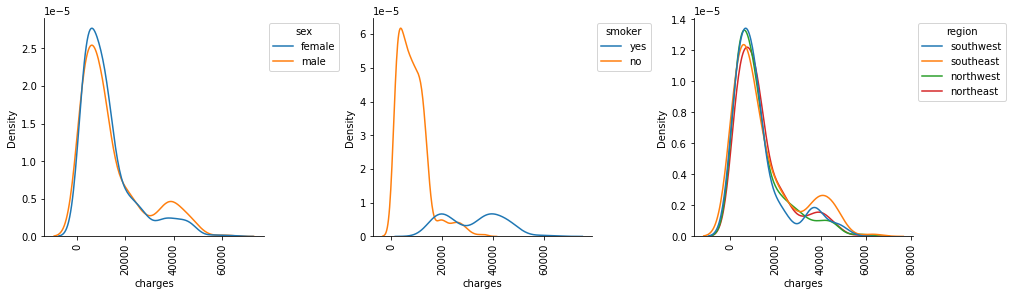

In [40]:
# ANOVA - original target
anova(ins_df, cat_cols_ins, 'charges', figsize = (17,4))

feature  f_stat  p_val(f)  h_stat  p_val(h)     eq_var(lev)    eq_var(bart)
0     sex     0.0    0.8366     0.0    0.7286  False (0.0001)  False (0.0001)
1  smoker  1062.0    0.0000   589.0    0.0000     False (0.0)     False (0.0)
2  region     1.0    0.2406     5.0    0.1923  False (0.0001)  False (0.0006)

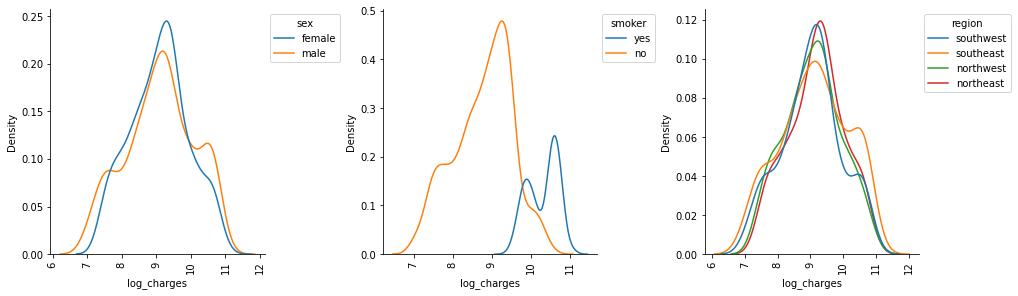

In [41]:
# ANOVA - transformed target
anova(ins_df, cat_cols_ins, 'log_charges', figsize = (17,4))

In [42]:
# diff in group means before and after transformation
ins_df.groupby('sex')['charges'].mean().round(2), ins_df.groupby('sex')['log_charges'].mean().round(2)

(sex
 female    12569.58
 male      13956.75
 Name: charges, dtype: float64,
 sex
 female    9.09
 male      9.10
 Name: log_charges, dtype: float64)

##### Summary:

- Using original target (before transformation):

   - Significant p-value (of both ANOVA and Krus tests) for smoker feature suggests that there is a significant difference in means/medians of two groups and thus has an effect on insurance charges. This is true based on our earlier analysis and can also be noted from kde plot as both groups have different distribution (the two distribution are separated).

   - ANOVA result for both 'sex' and 'region' also appear to have an effect on charges, however, not as significant as 'smoker' feature as noted from size of calculated statistic (f) which is small and the associated p-values are close to 0.05; We can also observe this from kde plots as groups tend to have similar distribution with minor variation.

- Using transformed target (log transformation):

   - ANOVA agrees with Kruskal test, difference between means for both 'region' and 'sex' appears to be insignificant.
 
- Both equal variance assumption tests are significant, which means that groups do not have equal variance.

- One purpose of this analysis is to identify, for each feature, significance and associated problems that may affect our final model.

##### P-hacking:
- Calculating bunch of statistics and picking ones that are favorable (significant) is not desired, in our example both tests agree on the significance of 'smoker' feature but not on the other two; which one to trust? Should we consider the results for 'sex' and 'region' to be statistically significant?

##### Let's visually inspect variance between groups

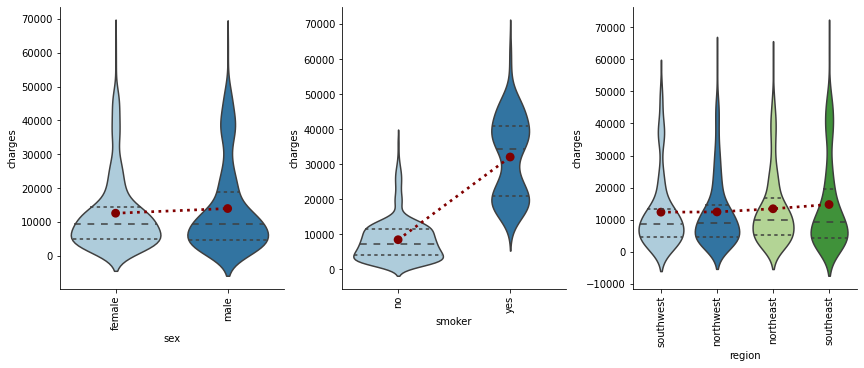

In [43]:
# visualize numeric distribution
fig = plt.figure(constrained_layout=True, figsize = (15,5))

for i, v  in enumerate(cat_cols_ins):
    fig.add_subplot(int(np.ceil(len(cat_cols_ins)/4)), 4, i+1)
    # sorting the plot
    order = ins_df.groupby(v)['charges'].mean().sort_values().index
    
    # plot
    sns.violinplot(x = ins_df[v], y = ins_df.charges, palette = 'Paired', inner = 'quartile',
                order = order)
    sns.pointplot(x = ins_df[v], y = ins_df.charges, order = order, color = 'maroon', errorbar = None, seed = 1,
              linestyles = ':')
#     sns.barplot(x = ins_df[v], y = ins_df.charges, palette = 'Paired', 
#                 order = order)
#     sns.boxplot(x = ins_df[v], y = ins_df.charges, palette = 'Paired', 
#                 order = order)
    plt.gca().spines[['top', 'right']].set_visible(False)
    plt.xticks(rotation = 90);

In [44]:
# region distribution
ins_df.groupby('region')['charges'].agg(['mean', 'std']).round().sort_values('mean')

mean      std
region                     
southwest  12347.0  11557.0
northwest  12418.0  11072.0
northeast  13406.0  11256.0
southeast  14735.0  13971.0

##### Summary:
- Overall distribution of 'sex' and 'region' is roughly the same, however, we can observe unequal variance in interquartile ranges (distance between first 'Q1' and last 'Q3' dotted lines inside each violin) of each group; means of groups (connected maroon dots) tends to have minor variances, however, there is a visible upward tick in 'region' feature.

- 'Smoker' immediately stands out with a significant difference in means and distribution of the two groups.

##### Notes:
- Shape of distribution can be observed from width of each violin, for example, 'sex' is positively skewed, imagine flipping the plot to the right hand side.

- ANOVA test for difference between means (maroon dots), kruskal test for difference between medians (middle line).

##### Why do we need any statistical technique at all to analyze the results in these plots? Why can’t we just interpret the averages that we see plotted before our eyes? 

Because we need to take into account the possibility that the results are due to random influences (chance, random error, sampling error, etc.), we need statistics to rule out the possibility that the real population averages look totally different from what we have observed in our sample.

##### Conclusion:

- Despite that unequal variance test is significant for 'region', indicating a violation in ANOVA assumption. I'm inclined to further investigate these groups, given that:
    - Upward trend in means across groups
    - Groups have equal sample size
    - Variance is visible between southeast and northeast, other two regions have nearly same variance
    
##### Before we run Post hoc analysis, let’s regress charges on region and inspect results

                            OLS Regression Results                            
Dep. Variable:            log_charges   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     1.402
Date:                Sat, 31 Dec 2022   Prob (F-statistic):              0.241
Time:                        12:01:22   Log-Likelihood:                -1783.5
No. Observations:                1338   AIC:                             3575.
Df Residuals:                    1334   BIC:                             3596.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept               

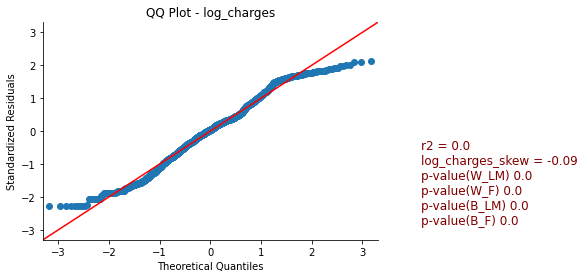

In [45]:
# regressing charges to region only

reg_res_vis(ins_df, ['region'], 'log_charges', disp_res = True);

                            OLS Regression Results                            
Dep. Variable:            log_charges   R-squared:                       0.447
Model:                            OLS   Adj. R-squared:                  0.445
Method:                 Least Squares   F-statistic:                     215.5
Date:                Sat, 31 Dec 2022   Prob (F-statistic):          1.48e-168
Time:                        16:41:11   Log-Likelihood:                -1389.1
No. Observations:                1338   AIC:                             2790.
Df Residuals:                    1332   BIC:                             2821.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept               

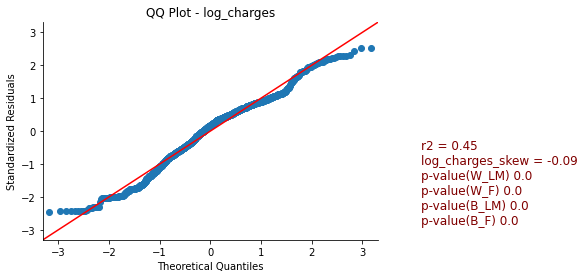

In [156]:
# adding more features to the model - regressing charges to region, sex and smoker

reg_res_vis(ins_df, ['region', 'sex', 'smoker'], 'log_charges', disp_res = True);

                            OLS Regression Results                            
Dep. Variable:            log_charges   R-squared:                       0.443
Model:                            OLS   Adj. R-squared:                  0.443
Method:                 Least Squares   F-statistic:                     1062.
Date:                Sat, 31 Dec 2022   Prob (F-statistic):          5.98e-172
Time:                        16:42:28   Log-Likelihood:                -1394.1
No. Observations:                1338   AIC:                             2792.
Df Residuals:                    1336   BIC:                             2803.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              8.7884      0

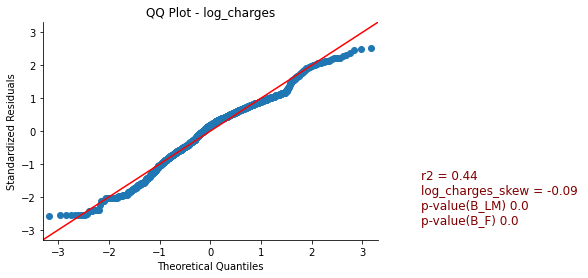

In [157]:
# Assessing dependence of features 

reg_res_vis(ins_df, ['smoker'], 'log_charges', disp_res = True);

##### Summary:
- After including smoker feature to the model, 'southeast' region went from being insignificant (p = 0.509) to being somewhat significant (p =  0.033)

- 'Southeast' is the region with highest mean across all other regions (from violin plot) and of highest smokers (from crosstab) 

- Removing both 'region' and 'sex' from the model did not significantly affect results, almost same model using 'smoker' feature only. This means that significant of both 'region' and 'sex' follows smoker distribution without **real** effect on charges, this is what we discussed in crosstab section earlier.

##### Notes: 
- The bivariate analysis identifies individual feature contribution to the model, highlighting those with significant effect on target variable; results should be taken as a lead for feature inclusion/exclusion at modeling.

- It's important to use all **relevant** features in our model. If we do not do this, we end up with a wrong model and wrong conclusions; this is often referred to as misspecification of a model.

- If a single feature makes a whole lot of difference to the model, it means that the model is incorrect and useless without it. Significance of feature to the model can be noted from size of its coefficient compared to other features. 

##### Conclusion:
- We need to assess results of statistical tests visually and during modeling before ruling out features just because individual test results were significant. It's good to be aware of problematic features ahead of modeling.

- If we have two candidate models, one with problematic feature (e.g. region) and the other without then we may ultimately decide to keep that feature in the model if we have valid justification. For example non-smokers model we created earlier, we obtained improved model after removing 6% of data (influential points), if adding region provides nearly equal or even slightly worse model (based on selected performance measurement) but without removing as many data points, I'd prefer that model to the one we had earlier because it would be an equally comparable model without losing much information.

##### It is probably an overkill to perform Post hoc analysis given number and size of current features, but why not?

**<a href="#toc" style='color:#00ffff'>Table of contents</a>**

<a id='mltcom'></a>

#### Multiple comparisons tests

In [47]:
# Post hoc analysis - t-test

t_tests = []

for i in combinations(ins_df.region.unique(), 2):

    # t-test (assuming qual variance)
    t_t, p_t = stats.ttest_ind(ins_df['charges'][ins_df[col] == i[0]], ins_df['charges'][ins_df[col] == i[1]])

    # Welch's t-test (assuming no-qual variance)
    t_w, p_w = stats.ttest_ind(ins_df['charges'][ins_df[col] == i[0]], ins_df['charges'][ins_df[col] == i[1]], equal_var= False)

    # Mann–Whitney U test (Nonparametric version of two-sided t-test)
    p_mw = stats.mannwhitneyu(ins_df['charges'][ins_df[col] == i[0]], ins_df['charges'][ins_df[col] == i[1]]).pvalue
    
    t_tests.append((i[0], i[1], t_t, p_t, t_w, p_w, p_mw))
    
t_tsts_df = pd.DataFrame(t_tests, columns = ['group_one', 'group_two', 't_stat', 'p_val(t)', 't_w', 'p_val(w)',
                                             'p_val(mw)'])

t_tsts_df

group_one  group_two    t_stat  p_val(t)       t_w  p_val(w)  p_val(mw)
0  southwest  southeast -2.428177  0.015431 -2.454116  0.014372   0.210969
1  southwest  northwest -0.079565  0.936608 -0.079565  0.936608   0.629746
2  southwest  northeast -1.182966  0.237257 -1.183014  0.237238   0.037490
3  southeast  northwest  2.393947  0.016935  2.425150  0.015562   0.401406
4  southeast  northeast  1.363169  0.173276  1.380165  0.167990   0.569919
5  northwest  northeast -1.128168  0.259667 -1.128139  0.259679   0.115450

##### Summary:
- t-test is significant for :
    - index 0: 'southwest' vs 'southeast'
    - index 3: 'southeast'vs 'northwest'

- We know from earlier that there is a violation in equal variance assumption so we accounted for that using welch's t-test, difference between both tests are exactly the same in the absence of equal variance assumption violation.

- Non-parametric version of t-test (Mann–Whitney U) is significant for (index 2: 'southwest' vs 'northeast'). We are not drifting into a p-hacking scenario, rather observing difference between all methods.

##### Conclusion:

- We'll rely on welch's test results to account for unequal variance given that groups have equal sample size, the results conforms to what was noted from violin plot.

##### Running multiple hypothesis tests leads to [Multiple comparisons problem](https://en.wikipedia.org/wiki/Multiple_comparisons_problem) that warrants correction!

In [48]:
# Multiple comparison correction - Tukyhsd

# if the sample sizes of groups are unequal, Tukey-Kramer procedure is automatically used
mc = MultiComparison(ins_df.charges, ins_df.region)

print(mc.tukeyhsd())

       Multiple Comparison of Means - Tukey HSD, FWER=0.05       
  group1    group2   meandiff  p-adj    lower      upper   reject
-----------------------------------------------------------------
northeast northwest  -988.8091 0.7245 -3428.9343 1451.3161  False
northeast southeast  1329.0269 0.4745 -1044.9417 3702.9955  False
northeast southwest -1059.4471 0.6792 -3499.5723 1380.6781  False
northwest southeast  2317.8361 0.0583   -54.1994 4689.8716  False
northwest southwest    -70.638 0.9999 -2508.8826 2367.6066  False
southeast southwest -2388.4741 0.0477 -4760.5096  -16.4386   True
-----------------------------------------------------------------


In [49]:
# Multiple comparison correction - Bonferroni

# adjusted p-val
threshold = 0.05 / len(t_tsts_df)

print('Adjusted threshold: ', threshold)

# statistical significance
t_tsts_df[t_tsts_df['p_val(t)'] <= threshold]

Adjusted threshold:  0.008333333333333333


Empty DataFrame
Columns: [group_one, group_two, t_stat, p_val(t), t_w, p_val(w), p_val(mw)]
Index: []

In [50]:
# Multiple comparison correction - Bonferroni statsmodels
result, a1, a2 = mc.allpairtest(stats.ttest_ind, method= 'bonf')
result

<class 'statsmodels.iolib.table.SimpleTable'>

##### Why do we do these correction tests?

- At each comparison we assume 5% probability of rejecting null hypothesis by chance (due to randomness), so for 6 comparisons in 'region' feature there is 74% (.95^6) probability of coming to correct conclusions (no incorrect rejection of null); we suddenly have p-val of 26% of committing type1 error (false positive, reject null while it is true) leading to less confidence in test results.

- In order to avoid this we need to scale down significance threshold (Family wise error rate FWER) through corrections that accounts for n tests performed; there are several correction methods, the simplest and most conservative is dividing significance threshold by the number of tests performed, this is known as Bonferroni correction.

##### Notes:

- In statsmodels Bonferroni and TukeyHSD tables the column 'reject' refers to the null hypothesis being tested (groups have equal mean), if True means reject null and accept alternative that groups have different means.

##### Conclusion:

  - Using original target, ANOVA says 'region' groups has variation in means, t-test says that variation is contributed to 'southeast' region which is confirmed (almost, p-value is 0.047) by Tukey correction, however, Bonferroni correction is being conservative and err to the side of absence of difference between group means; interesting!
  
  - The above statement is all what we need for now, knowing problems associated with features ahead of modeling will facilitate final model selection as discussed earlier.
  
##### Time for Multivariate analysis!

**<a href="#toc" style='color:#00ffff'>Table of contents</a>**

<a id='multi'></a>

#### Multivariate analysis

In [144]:
# helper function - Multivariate trend lines

def multi_reg_vis(df, y, cols, cat_feat):
    """
    Visualize multiple feature effect on target
    """
    
    assert type(cols) == list, 'please pass columns as list'
    
    for col in cols:

        r2 = []

        for g in df[cat_feat].unique():

            model = ols(f'{y}~Q("{col}")', data = df[df[cat_feat] == g]).fit()
            
            r2.append((g, model.rsquared.round(2)))

        text = '\n'.join([f'{cat_feat}_{r2[i][0]}_r2 = {r2[i][1]}' for i, v in enumerate(r2)]) 
        
        ax = sns.lmplot(x = col, y = y, hue = cat_feat, data = df, palette = 'rocket', 
                        line_kws = {'color':'purple'}, seed = 1)

        ax.ax.get_lines()[0].set_color('orchid'); ax.ax.get_lines()[1].set_color('maroon')

        ax.ax.text(1, 0.116, text, verticalalignment = 'bottom', horizontalalignment = 'left', 
                    transform = plt.gcf().transFigure, color = 'maroon', fontsize = 12)
        plt.show()

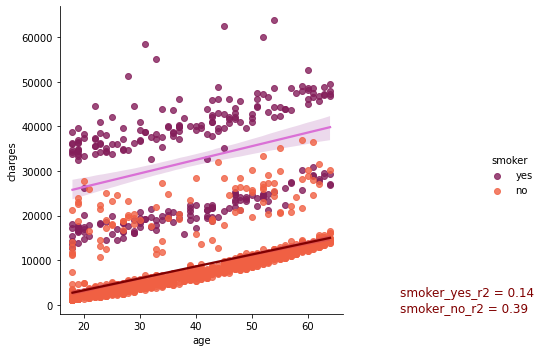

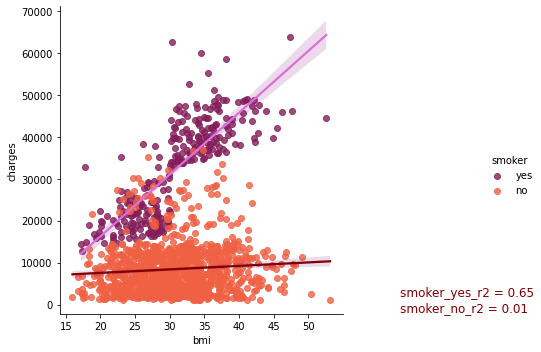

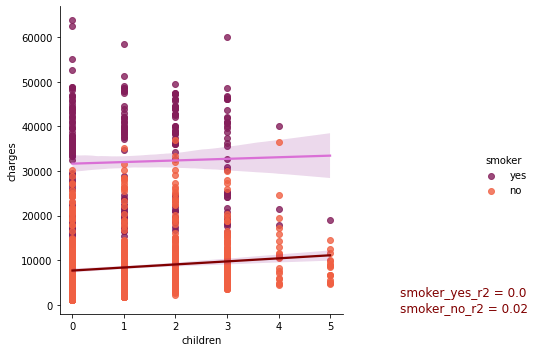

In [145]:
# Smoker feature
multi_reg_vis(ins_df, 'charges', list(num_cols_ins.drop('charges')), 'smoker')

##### Summary:

  - Smoker group tend to have higher charges than non-smokers
  - Age has higher effect on medical charges of non-smokers group; contrary to smokers.
  - Bmi effect on smoker charges is higher than non-smokers, however, there is a distinct group of young adults (age 20 - 30) who share similar charges range (15k to 25k) regardless of being smoker or not.
  - Number of children has almost negligible effect on both smokers group, although it is slightly higher for nonsmokers than smokers group
    
##### Notes:

  - $r^2$ is just to get a 'feel' for difference between models, it's by no means a quantification of effect size.

  - The two lines represent separate fits on smoker groups, Example: red line represent the effect of age on non-smokers charges.

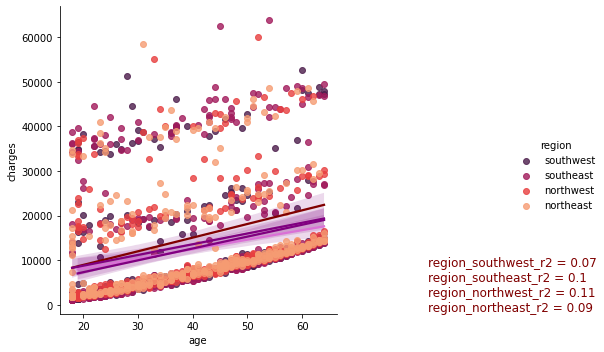

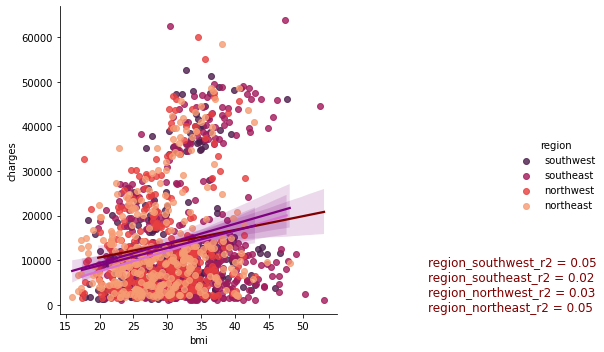

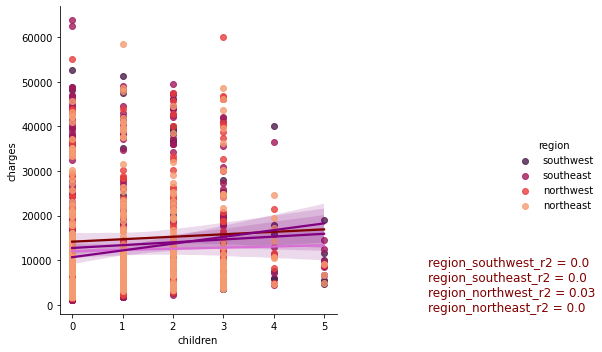

In [146]:
# Region feature
multi_reg_vis(ins_df, 'charges', list(num_cols_ins.drop('charges')), 'region')

##### Summary:

Region is randomly scattered, no clearly visible pattern.

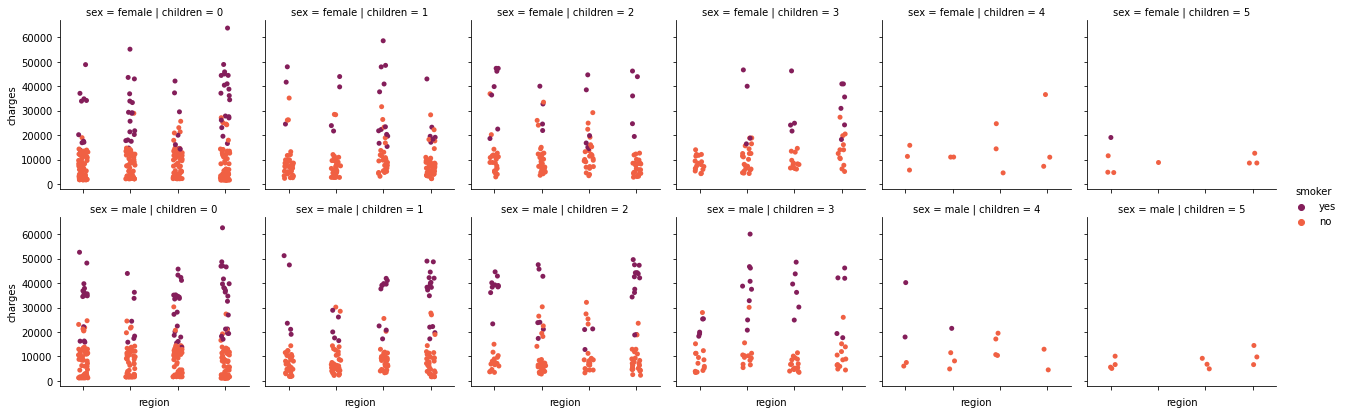

In [110]:
# All categorical features in one plot

order = ins_df.groupby('region')['charges'].mean().sort_values().index

vis = sns.catplot(x = 'region', y = 'charges', hue = 'smoker', row = 'sex', col = 'children', data = ins_df, order = order,
                  height = 3, palette = 'rocket', seed = 1)

vis.set_xticklabels(rotation = 25);

##### Summary:

- Each bar displays how spread out this combination of features across target variable (charges). We can observe that:
    - Smokers tend to have higher medical charges regardless of sex, region or number of children
    - Spread of charges across most regions is equally similar regardless of sex or number of children; however, the 'southwest' region has fewer customers in the range of 25k to 35k charges. 

- There is a problem with children feature being the absence of enough samples across the different ranges of number of children and other categorical features. Example: numbers of customers having 5 children is the smallest followed by those having 4 children, we can literally count number of observations just by eyeballing; additionally, there are no male smokers with 5 children, similarly, there are no female smokers with 4 children.

##### Conclusion:

- There are several samples (customers) that are interesting to explore, example: non-smoker female outlier in 'southeast' region that have 4 children and non-smokers from other regions that have similar charges and number of children.

In [55]:
# exploring outlier customers

col_drop = ['children', 'smoker', 'sex', 'log_charges', 'yj_charges']

display(ins_df[(ins_df.sex == 'female') & (ins_df.smoker == 'no') & 
               (ins_df.children == 4)].sort_values('charges', ascending = False).drop(col_drop, axis =1).T,
        ins_df[(ins_df.sex == 'female') & (ins_df.smoker == 'no') & 
               (ins_df.children == 3)].sort_values('charges', ascending = False).drop(col_drop, axis =1).T,
        ins_df[(ins_df.sex == 'female') & (ins_df.smoker == 'no') & 
               (ins_df.children == 2)].sort_values('charges', ascending = False).drop(col_drop, axis =1).T)
        

1012         321          1253         659        1094  \
age               61           26           40           57         50   
bmi            33.33        29.64         29.3       28.785       33.7   
region     southeast    northeast    southwest    northeast  southwest   
charges  36580.28216  24671.66334  15828.82173  14394.39815  11299.343   

               83          1154        344        891        1064       1095  
age              48          48          49         36         29         18  
bmi           41.23       27.93       41.47      29.04       25.6      31.35  
region    northwest   northwest   southeast  southeast  southwest  northeast  
charges  11033.6617  11015.1747  10977.2063  7243.8136   5708.867  4561.1885

138          264          159          1195        429   \
age               54           53           50           19          27   
bmi             31.9        38.06        27.83        27.93        30.4   
region     southeast    southeast    southeast    northwest   northwest   
charges  27322.73386  20462.99766  19749.38338  18838.70366  18804.7524   

                378         603          36           267          912   ...  \
age               64          64           62           59           59  ...   
bmi           30.115       39.05       32.965       32.395       26.695  ...   
region     northwest   southeast    northwest    northeast    northwest  ...   
charges  16455.70785  16085.1275  15612.19335  14590.63205  14382.70905  ...   

              536        1119       187         1113       145        389   \
age             33         30         30          28         29         24   
bmi           38.9      19.95       30.9      26.315      38.83      30.21   
region   southwest  northwest  southwest   northwest  southeast  northwest   
charges   5972.378  5693.4305   5325.651  5312.16985  5138.2567  4618.0799   

              643        869        1242       732   
age             23         25         22         24  
bmi          34.96       24.3      21.28       30.1  
region   northwest  southwest  northwest  southwest  
charges  4466.6214   4391.652  4296.2712   4234.927  

[4 rows x 63 columns]

1206         599          696          1019         637   \
age               59           52           53           21           35   
bmi             34.8       37.525         32.3        32.68       38.095   
region     southwest    northwest    northeast    northwest    northeast   
charges  36910.60803  33471.97189  29186.48236  26018.95052  24915.04626   

                526          1328         306          334          825   ...  \
age               19           23           28           43           64  ...   
bmi            30.59       24.225         27.5        35.72       31.825  ...   
region     northwest    northeast    southwest    northeast    northeast  ...   
charges  24059.68019  22395.74424  20177.67113  19144.57652  16069.08475  ...   

              1017       186        760        51         699         46    \
age             26         26         22         21         23          18   
bmi           34.2      29.92      34.58      33.63      39.27      38.665   
region   southwest  southeast  northeast  northwest  southeast   northeast   
charges   3987.926  3981.9768  3925.7582  3579.8287  3500.6123  3393.35635   

              364        541        926        564   
age             21         20         19         18  
bmi          21.89      31.79       23.4      32.12  
region   southeast  southeast  southwest  southeast  
charges  3180.5101  3056.3881   2913.569  2801.2588  

[4 rows x 97 columns]

In [56]:
# even more interesting  samples, all are non-smoker females

ins_df.iloc[[1012, 1206, 825, 378, 603, 1094, 138, 264, 159, 599, 696]].drop(col_drop[1:], axis =1). \
sort_values(['charges', 'age', 'bmi'], ascending=False). \
style.format({'charges':'{:,.0f}', 'bmi':'{:,.0f}'}).\
apply(lambda x: ['background: purple' if x.name in [696,264,378,603,825] else '' for i in x], axis = 1)

##### Summary:

- Despite that all these samples represent non-smoker females, there are identical patterns with unexplainable difference in charges. Example: idx 696 and 825, both customers have identical features except age; however, younger customer costs more than the older one.

- Customers with low bmi costing more than those with higher one despite being in same age group and have similar number of children, region appears to be the only difference between these customers. Example: Indices 378, 603, 825
    
##### Conclusion:

- There is definitely some missing features that explains variation in non-smoker group that what we already have.

##### It is time to start modeling!

**<a href="#toc" style='color:#00ffff'>Table of contents</a>**

<a id='fd'></a>

### Modeling

We will build 3 models; one for full and rest for separated smoker groups while experimenting with the following:
- w/wo transformation
- w/wo influential points

#### Modeling - Full data

                            OLS Regression Results                            
Dep. Variable:                charges   R-squared:                       0.751
Model:                            OLS   Adj. R-squared:                  0.749
Method:                 Least Squares   F-statistic:                     500.8
Date:                Sat, 31 Dec 2022   Prob (F-statistic):               0.00
Time:                        12:02:43   Log-Likelihood:                -13548.
No. Observations:                1338   AIC:                         2.711e+04
Df Residuals:                    1329   BIC:                         2.716e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept               

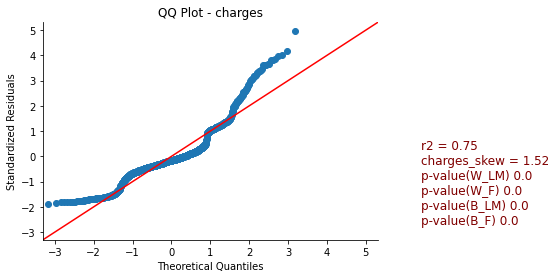

In [57]:
# modeling - full data, original target, all features

# features
feats = ins_df.columns.drop(['charges', 'log_charges', 'yj_charges'])

# model
model_full = reg_res_vis(ins_df, list(feats), 'charges', disp_res = True);

- 'sex' appears to be insignificant (p > 0.05), and two of 'region' feature as well.
- Normality and homoscedasticity assumptions are violated

In [58]:
# sequential ANOVA test - full data, original target, all features
sm.stats.anova_lm(model_full, typ=1).round(4)

df        sum_sq       mean_sq          F  PR(>F)
Q("sex")          1.0  6.435902e+08  6.435902e+08    17.5131  0.0000
Q("smoker")       1.0  1.208777e+11  1.208777e+11  3289.2720  0.0000
Q("region")       3.0  1.078004e+08  3.593345e+07     0.9778  0.4023
Q("age")          1.0  1.995928e+10  1.995928e+10   543.1233  0.0000
Q("bmi")          1.0  5.208733e+09  5.208733e+09   141.7378  0.0000
Q("children")     1.0  4.375466e+08  4.375466e+08    11.9063  0.0006
Residual       1329.0  4.883953e+10  3.674908e+07        NaN     NaN

- Type I (sequential) ANOVA assess impact on sum of squared residuals (a.k.a RSS/SSE), it shows how the RSS decreases as
each feature is added to the model. It changes if we order the features in the model differently.

- 'region' is altogether insignificant contrary to regression coef estimates; but we have violation in linear assumptions, so p estimates are unreliable.

In [59]:
# partial ANOVA test - full data, original target, all features
sm.stats.anova_lm(model_full, typ=2).round(4)

sum_sq      df          F  PR(>F)
Q("sex")       5.716429e+06     1.0     0.1556  0.6933
Q("smoker")    1.224468e+11     1.0  3331.9680  0.0000
Q("region")    2.334312e+08     3.0     2.1173  0.0962
Q("age")       1.712447e+10     1.0   465.9837  0.0000
Q("bmi")       5.169225e+09     1.0   140.6627  0.0000
Q("children")  4.375466e+08     1.0    11.9063  0.0006
Residual       4.883953e+10  1329.0        NaN     NaN

- Type II (partial) ANOVA shows how the RSS would increase if each feature was removed from the model, leaving the other features in. It does not change if we reorder the features in the model.

- Both 'region' and 'sex' appears to be insignificant to the model.

In [60]:
# variance inflation factor (VIF) - full data, original target, all features
# there must be a constant (intercept) in the data to work properly
target, features = dmatrices(model_full.model.formula, data=ins_df, return_type='dataframe')

pd.Series([variance_inflation_factor(features.values, i) for i in range(features.shape[1])], index = features.columns)

Intercept                   35.527488
Q("sex")[T.male]             1.008900
Q("smoker")[T.yes]           1.012074
Q("region")[T.northwest]     1.518823
Q("region")[T.southeast]     1.652230
Q("region")[T.southwest]     1.529411
Q("age")                     1.016822
Q("bmi")                     1.106630
Q("children")                1.004011
dtype: float64

All looks good, since all of the VIF scores are roughly equal to  1, we can conclude that there are no variables correlated with one another. Rule of thumb is:

- vif < 10: adequate.
- vif < 5: good.
- vif < 3: ideal.

If any were >= 10 then it needs to be removed from model.

**<a href="#toc" style='color:#00ffff'>Table of contents</a>**

<a id='ms'></a>

### Model Selection

We'll employ brute force approach to model selection which is to exhaustively evaluate all possible combinations of the input features, then select best subset. Selecting best subset is based on several metrics among which:

##### Mallows' Cp (Cp):
- Cp compares the precision and bias of the full model (all features included) to models with a subset of features, where:

    - Precision is a measure of variance in estimating the true regression coefficients, low is better. Magnitude (value) of Cp indicates that the subset has a small variance.

    - Bias is a measure of deviation of model’s prediction on unseen(new) data compared to the training data, Cp value that is close to the number of predictors plus the constant indicates that the model is relatively unbiased.

    - Biased models with poor fit have values of Cp larger than p. 

- We are looking for subsets that:

    1. Have Low value of Cp
    2. Cp value is close to the number of variables in the model plus the constant (intercept) 
    3. Relates to models with high adjusted r2

##### Akaike information criterion (AIC) and Bayesian information criterion (BIC):

- Both are estimates the relative amount of information lost by a given model: the less information a model loses, the higher the quality of that model. 

- In estimating the amount of information lost by a model, there will be a trade-off between the goodness of fit and the simplicity of the model. Both BIC and AIC attempt to resolve this problem by introducing a penalty term for the number of parameters in the model; the penalty term is larger in BIC than in AIC, so BIC is more conservative than AIC.

- We are looking for subsets with the lowest AIC and BIC scores, prioritizing BIC over AIC.

#### Model selection - Full data

In [61]:
# helper function - model selection (brute force)

def mod_sel(df, cols, target, mse_resid = None):
    """
    brute force model selection - assessing every possible feature combination
    """
    
    assert type(cols) == list, 'please pass columns as list'
    
    # residual mean square of full model for Mallows's Cp metric
    if mse_resid: # if already have a model  
        s2 = mse_resid  # model.ssr / model.df_resid
    else:
        # fit model on full data
        feats_full = '+'.join([f'Q("{f}")' for f in cols])
        formula_full = f'{target}~{feats_full}'
        # auto drop one group (cat feat) and add intercept
        model_full = ols(formula_full, data = df).fit()
        s2 = model_full.mse_resid
    
    results = []
    
    # controling n combinations
    for k in tqdm.trange(1, len(cols) + 1, desc = 'Fitting combos....'): # k = n features, starting at 1,
        # Looping over all possible combinations
        for combo in combinations(cols, k): # 1 feature = 1 combo, 2 features = 2 combos, ......
            # fit model on every subset
            feats_sub = '+'.join([f'Q("{cmb}")' for cmb in combo])
            formula_sub = f'{target}~{feats_sub}'
            # auto drop one group (cat feat) and add intercept
            model_sub = ols(formula_sub, data = df).fit()
            # evaluation metrics
            r2_adj = model_sub.rsquared_adj
            aic = model_sub.aic
            bic = model_sub.bic
            rmse = np.sqrt(model_sub.mse_resid)
            # Mallows's Cp = sse/s^2 - n + 2(P+1)
            n = model_sub.nobs # n observations
            p1 = model_sub.df_model + 1 # p+1, coef + intercept
            sse = model_sub.ssr # sse - sum of squared residuals
            cp_mallow = (sse / s2) - n + 2 * p1
            # update results
            results.append((re.sub('[Q("")]', '', feats_sub).replace('+', ','), r2_adj, cp_mallow, p1, aic, bic, rmse))
    
        results_df = pd.DataFrame(results, columns = ['feat', 'adj_r2', 'cp', 'p_plus_one', 'aic', 'bic', 'rmse'])
        
    return results_df

In [62]:
# model selection - full data, original target
fmodel_selc_df = mod_sel(ins_df, list(feats), 'charges', mse_resid = model_full.mse_resid)

# format numbers
fmt = {'adj_r2':'{:,.4f}', 'cp':'{:,.2f}'} | {f'{c}':'{:,.0f}' for c in fmodel_selc_df.columns[3:]}

fmodel_selc_df.sort_values(['cp', 'bic', 'aic', 'adj_r2'])[:10].style.format(fmt). \
apply(lambda x: ['background: purple' if x.cp <= x.p_plus_one * 2 else '' for i in x], axis = 1)

Fitting combos....: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:08<00:00,  1.47s/it]


##### Conclusion:

- Highlighted models represents those that meets the assessment criteria of each metric, selection between them is to be based on feature analysis done prior to modeling. Example: I'd prefer the model at index 47 as it simpler (less features) and does not include 'region' feature which had low significance in partial and sequential ANOVA test.

##### Time to test linear regression assumptions

                            OLS Regression Results                            
Dep. Variable:                charges   R-squared:                       0.750
Model:                            OLS   Adj. R-squared:                  0.749
Method:                 Least Squares   F-statistic:                     998.1
Date:                Sat, 31 Dec 2022   Prob (F-statistic):               0.00
Time:                        12:02:56   Log-Likelihood:                -13551.
No. Observations:                1338   AIC:                         2.711e+04
Df Residuals:                    1333   BIC:                         2.714e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept           -1.21e+04    941

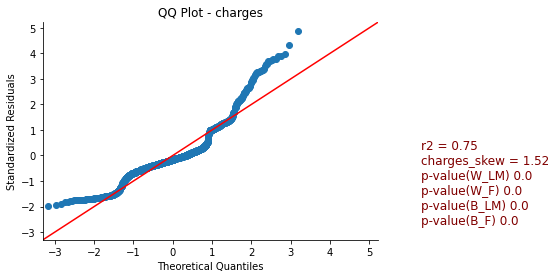

In [63]:
# Test model's linear assumption - full data, original target      
reg_res_vis(ins_df, fmodel_selc_df.loc[47].feat.split(','), 'charges', disp_res = True);

The model have both normality and homoscedasticity issues. Thus estimates are unreliable. Moreover, 'smoker' coef is so significant compared to others rendering the model useless without this feature.

##### It is better to have two models each for a smoker group, but first let's try to improve the full model.

In [64]:
# model selection - full data, transformed target
fmodel_selc_df = mod_sel(ins_df, list(feats), 'log_charges')

fmt_log = {'adj_r2':'{:,.4f}', 'cp':'{:,.2f}', 'rmse':'{:,.2f}'} | {f'{c}':'{:,.0f}' for c in fmodel_selc_df.columns[3:-1]}

fmodel_selc_df.sort_values(['cp', 'bic', 'aic', 'adj_r2'])[:10].style.format(fmt_log). \
apply(lambda x: ['background: purple' if x.cp <= x.p_plus_one * 2 else '' for i in x], axis = 1)

Fitting combos....: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:09<00:00,  1.59s/it]


                            OLS Regression Results                            
Dep. Variable:            log_charges   R-squared:                       0.768
Model:                            OLS   Adj. R-squared:                  0.767
Method:                 Least Squares   F-statistic:                     549.8
Date:                Sat, 31 Dec 2022   Prob (F-statistic):               0.00
Time:                        12:03:08   Log-Likelihood:                -808.27
No. Observations:                1338   AIC:                             1635.
Df Residuals:                    1329   BIC:                             1681.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept               

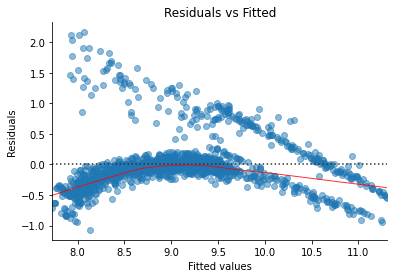

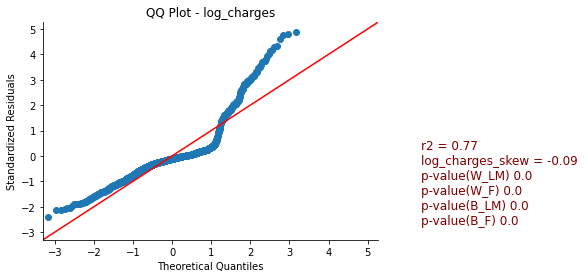

In [65]:
# Test model's linear assumption - full data, transformed target      
sub_feat = fmodel_selc_df.loc[62].feat.split(',')

model = reg_res_vis(ins_df, sub_feat, 'log_charges', res_plot = True, disp_res = True)

Transformation didn't help with both issues.

In [66]:
# identify influential points - full data, transformed target, all features

# get index of influential points using cook distance & student residuals
cook_list, ext_list, c_e_inter, c_e_union = inf_points(ins_df, model, alpha = 0.05)

In [67]:
# drop influential points 
df_full_inf_free = ins_df.drop(c_e_union)

df_full_inf_free.head()

age     sex    bmi  children smoker     region     charges  log_charges  \
0   19  female  27.90         0    yes  southwest  16884.9240     9.734236   
1   18    male  33.77         1     no  southeast   1725.5523     7.453882   
2   28    male  33.00         3     no  southeast   4449.4620     8.400763   
4   32    male  28.88         0     no  northwest   3866.8552     8.260455   
5   31  female  25.74         0     no  southeast   3756.6216     8.231541   

   yj_charges  
0   12.121121  
1    8.805045  
2   10.142157  
4    9.940531  
5    9.899133

In [68]:
# model selection - full data, transformed target, influential points removed 
fmodel_selc_df = mod_sel(df_full_inf_free, list(feats), 'log_charges')

fmodel_selc_df.sort_values(['cp', 'bic', 'aic', 'adj_r2'])[:10].style.format(fmt_log). \
apply(lambda x: ['background: purple' if x.cp <= x.p_plus_one * 2 else '' for i in x], axis = 1)

Fitting combos....: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:08<00:00,  1.43s/it]


                            OLS Regression Results                            
Dep. Variable:            log_charges   R-squared:                       0.916
Model:                            OLS   Adj. R-squared:                  0.916
Method:                 Least Squares   F-statistic:                     1667.
Date:                Sat, 31 Dec 2022   Prob (F-statistic):               0.00
Time:                        12:03:47   Log-Likelihood:                -82.616
No. Observations:                1227   AIC:                             183.2
Df Residuals:                    1218   BIC:                             229.2
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept               

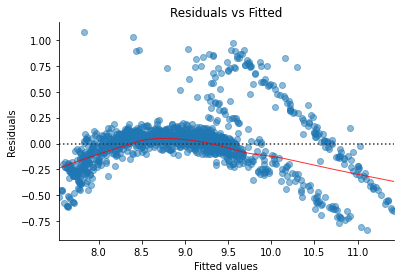

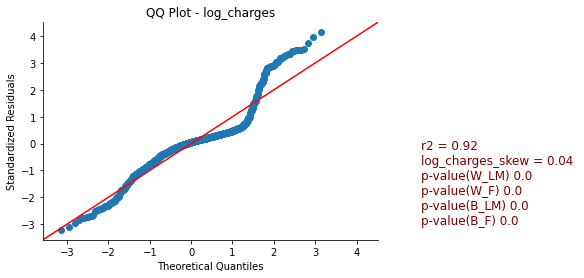

In [69]:
# Test model's linear assumption - full data, transformed target, influential points removed 
model_full_inf_free = reg_res_vis(df_full_inf_free, sub_feat, 'log_charges', res_plot = True, disp_res = True)

Better model but still suffering heteroscedasticity issue. Note size of smoker feature compared to others! 

##### Now try separate models.

**<a href="#toc" style='color:#00ffff'>Table of contents</a>**

<a id='sg'></a>

#### Modeling - Smokers group

In [70]:
# remove non-smoker group
ins_smk_df = ins_df[ins_df.smoker == 'yes']
ins_smk_df.head()

age     sex    bmi  children smoker     region     charges  log_charges  \
0    19  female  27.90         0    yes  southwest  16884.9240     9.734236   
11   62  female  26.29         0    yes  southeast  27808.7251    10.233141   
14   27    male  42.13         0    yes  southeast  39611.7577    10.586907   
19   30    male  35.30         0    yes  southwest  36837.4670    10.514298   
23   34  female  31.92         1    yes  northeast  37701.8768    10.537492   

    yj_charges  
0    12.121121  
11   12.891558  
14   13.448089  
19   13.333163  
23   13.369835

                            OLS Regression Results                            
Dep. Variable:                charges   R-squared:                       0.758
Model:                            OLS   Adj. R-squared:                  0.752
Method:                 Least Squares   F-statistic:                     119.0
Date:                Sat, 31 Dec 2022   Prob (F-statistic):           3.76e-78
Time:                        12:03:53   Log-Likelihood:                -2756.9
No. Observations:                 274   AIC:                             5530.
Df Residuals:                     266   BIC:                             5559.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept               

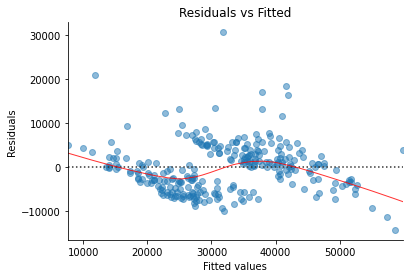

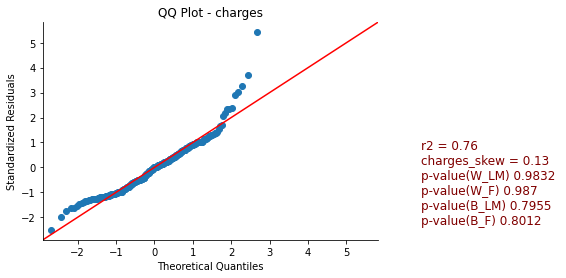

In [71]:
# modeling - smoker group, original target, all features

# model
model_smk_orig = reg_res_vis(ins_smk_df, list(feats.drop('smoker')), 'charges', res_plot = True, disp_res = True);

- Better model than full data, meeting regression assumptions. Note how Lowess curve fits the data.

- Only 'age' and 'bmi' have significant effect (p < 0.05)

In [72]:
# variance inflation factor - smoker group, original target, all features
target, features = dmatrices(model_smk_orig.model.formula, data = ins_smk_df, return_type='dataframe')

pd.Series([variance_inflation_factor(features.values, i) for i in range(features.shape[1])], index = features.columns)

Intercept                   33.615341
Q("sex")[T.male]             1.036182
Q("region")[T.northwest]     1.484226
Q("region")[T.southeast]     1.702349
Q("region")[T.southwest]     1.508400
Q("age")                     1.020644
Q("bmi")                     1.122908
Q("children")                1.024357
dtype: float64

VIF within threshold

In [73]:
# sequential ANOVA test - smoker group, original target, all features
sm.stats.anova_lm(model_smk_orig, typ = 1).round(4)

df        sum_sq       mean_sq         F  PR(>F)
Q("sex")         1.0  3.726279e+08  3.726279e+08   11.2584  0.0009
Q("region")      3.0  1.216535e+09  4.055118e+08   12.2519  0.0000
Q("age")         1.0  4.837155e+09  4.837155e+09  146.1469  0.0000
Q("bmi")         1.0  2.112332e+10  2.112332e+10  638.2076  0.0000
Q("children")    1.0  1.191457e+07  1.191457e+07    0.3600  0.5490
Residual       266.0  8.804039e+09  3.309789e+07       NaN     NaN

Only children appears to be insignificant, contrary to regression estimates.

In [74]:
# partial ANOVA test - smoker group, original target, all features
sm.stats.anova_lm(model_smk_orig, typ = 2).round(4)

sum_sq     df         F  PR(>F)
Q("sex")       9.701618e+06    1.0    0.2931  0.5887
Q("region")    1.463866e+08    3.0    1.4743  0.2219
Q("age")       3.707682e+09    1.0  112.0217  0.0000
Q("bmi")       2.113351e+10    1.0  638.5155  0.0000
Q("children")  1.191457e+07    1.0    0.3600  0.5490
Residual       8.804039e+09  266.0       NaN     NaN

Only 'age' and 'bmi' appears to be significant, in line with regression estimates.

In [75]:
# model selection - smoker group, original target
fmodel_selc_df = mod_sel(ins_smk_df, list(feats.drop('smoker')), 'charges', mse_resid = model_smk_orig.mse_resid)

fmodel_selc_df.sort_values(['cp', 'bic', 'aic', 'adj_r2'])[:10].style.format(fmt_log). \
apply(lambda x: ['background: purple' if x.cp <= x.p_plus_one * 2 else '' for i in x], axis = 1)

Fitting combos....: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  2.14it/s]


##### summary:
- 'age' and 'bmi' are the top influencers on smoker charges, model at index 6 seems to be good candidate (less features with best overall metrics); also, matches result of partial ANOVA.

                            OLS Regression Results                            
Dep. Variable:                charges   R-squared:                       0.753
Model:                            OLS   Adj. R-squared:                  0.751
Method:                 Least Squares   F-statistic:                     413.6
Date:                Sat, 31 Dec 2022   Prob (F-statistic):           4.50e-83
Time:                        12:04:00   Log-Likelihood:                -2759.5
No. Observations:                 274   AIC:                             5525.
Df Residuals:                     271   BIC:                             5536.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -2.237e+04   1931.856    -11.578      0.0

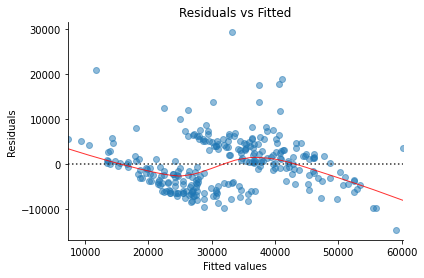

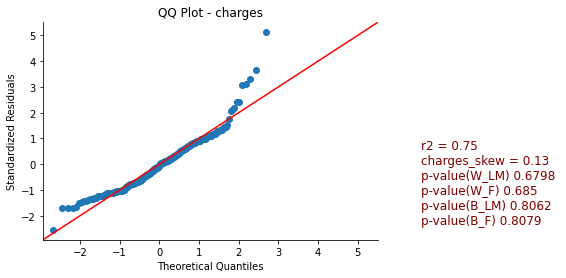

In [76]:
# Test model's linear assumption - smoker group, original target, best subset

sub_feat_smk = fmodel_selc_df.loc[6].feat.split(',')

model_smk_orig_bs = reg_res_vis(ins_smk_df, sub_feat_smk, 'charges', res_plot = True, disp_res = True)

Approximately normal residuals, no heteroscedasticity issue. Let's drop inf points.

In [77]:
# identify influential points - smoker group, original target, all features

# get index of influential points using cook distance & student residuals
cook_list, ext_list, c_e_inter, c_e_union = inf_points(ins_smk_df, model_smk_orig, alpha = 0.05)

In [78]:
# drop influential points - intersection
df_smk_inf_free = ins_smk_df.drop(c_e_inter)

df_smk_inf_free.head()

age     sex    bmi  children smoker     region     charges  log_charges  \
0    19  female  27.90         0    yes  southwest  16884.9240     9.734236   
11   62  female  26.29         0    yes  southeast  27808.7251    10.233141   
14   27    male  42.13         0    yes  southeast  39611.7577    10.586907   
19   30    male  35.30         0    yes  southwest  36837.4670    10.514298   
23   34  female  31.92         1    yes  northeast  37701.8768    10.537492   

    yj_charges  
0    12.121121  
11   12.891558  
14   13.448089  
19   13.333163  
23   13.369835

                            OLS Regression Results                            
Dep. Variable:                charges   R-squared:                       0.831
Model:                            OLS   Adj. R-squared:                  0.827
Method:                 Least Squares   F-statistic:                     179.5
Date:                Sat, 31 Dec 2022   Prob (F-statistic):           1.05e-94
Time:                        12:04:07   Log-Likelihood:                -2587.2
No. Observations:                 263   AIC:                             5190.
Df Residuals:                     255   BIC:                             5219.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept               

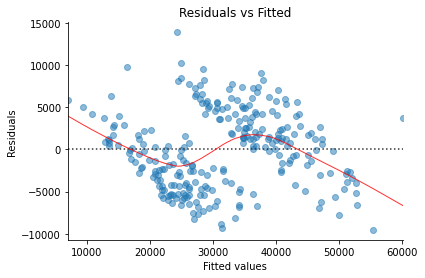

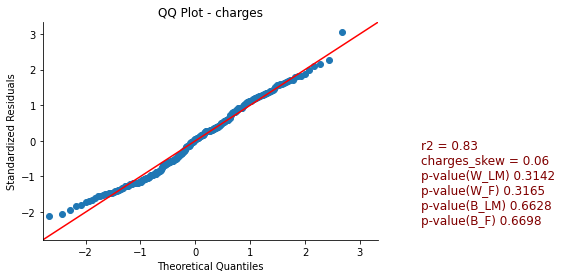

In [79]:
# model - smoker group, original target, all features, influential points removed
model_smk_org_inf_free = reg_res_vis(df_smk_inf_free, list(feats.drop('smoker')), 
                                      'charges', res_plot = True, disp_res = True);

Same conclusion as earlier with improved overall model.

In [80]:
# model selection - smoker group, original target, all features, influential points removed
fmodel_selc_df = mod_sel(df_smk_inf_free, list(feats.drop('smoker')), 
                         'charges', mse_resid = model_smk_org_inf_free.mse_resid)

fmodel_selc_df.sort_values(['cp', 'bic', 'aic', 'adj_r2'])[:10].style.format(fmt_log). \
apply(lambda x: ['background: purple' if x.cp <= x.p_plus_one * 2 else '' for i in x], axis = 1)

Fitting combos....: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  2.32it/s]


                            OLS Regression Results                            
Dep. Variable:                charges   R-squared:                       0.825
Model:                            OLS   Adj. R-squared:                  0.824
Method:                 Least Squares   F-statistic:                     612.3
Date:                Sat, 31 Dec 2022   Prob (F-statistic):           4.33e-99
Time:                        12:04:13   Log-Likelihood:                -2592.1
No. Observations:                 263   AIC:                             5190.
Df Residuals:                     260   BIC:                             5201.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -2.396e+04   1609.857    -14.884      0.0

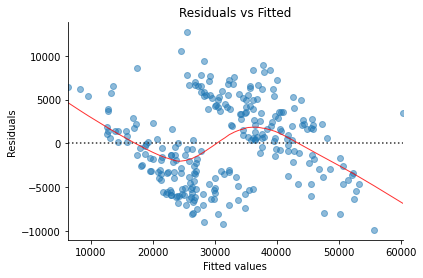

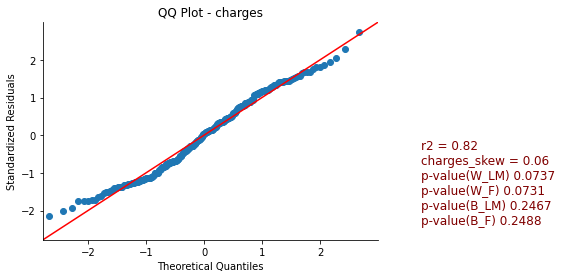

In [81]:
# Test model's linear assumption - smoker group, original target, influential points removed

sub_feat_smk = fmodel_selc_df.loc[6].feat.split(',')

model_smk_org_inf_free_bs = reg_res_vis(df_smk_inf_free, sub_feat_smk, 'charges', res_plot = True, disp_res = True)

##### Conclusion:

- using only two features 'age' and 'bmi' we obtained a decent linear model that explains variation in charges, however, we had to sacrifice about 4% of observations being influential points.

##### Next step is to try a nonlinear model.

In [82]:
# Non-linear model - smoker group

# One hot encoding
dv = DictVectorizer(sparse=False)

feats_ins_dict = ins_smk_df[feats.drop('smoker')].to_dict(orient = 'records')

feats_rf_df = pd.DataFrame(dv.fit_transform(feats_ins_dict), columns = dv.get_feature_names())

feats_rf_df.head()

age    bmi  children  region=northeast  region=northwest  \
0  19.0  27.90       0.0               0.0               0.0   
1  62.0  26.29       0.0               0.0               0.0   
2  27.0  42.13       0.0               0.0               0.0   
3  30.0  35.30       0.0               0.0               0.0   
4  34.0  31.92       1.0               1.0               0.0   

   region=southeast  region=southwest  sex=female  sex=male  
0               0.0               1.0         1.0       0.0  
1               1.0               0.0         1.0       0.0  
2               1.0               0.0         0.0       1.0  
3               0.0               1.0         0.0       1.0  
4               0.0               0.0         1.0       0.0

r2:  0.88


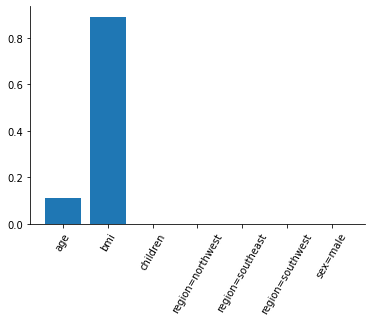

In [83]:
# RandomForestRegressor - smoker group, full data, original target

# drop one categorical level
feats_rf = feats_rf_df.drop(['region=northeast', 'sex=female'], axis = 1)

# fir model
rfr = RandomForestRegressor(max_depth = 2, random_state = 1)

rfr.fit(feats_rf, ins_smk_df.charges)

print('r2: ', rfr.score(feats_rf, ins_smk_df.charges).round(2))

# feature importance
f_impt = dict(zip(feats_rf, rfr.feature_importances_.round(4)))

# plot
plt.bar(f_impt.keys(), f_impt.values())
plt.gca().spines[['top', 'right']].set_visible(False)
plt.xticks(rotation = 60);

- Comparing base models (without removing influential points), the non-linear model scores higher linear regression in terms of r2 .88 vs .75 respectively.

- Both models agree on feature importance being 'age' and 'bmi' for smoker group.

**<a href="#toc" style='color:#00ffff'>Table of contents</a>**

<a id='nsg'></a>

#### Modeling - Non-Smokers group

Our initial model using numeric feats only and removing influential points had r2 score of 93, this is the score we'll try to beat with categorical; or maybe we'll get a better overall model.

                            OLS Regression Results                            
Dep. Variable:            log_charges   R-squared:                       0.933
Model:                            OLS   Adj. R-squared:                  0.933
Method:                 Least Squares   F-statistic:                     4610.
Date:                Sat, 31 Dec 2022   Prob (F-statistic):               0.00
Time:                        12:04:19   Log-Likelihood:                 284.03
No. Observations:                 997   AIC:                            -560.1
Df Residuals:                     993   BIC:                            -540.4
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         6.7833      0.032    208.738

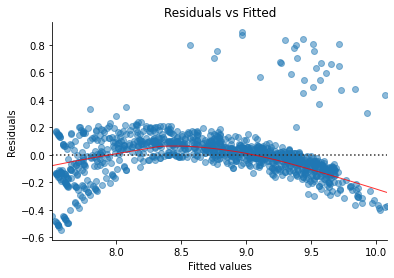

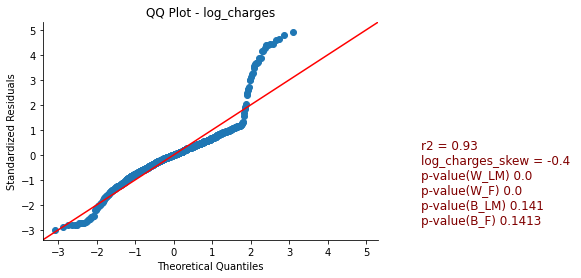

In [84]:
# baseline model - nsmoker group, inf points dropped (studentized), transformed target
reg_res_vis(df_nsmk_inf_free, ['age', 'bmi', 'children'], 'log_charges', res_plot = True, disp_res = True)

                            OLS Regression Results                            
Dep. Variable:            log_charges   R-squared:                       0.690
Model:                            OLS   Adj. R-squared:                  0.688
Method:                 Least Squares   F-statistic:                     335.2
Date:                Sat, 31 Dec 2022   Prob (F-statistic):          3.76e-263
Time:                        12:04:25   Log-Likelihood:                -572.24
No. Observations:                1064   AIC:                             1160.
Df Residuals:                    1056   BIC:                             1200.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept               

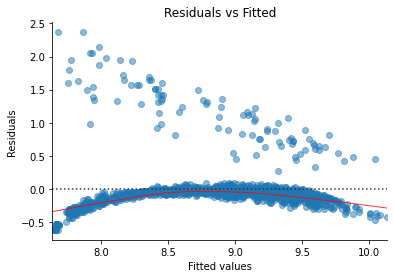

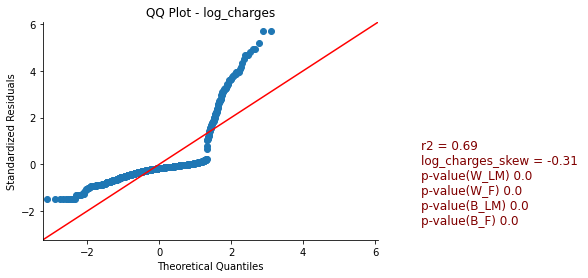

In [85]:
# modeling - nsmoker group, transformed target, all features

# model
model_nsmk_trns = reg_res_vis(ins_nosmk_df, list(feats.drop('smoker')), 'log_charges', res_plot = True, disp_res = True);

In [86]:
# identify influential points - nsmoker group, transformed target, all features

# get index of influential points using cook distance & student residuals
cook_list, ext_list, c_e_inter, c_e_union = inf_points(ins_nosmk_df, model_nsmk_trns, alpha = 0.05)

In [87]:
# drop influential points - studentized
df_nsmk_inf_free = ins_nosmk_df.drop(ext_list)

df_nsmk_inf_free.head()

age     sex    bmi  children smoker     region    charges  log_charges  \
1   18    male  33.77         1     no  southeast  1725.5523     7.453882   
2   28    male  33.00         3     no  southeast  4449.4620     8.400763   
4   32    male  28.88         0     no  northwest  3866.8552     8.260455   
5   31  female  25.74         0     no  southeast  3756.6216     8.231541   
6   46  female  33.44         1     no  southeast  8240.5896     9.016949   

   yj_charges  
1    8.805045  
2   10.142157  
4    9.940531  
5    9.899133  
6   11.042355

                            OLS Regression Results                            
Dep. Variable:            log_charges   R-squared:                       0.946
Model:                            OLS   Adj. R-squared:                  0.946
Method:                 Least Squares   F-statistic:                     2491.
Date:                Sat, 31 Dec 2022   Prob (F-statistic):               0.00
Time:                        12:04:45   Log-Likelihood:                 396.85
No. Observations:                 995   AIC:                            -777.7
Df Residuals:                     987   BIC:                            -738.5
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept               

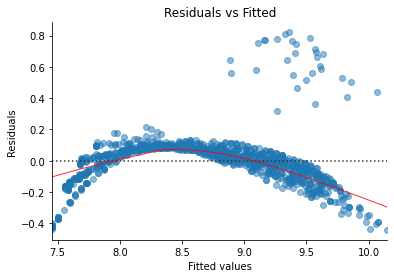

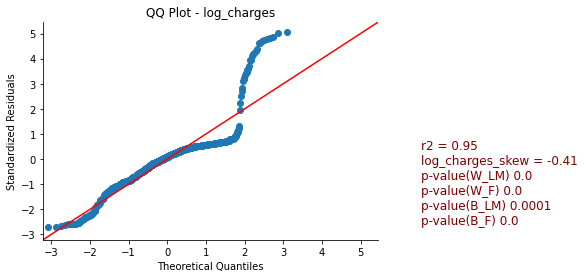

In [88]:
# model - nsmoker group, transformed target, all features, influential points removed
model_nsmk_trns_inf_free = reg_res_vis(df_nsmk_inf_free, list(feats.drop('smoker')), 
                                      'log_charges', res_plot = True, disp_res = True);

Earlier model with numeric features only is better in terms of linear model assumptions.

**<a href="#toc" style='color:#00ffff'>Table of contents</a>**

<a id='ms'></a>

### Modeling Summary:

We've done our EDA using a mix of uni, bi and multivariate analysis; then moved to modeling following a brute force approach where we tried every possible combination of features and selected best subset based on an assessment of several metrics and observations noted during EDA.

It turned out that for this particular dataset, having two models for each smoker groups (smoker and non-smoker) is best approach; results of models can be summarized as follows:

##### Full data (smokers and non-smokers):
- Untransformed charges and using all features
    1. adjusted r2: 75
    2. number of observations: 1338
    3. number of features used (degree of freedom - model): 8
    4. Significant features: smoker, region, age, bmi, children
    5. Normality and homoscedasticity assumptions are violated
- Transformed charges (log) and using all features
    1. adjusted r2: 77
    2. Same observations (2 to 5) as previous model. 
- Transformed charges (log), using all features and removing influential points
    1. adjusted r2: 92
    2. number of observations: 1227 (8% of observations removed)
    3. number of features used (degree of freedom - model): 8
    4. Significant features: smoker, region, age, bmi, children
    5. Homoscedasticity assumption is violated
- Nonlinear model
    - Not attempted
        
##### Smoker group:
- Untransformed charges and using all features
    1. adjusted r2: 76
    2. number of observations: 274
    3. number of features used (degree of freedom - model): 7
    4. Significant features: age, bmi
    5. Normality and homoscedasticity assumptions are not violated
    6. Best subset - Brute force: 
          - adjusted r2: 75
          - number of features used (degree of freedom - model): 2
          - Significant features: age, bmi
          - Normality and homoscedasticity assumptions are not violated
- Untransformed charges, using all features and removing influential points
    1. adjusted r2: 83
    2. number of observations: 263 (4% of observations removed)
    3. Same observations (3 to 6) as previous model.
- Nonlinear model (RandomForestRegressor), untransformed charges, using all features
    1. r2: 88
    2. number of observations: 274
    3. number of features used (degree of freedom - model): 7
    4. Significant features: age, bmi
        
##### Non-Smoker group:
- Transformed charges and using numeric features only
    1. adjusted r2: 68
    2. number of observations: 1064
    3. number of features used (degree of freedom - model): 3
    4. Significant features: age, children
    5. Normality and homoscedasticity assumptions are violated
- Transformed charges, using numeric features only and removing influential points
    1. adjusted r2: 93
    2. number of observations: 997 (6% of observations removed)
    3. number of features used (degree of freedom - model): 3
    4. Significant features: age, children, bmi
    5. Normality and homoscedasticity assumptions are not violated
- Transformed charges, using all features and removing influential points
    1. adjusted r2: 93
    2. number of observations: 1003 (5% of observations removed)
    3. number of features used (degree of freedom - model): 7
    4. Significant features: sex, region, age, children
    5. Normality and homoscedasticity assumptions are violated
- Nonlinear model
    - Not attempted

##### Conclusion:

- There are clearly some missing features that explains variation in charges, especially for non-smokers group. We've shown some examples of identical samples (feature wise) with different charge values.

- For smoker group, simple non-linear model out performed (expected!) ols, both agree on feature importance being 'age' and 'bmi'

- For non-smoker group, using only numeric features ('age', 'children', 'bmi') generated a decent ols model that comply with linear assumptions.

- 'smoker', 'age' and 'bmi' are the most significant predictors for medical charges.

Our evaluation was based on same data used in training the model and ignoring linear models that violate linear regression assumptions, we are focused on exploring the dataset and understanding the patterns within rather than measuring out of sample performance.

##### Let's automate parts of EDA that maybe helpful in spotting patterns quick and dirty!

**<a href="#toc" style='color:#00ffff'>Table of contents</a>**

<a id='auto'></a>

### Automation

Approaching a new dataset with ease! Below is a list of all functions used throughout our analysis along with couple new ones to be coded next:

##### EDA

1. sneak_peek(main dataframe, y):
    - **Description:** Calculate univariate statistics (mean, median, count, frequency....), skew, kurtosis, duplicated observations (feature wise), missing values, high cardinality features then plot numeric distributions (histograms).
    - **Returns:** Dataframe - univariate statistics
2. corr(main dataframe, y, numeric columns):
    - **Description:** Calculate Pearson (linear) and Spearman (monotonic) correlation coefficient then plot correlation heat map
    - **Returns:** Dataframe - correlation
3. jplt(main dataframe, y, numeric columns):
    - **Description:** Scatter plots of numeric features and target while visualize trend lines; assessing residuals homoscedasticity assumption statistically.
    - **Returns:** Dataframe - residuals and predictions
4. resid_plot(residuals dataframe, y, numeric columns):
    - **Description:** plot residuals vs predictions (fitted values) and Lowess curve; assessing residuals homoscedasticity assumption visually.
    - **Returns:** residuals plots
5. qq_plt(residuals dataframe, numeric columns)
    - **Description:** Quantile-Quantile(QQ) probability plots and histograms of residuals; assessing residuals normality assumption visually.
    - **Returns:** QQ plots and histograms - residuals
6. cat_analysis(main dataframe, y, categorical columns)
    - **Description:** Parametric and Nonparametric tests on categorical features excluding those with null values and few samples within any group (below 4)
    - **Returns:** Dataframe - One-way ANOVA and Multi comparison tests; plots of group means
7. multi_reg_vis(main dataframe, y, numeric columns, categorical feature)
    - **Description:** Multivariate visualization of a selected numeric and categorical features
    - **Returns:** scatter plot, trend line and r2.

##### Modeling - ols

8. reg_res_vis(dataframe, columns to regress, y)
    - **Description:** fit linear model (ols) and display results
    - **Returns:** model, fit summary, residuals and QQ plots.
9. mod_sel(dataframe, columns to regress, y, mean squared errors of full model)
    - **Description:** brute force model selection - assessing every possible feature combination of different subsets.
    - **Returns:** summary dataframe of all feature combination along with several metrics (Mallows's Cp, AIC and BIC)
10. inf_points(dataframe, model)
    - **Description:** identify influential points based on Cook’s Distance and Studentized Residuals estimates 
    - **Returns:** 4 lists (Cook's D, Studentized residuals, union of observations from both methods and intersection of observations from both methods)

##### Some of these functions  were introduced earlier, let's code new ones and start our analysis from scratch!

In [89]:
# Univariate analysis

def sneak_peek(df, y, col_drop = None, bins = 30, figsize = (15,3)):
    
    '''
    buff up describe function, group everything in one place
    '''

    univ_stat_df = df.describe(include = 'all').T

    univ_stat_df['d_types'] = df.dtypes

    # calculate skew, kurt and normality for numeric features only
    cols = univ_stat_df[~(univ_stat_df.d_types == 'object')].index

    for col in cols:
        # skew
        univ_stat_df.loc[col, 'skw'] = df[col].skew().round(2) 
        
        # test normality assumption (null: data is normal)
        p_n = stats.normaltest(df[col], nan_policy = 'omit').pvalue
        # accept/reject null (i.e.: reject if p-val < 0.05, data is not normal)
        univ_stat_df.loc[col, 'non_nrml'] = [f'False ({p_n.round(4)})' if p_n > 0.05 else f'True ({p_n.round(4)})'][0]
        
        # kurtosis
        univ_stat_df.loc[col, 'kurt'] = df[col].kurt().round(2)
        
    # duplicate samples across all features except target 
    if col_drop: # if user passed several columns to drop other than targets (example, ID column)
        assert type(col_drop) == list, 'Please pass columns to drop as a list.'
        cols = np.r_[col_drop, [y]]
    else:
        cols = y
    # check duplicates
    if len(df[df[df.columns.drop(cols)].duplicated(keep=False)].index) == 0:
        dup_sample = None
    else:
        dup_sample = df[df[df.columns.drop(cols)].duplicated(keep=False)].T
            
    # display results
    cat_cols = df.select_dtypes('object').columns

    display('**Missing values**', df.isnull().sum()[df.isnull().sum() > 0].sort_values(ascending = False).to_frame().T, 
            '**High Cardinality Categorical features (>=10)**', 
            df[cat_cols].nunique()[df[cat_cols].nunique() >= 10].sort_values(ascending = False).to_frame().T,
            '**Identical observations across all features**', dup_sample,
            '**Univariate stats**', univ_stat_df.T)
        
    # Visualize skewed data
    
    # sorted skewness
    skewed_feats = univ_stat_df[univ_stat_df.skw > 1].sort_values('skw', ascending=False).index
    
    fig = plt.figure(figsize = figsize)

    for i, v  in enumerate(skewed_feats):
        fig.add_subplot(int(np.ceil(len(skewed_feats)/4)), 4, i+1)
        sns.histplot(x = df[v], bins = bins, color = 'maroon', kde = True)
        plt.title(v)
        plt.gca().spines[['top', 'right']].set_visible(False)
        plt.tight_layout()
        plt.xticks(rotation = 90);

    return univ_stat_df

In [176]:
# assessing bivariate relationship (numeric features)

def jplt(df, y, num_cols):
    """
    Bivariate relationship - numeric features
    """
    assert type(num_cols) == list, 'please pass columns as a list'
    
    # collect fit results
    results = {f'{y}': df[y]}
    
    cols = []
    
    for col in num_cols:
        if df[col].isnull().sum() == 0:
            # fit model
            # Q("{col}")' controls column names having numbers and spaces
            model = ols(formula = f'{y}~Q("{col}")', data = df).fit()
            
            # update results
            results.update({f'{col}_pred': model.fittedvalues, f'{col}_resid': model.resid, f'{col}_abs_resid': np.abs(model.resid)})
            
            # non-null cols for next function
            cols.append(col)
            
            # heteroscedasticity test
            try:
                # model.model.exog -- > feature +  intercept
                white_test = het_white(model.resid, model.model.exog)
                bpgn_test = het_breuschpagan(model.resid, model.model.exog)
                
                # adding stats to plot
                text = f'y = {model.params[0].round()} + {model.params[1].round()}x \n' + f'r2 = {model.rsquared.round(2)} \n' + \
                f'p = {model.pvalues[1].round(4)} \n' + f'{col}_skew = {df[col].skew().round(2)} \n' + \
                f'{y}_skew = {df[y].skew().round(2)} \n' + f'p-value(W_LM) {white_test[1].round(4)} \n' + \
                f'p-value(W_F) {white_test[3].round(4)} \n' + f'p-value(B_LM) {bpgn_test[1].round(4)} \n' + \
                f'p-value(B_F) {bpgn_test[3].round(4)}'
                
            except:
                bpgn_test = het_breuschpagan(model.resid, model.model.exog)
                
                # adding stats to plot
                text = f'y = {model.params[0].round()} + {model.params[1].round()}x \n' + f'r2 = {model.rsquared.round(2)} \n' + \
                f'p = {model.pvalues[1].round(4)} \n' + f'{col}_skew = {df[col].skew().round(2)} \n' + \
                f'{y}_skew = {df[y].skew().round(2)} \n' + f'p-value(B_LM) {bpgn_test[1].round(4)} \n' + \
                f'p-value(B_F) {bpgn_test[3].round(4)}'

            # plot
            ax = sns.jointplot(x = df[col], y = df[y], kind = 'reg', 
                               joint_kws = {'scatter_kws':{'color':'crimson'}, 'line_kws':{'color':'purple'}}, 
                               marginal_kws={'color': 'purple'})
            ax.fig.text(1, 0.116, text, verticalalignment = 'bottom', horizontalalignment = 'left', 
                        transform = plt.gcf().transFigure, color = 'maroon', fontsize = 12)
            ax.ax_joint.get_lines()[0].set_color('maroon') # give line different color, but confidence interval color remain as in line_kws
            plt.show()
    
    resid_df = pd.DataFrame(results)
    
    return resid_df, cols

In [91]:
# Residuals equal variance (homoscedasticity) - visual inspection

def resid_plot(df, y, cols, lowess = False, anot = 3, figsize = (15,3)):
    '''
    plot residuals vs fitted values from single feature fits
    '''
    assert type(cols) == list, 'please pass columns as a list'
    
    fig = plt.figure(constrained_layout = True, figsize = figsize)

    for i, col in enumerate(cols):
        fig.add_subplot(int(np.ceil(len(cols)/4)), 4, i+1)

        ax = sns.residplot(x = df[f'{col}_pred'], y = df[y], lowess = lowess, scatter_kws={'alpha': 0.5}, 
                                  line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8})
        ax.set_title(f'Residuals vs Fitted - {col}')
        ax.set_xlabel('Fitted values')
        ax.set_ylabel('Residuals')
        plt.gca().spines[['top', 'right']].set_visible(False)

        # annotations - highest residuals
        abs_resid = df[f'{col}_abs_resid'].sort_values(ascending=False)
        abs_resid_top_n = abs_resid.iloc[:anot]
        for i in abs_resid_top_n.index:
            ax.annotate(i, xy = (df[f'{col}_pred'][i], df[f'{col}_resid'][i]));

In [92]:
# Residuals normality  - visual inspection

def qq_plt(df, cols):
    """
    assessing normality of residuals assumption through visual inspection
    """
    assert type(cols) == list, 'please pass columns as a list'
    
    for col in cols:
        
        # Residuals Plots
        # QQ plot
        sm.qqplot(df[f'{col}_resid'], fit = True, line='45')
        plt.title(f'{col} - QQ Plot')
        plt.xlabel("Theoretical Quantiles")
        plt.ylabel("Standardized Residuals")
        plt.gca().spines[['top', 'right']].set_visible(False)
        plt.show()
        
        # Histogram
        sns.histplot(df[f'{col}_resid'], kde = True, color = 'maroon')
        plt.title(f'{col} - Residuals Histogram')
        plt.gca().spines[['top', 'right']].set_visible(False)
        plt.xticks(rotation = 90);

In [93]:
# assessing bivariate relationship (categorical features)

def cat_analysis(df, y, cat_cols, visualize = True, figsize = (15,3)):
    """ 
    Parametric (One-way ANOVA, t-test) and Nonparametric (Kruskal-Wallis H, Mann–Whitney U‑test) 
    tests on categorical features excluding those with null values
    """

    assert type(cat_cols) == list, 'please pass columns as a list'
    
    sample_stat = []
    anova_summary = []
    tuk_corrc = []
    t_tests = []
    bonfer_corrc = []

    for col in cat_cols:
        
        # Significance test for features with more than two groups (levels)
        # and minimum 4 sample size for each group
        # execlude features with null values
        if (df[col].isnull().sum() == 0) and (df[col].nunique() >= 2) and (np.all((df[col].value_counts() >= 4).values)):
                
            # Assessing impact on ANOVA assumptions
            # ANOVA is fairly robust to minor violations when the group size is equal
            sample_stat.append((df[col].value_counts().min(), 
                               df[col].value_counts().max(), 
                               round(df[col].value_counts().std()), 
                                df[col].nunique()))

            # groups to analyze
            groups = [df[y][df[col] == g] for g in df[col].unique()]

            # One-way ANOVA
            f, p_f = stats.f_oneway(*groups)

            # Kruskal-Wallis H (non-parametric equivalent of the One-Way ANOVA)
            h, p_h = stats.kruskal(*groups)

            # Checking Homogeneity of variances
            # assuming data is not normally distributed
            p_v = stats.levene(*groups).pvalue

            # assuming data is normally distributed
            p_b = stats.bartlett(*groups).pvalue

            acc_rej_lev = [f'True ({p_v.round(4)})' if  p_v > 0.05 else f'False ({p_v.round(4)})'][0]
            acc_rej_bar = [f'True ({p_b.round(4)})' if  p_b > 0.05 else f'False ({p_b.round(4)})'][0]

            # update results
            anova_summary.append((col, acc_rej_lev, acc_rej_bar, round(f,2), round(p_f,4), round(h,2), round(p_h,4)))
            
            if len(df[col].unique()) > 2: # run post hoc, if more that two groups
                
                # post-hoc TukeyHSD
                # if the sample sizes of groups are unequal, Tukey-Kramer procedure is automatically used
                mc = MultiComparison(df[y], df[col])

                tuk_corrc.append((col, mc.tukeyhsd()))

                # post-hoc Bonferroni
                for i in combinations(df[col].unique(), 2):

                    # test equal varaince assumption (null: both groups have equal variance)
                    # assuming normal distribution
                    p_v_t = stats.levene(df[y][df[col] == i[0]], df[y][df[col] == i[1]]).pvalue
                    # accept/reject null (i.e.: reject if p-val < 0.05, groups do not have equal variance)
                    acc_rej = [f'True ({p_v.round(4)})' if  p_v_t > 0.05 else f'False ({p_v.round(4)})'][0]

                    if p_v > 0.05: # select test based on equal variance analysis
                        # t-test
                        t, p_t = stats.ttest_ind(df[y][df[col] == i[0]], df[y][df[col] == i[1]])
                    else:
                        # Welch's t-test (assuming no-qual variance)
                        t, p_t = stats.ttest_ind(df[y][df[col] == i[0]], df[y][df[col] == i[1]], equal_var = False)

                    # Mann–Whitney U test (Nonparametric version of two-sided t-test)
                    p_mw = stats.mannwhitneyu(df[y][df[col] == i[0]], df[y][df[col] == i[1]]).pvalue

                    t_tests.append((col, acc_rej, i[0], i[1], round(t,2), round(p_t,4), round(p_mw,4)))

                # adjusted p-val for post-hoc (Bonferroni)
                # desired Familywise error rate (FWER) after all comparisons are made is .05
                n_grps = len(Counter(combinations(df[col].unique(),2)))
                fwer = 0.05 / n_grps
                bonfer_corrc.append((col, n_grps, fwer))

   # ANOVA/Krus dataframe
    anova_df = pd.DataFrame(np.column_stack([anova_summary, sample_stat]), 
                            columns = ['feature', 'eq_var(lev)', 'eq_var(bart)', 'f_stat', 'p_val(f)', 
                                       'h_stat', 'p_val(h)',  'min_smpl', 'max_smpl', 'smpl_std', 'n_grps'])
                            
    anova_df[anova_df.columns[3:]] = anova_df[anova_df.columns[3:]].astype(float) 

    # t-test dataframe
    t_tst_df = pd.DataFrame(t_tests, columns = ['feature', 'equl_v_lev', 'group_one', 'group_two', 't_stat', 'p_val_t', 
                                                  'p_val_mw'])
    # Bonferroni dataframe
    bonfer_df = pd.DataFrame(columns = np.r_[t_tst_df.columns, ['adj-thrsh']])

    for thrsh in bonfer_corrc:
        idx_bon = len(bonfer_df.index) # capture current idx to add adjusted significance threshold sequentially
        bonfer_df = pd.concat([bonfer_df, t_tst_df[(t_tst_df.feature == thrsh[0]) & 
                                                   (t_tst_df.p_val_t <= thrsh[2])]], ignore_index = True)
        if len(bonfer_df.index) > idx_bon: # update adj-thresh only if non-empty dataframe
            bonfer_df.loc[bonfer_df.index[idx_bon:], 'adj-thrsh'] = round(thrsh[2], 4)
        
    # TukeyHSD dataframe
    tuk_df = pd.DataFrame()

    for i,v in tuk_corrc:
        idx_tuk = len(tuk_df.index) # capture current idx to add feature name sequentially
        feat_df = pd.DataFrame(v.summary()[1:])
        tuk_df = pd.concat([tuk_df, feat_df], ignore_index = True)
        if len(tuk_df.index) > idx_tuk: # update feature name only if non-empty dataframe
            tuk_df.loc[tuk_df.index[idx_tuk:], 'feature'] = i

    tuk_df.columns = ['group1', 'group2', 'meandiff', 'p-adj', 'lower', 'upper', 'reject', 'feature']
    tuk_df = tuk_df.astype(str)

    # display results
    display('**Excluded Features**', ', '.join([f for f in cat_cols if np.any((df[f].value_counts() < 4).values)]),
            '**One-way ANOVA / Kruskal-Wallis H**',
            # .astype(object).T to preserve desired rounding as transpose resets decimal rounding
            anova_df.sort_values('f_stat', ascending = False).set_index('feature').rename_axis(None).astype(object).T,
            '**t-test / Mann–Whitney U test**', 
            t_tst_df.sort_values(['feature', 't_stat']).set_index('feature').rename_axis(None).T,
            '**Post-hoc (TukeyHSD)**', 
            tuk_df[tuk_df.reject == 'True'].sort_values(['feature', 'p-adj']).set_index('feature').\
            rename_axis(None)[['group1', 'group2', 'p-adj', 'reject']].T,
            '**Post-hoc (Bonferroni)**', 
            bonfer_df.sort_values(['feature', 't_stat']).set_index('feature').\
            rename_axis(None)[['group_one', 'group_two', 'adj-thrsh']].T)

    if visualize:

        fig = plt.figure(constrained_layout=True, figsize = figsize)

        for i, col in enumerate(cat_cols):
            fig.add_subplot(int(np.ceil(len(cat_cols) / 4)), 4, i + 1)
                        
            # sorting the plot
            order = df.groupby(col)[y].mean().sort_values().index

            # plot
#             sns.violinplot(x = df[col], y = df[y], palette = 'Paired', inner = 'quartile', order = order)
            sns.barplot(x = df[col], y = df[y], palette = 'Paired', order = order)
#             sns.boxplot(x = df[col], y = df[y], palette = 'Paired', order = order)

#             # show group means         
#             sns.pointplot(x = df[col], y = df[y], order = order, color = 'maroon', errorbar = None, seed = 1, linestyles = ':')

            plt.gca().spines[['top', 'right']].set_visible(False)
            plt.xticks(rotation = 90);

    return anova_df, t_tst_df, bonfer_df, tuk_df

**<a href="#toc" style='color:#00ffff'>Table of contents</a>**

<a id='scra'></a>

##### Starting from scratch - using helper functions 

'**Missing values**'

Empty DataFrame
Columns: []
Index: [0]

'**High Cardinality Categorical features (>=10)**'

Empty DataFrame
Columns: []
Index: [0]

'**Identical observations across all features**'

195        581
age                 19         19
sex               male       male
bmi              30.59      30.59
children             0          0
smoker              no         no
region       northwest  northwest
charges      1639.5631  1639.5631
log_charges   7.402795   7.402795
yj_charges    8.734459   8.734459

'**Univariate stats**'

age     sex            bmi    children  smoker     region  \
count         1338.0    1338         1338.0      1338.0    1338       1338   
unique           NaN       2            NaN         NaN       2          4   
top              NaN    male            NaN         NaN      no  southeast   
freq             NaN     676            NaN         NaN    1064        364   
mean       39.207025     NaN      30.663397    1.094918     NaN        NaN   
std         14.04996     NaN       6.098187    1.205493     NaN        NaN   
min             18.0     NaN          15.96         0.0     NaN        NaN   
25%             27.0     NaN       26.29625         0.0     NaN        NaN   
50%             39.0     NaN           30.4         1.0     NaN        NaN   
75%             51.0     NaN       34.69375         2.0     NaN        NaN   
max             64.0     NaN          53.13         5.0     NaN        NaN   
d_types        int64  object        float64       int64  object     object   
skw             0.06     NaN           0.28        0.94     NaN        NaN   
non_nrml  True (0.0)     NaN  True (0.0002)  True (0.0)     NaN        NaN   
kurt           -1.25     NaN          -0.05         0.2     NaN        NaN   

               charges log_charges  yj_charges  
count           1338.0      1338.0      1338.0  
unique             NaN         NaN         NaN  
top                NaN         NaN         NaN  
freq               NaN         NaN         NaN  
mean      13270.422265    9.098828   11.191089  
std       12110.011237    0.919379    1.364867  
min          1121.8739    7.023647    8.215471  
25%         4740.28715    8.464064   10.233525  
50%           9382.033    9.146658   11.234946  
75%       16639.912515    9.719618   12.098799  
max        63770.42801   11.063061   14.210813  
d_types        float64     float64     float64  
skw               1.52       -0.09       -0.01  
non_nrml    True (0.0)  True (0.0)  True (0.0)  
kurt              1.61       -0.64       -0.65

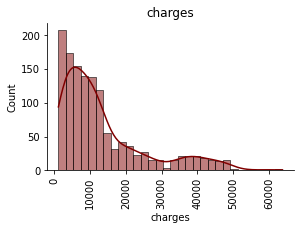

In [94]:
# Univariate statistics

univ_stat_df = sneak_peek(ins_df, 'charges')

age    bmi  children
r_pear         0.299  0.198     0.068
p_val(r_pear)  0.000  0.000     0.013
r_spr          0.534  0.119     0.133
p_val(r_spr)   0.000  0.000     0.000

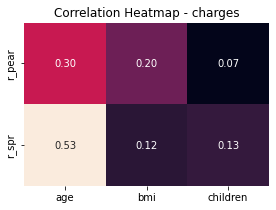

In [95]:
# correlation
corr_df = corr(ins_df, 'charges', list(num_cols_ins.drop('charges')))
corr_df

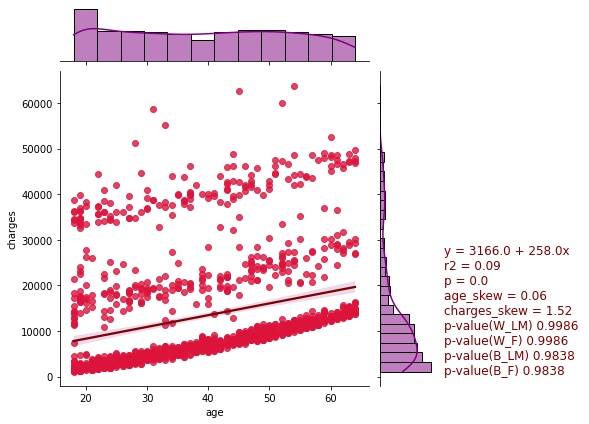

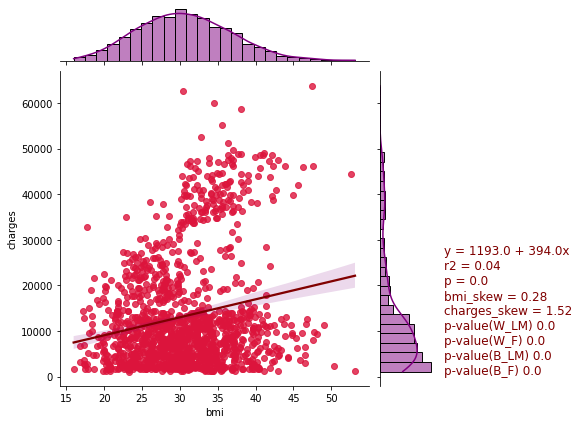

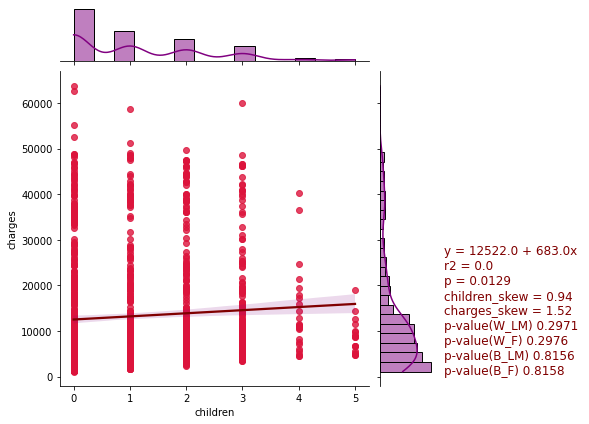

In [177]:
# Bivariate analysis - numeric features
resid_df, cols = jplt(ins_df, 'charges', list(num_cols_ins.drop('charges')))

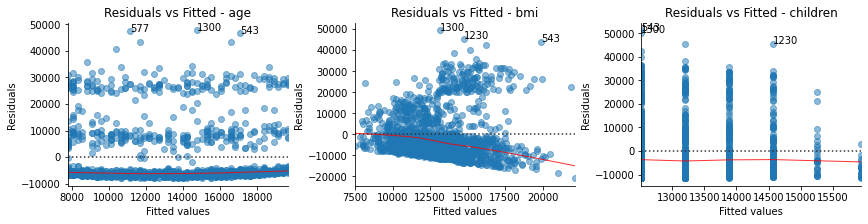

In [178]:
# Homoscedasticity, residuals vs fitted values - single feature fit
resid_plot(resid_df, 'charges', cols, lowess = True)

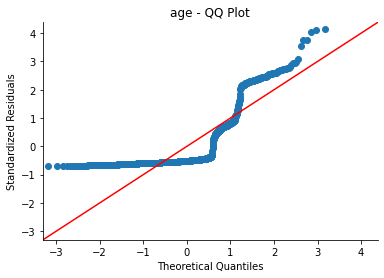

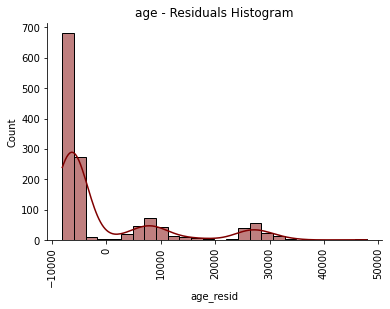

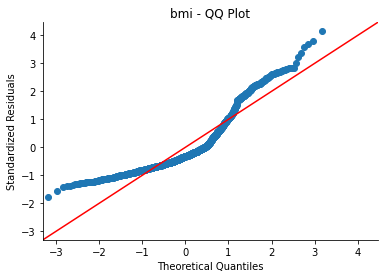

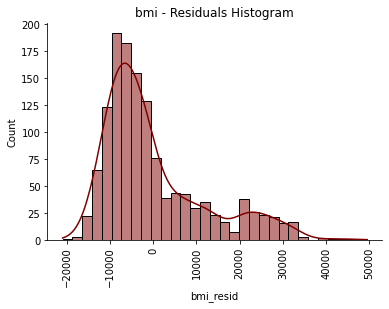

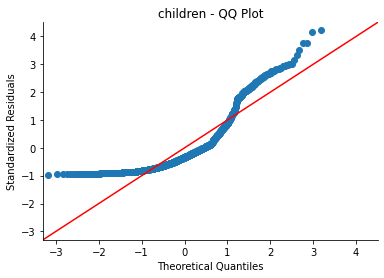

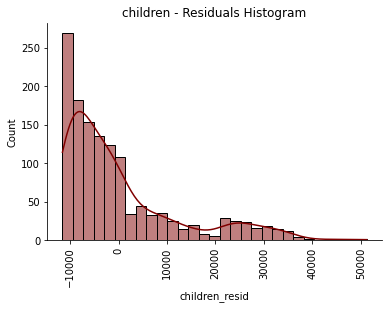

In [98]:
# Residual normality - single feature fit
qq_plt(resid_df, list(num_cols_ins.drop('charges')))

'**Excluded Features**'

''

'**One-way ANOVA / Kruskal-Wallis H**'

smoker             sex          region
eq_var(lev)   False (0.0)  False (0.0017)  False (0.0009)
eq_var(bart)  False (0.0)  False (0.0001)     False (0.0)
f_stat            2177.61             4.4            2.97
p_val(f)              0.0          0.0361          0.0309
h_stat             588.52            0.12            4.73
p_val(h)              0.0          0.7286          0.1923
min_smpl            274.0           662.0           324.0
max_smpl           1064.0           676.0           364.0
smpl_std            559.0            10.0            20.0
n_grps                2.0             2.0             4.0

'**t-test / Mann–Whitney U test**'

region         region         region         region  \
equl_v_lev  False (0.0009)  True (0.0009)  True (0.0009)  True (0.0009)   
group_one        southwest      southwest      northwest      southwest   
group_two        southeast      northeast      northeast      northwest   
t_stat               -2.45          -1.18          -1.13          -0.08   
p_val_t             0.0144         0.2372         0.2597         0.9366   
p_val_mw             0.211         0.0375         0.1154         0.6297   

                    region          region  
equl_v_lev  False (0.0009)  False (0.0009)  
group_one        southeast       southeast  
group_two        northeast       northwest  
t_stat                1.38            2.43  
p_val_t              0.168          0.0156  
p_val_mw            0.5699          0.4014

'**Post-hoc (TukeyHSD)**'

region
group1  southeast
group2  southwest
p-adj      0.0477
reject       True

'**Post-hoc (Bonferroni)**'

Empty DataFrame
Columns: []
Index: [group_one, group_two, adj-thrsh]

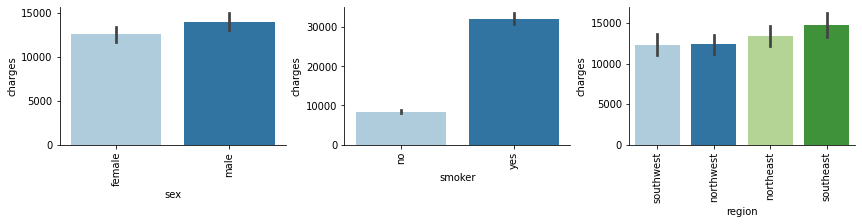

In [99]:
# Bivariate analysis - categorical features
anova_df, t_tst_df, bonfer_df, tuk_df = cat_analysis(ins_df, 'charges', list(cat_cols_ins))

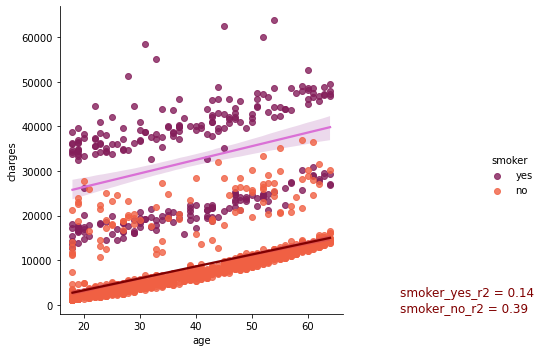

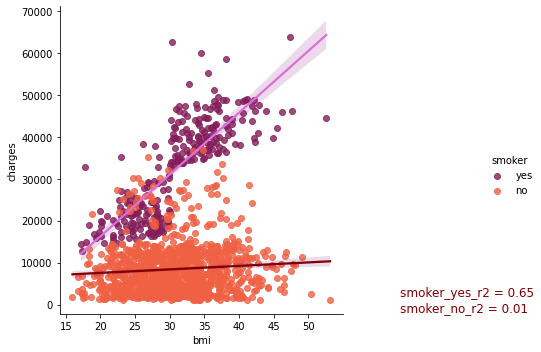

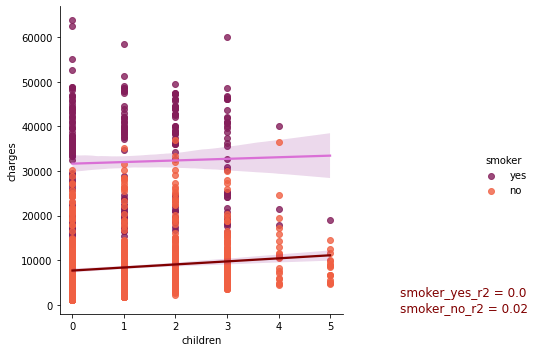

In [159]:
# Multivariate analysis - trend line
multi_reg_vis(ins_df, 'charges', list(num_cols_ins.drop('charges')), 'smoker')

##### Neat! But the dataset is small with few features; let's test on a bigger dataset!

**<a href="#toc" style='color:#00ffff'>Table of contents</a>**

<a id='hp'></a>

#### House Price Dataset

In [101]:
# House price dataset
hp_df = pd.read_csv('train_HousePrice.csv')

print(hp_df.shape)

hp_df.head()

(1460, 81)


Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0   1          60       RL         65.0     8450   Pave   NaN      Reg   
1   2          20       RL         80.0     9600   Pave   NaN      Reg   
2   3          60       RL         68.0    11250   Pave   NaN      IR1   
3   4          70       RL         60.0     9550   Pave   NaN      IR1   
4   5          60       RL         84.0    14260   Pave   NaN      IR1   

  LandContour Utilities  ... PoolArea PoolQC Fence MiscFeature MiscVal MoSold  \
0         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
1         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      5   
2         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      9   
3         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
4         Lvl    AllPub  ...        0    NaN   NaN         NaN       0     12   

  YrSold  SaleType  SaleCondition  SalePrice  
0   2008        WD         Normal     208500  
1   2007        WD         Normal     181500  
2   2008        WD         Normal     223500  
3   2006        WD        Abnorml     140000  
4   2008        WD         Normal     250000  

[5 rows x 81 columns]

In [102]:
# adjust display options
pd.set_option('display.max_columns', 100)

# separate cat and num cols
cat_cols_hp = hp_df.select_dtypes('object').columns
num_cols_hp = hp_df.select_dtypes('number').columns

display(cat_cols_hp, num_cols_hp)

Index(['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual',
       'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature',
       'SaleType', 'SaleCondition'],
      dtype='object')

Index(['Id', 'MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual',
       'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd',
       'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF',
       'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea',
       'MiscVal', 'MoSold', 'YrSold', 'SalePrice'],
      dtype='object')

'**Missing values**'

PoolQC  MiscFeature  Alley  Fence  FireplaceQu  LotFrontage  GarageType  \
0    1453         1406   1369   1179          690          259          81   

   GarageYrBlt  GarageFinish  GarageQual  GarageCond  BsmtExposure  \
0           81            81          81          81            38   

   BsmtFinType2  BsmtFinType1  BsmtCond  BsmtQual  MasVnrArea  MasVnrType  \
0            38            37        37        37           8           8   

   Electrical  
0           1

'**High Cardinality Categorical features (>=10)**'

Neighborhood  Exterior2nd  Exterior1st
0            25           16           15

'**Identical observations across all features**'

None

'**Univariate stats**'

Id  MSSubClass MSZoning LotFrontage       LotArea  Street  \
count         1460.0      1460.0     1460      1201.0        1460.0    1460   
unique           NaN         NaN        5         NaN           NaN       2   
top              NaN         NaN       RL         NaN           NaN    Pave   
freq             NaN         NaN     1151         NaN           NaN    1454   
mean           730.5    56.89726      NaN   70.049958  10516.828082     NaN   
std       421.610009   42.300571      NaN   24.284752   9981.264932     NaN   
min              1.0        20.0      NaN        21.0        1300.0     NaN   
25%           365.75        20.0      NaN        59.0        7553.5     NaN   
50%            730.5        50.0      NaN        69.0        9478.5     NaN   
75%          1095.25        70.0      NaN        80.0       11601.5     NaN   
max           1460.0       190.0      NaN       313.0      215245.0     NaN   
d_types        int64       int64   object     float64         int64  object   
skw              0.0        1.41      NaN        2.16         12.21     NaN   
non_nrml  True (0.0)  True (0.0)      NaN  True (0.0)    True (0.0)     NaN   
kurt            -1.2        1.58      NaN       17.45        203.24     NaN   

           Alley LotShape LandContour Utilities LotConfig LandSlope  \
count         91     1460        1460      1460      1460      1460   
unique         2        4           4         2         5         3   
top         Grvl      Reg         Lvl    AllPub    Inside       Gtl   
freq          50      925        1311      1459      1052      1382   
mean         NaN      NaN         NaN       NaN       NaN       NaN   
std          NaN      NaN         NaN       NaN       NaN       NaN   
min          NaN      NaN         NaN       NaN       NaN       NaN   
25%          NaN      NaN         NaN       NaN       NaN       NaN   
50%          NaN      NaN         NaN       NaN       NaN       NaN   
75%          NaN      NaN         NaN       NaN       NaN       NaN   
max          NaN      NaN         NaN       NaN       NaN       NaN   
d_types   object   object      object    object    object    object   
skw          NaN      NaN         NaN       NaN       NaN       NaN   
non_nrml     NaN      NaN         NaN       NaN       NaN       NaN   
kurt         NaN      NaN         NaN       NaN       NaN       NaN   

         Neighborhood Condition1 Condition2 BldgType HouseStyle  \
count            1460       1460       1460     1460       1460   
unique             25          9          8        5          8   
top             NAmes       Norm       Norm     1Fam     1Story   
freq              225       1260       1445     1220        726   
mean              NaN        NaN        NaN      NaN        NaN   
std               NaN        NaN        NaN      NaN        NaN   
min               NaN        NaN        NaN      NaN        NaN   
25%               NaN        NaN        NaN      NaN        NaN   
50%               NaN        NaN        NaN      NaN        NaN   
75%               NaN        NaN        NaN      NaN        NaN   
max               NaN        NaN        NaN      NaN        NaN   
d_types        object     object     object   object     object   
skw               NaN        NaN        NaN      NaN        NaN   
non_nrml          NaN        NaN        NaN      NaN        NaN   
kurt              NaN        NaN        NaN      NaN        NaN   

            OverallQual OverallCond    YearBuilt YearRemodAdd RoofStyle  \
count            1460.0      1460.0       1460.0       1460.0      1460   
unique              NaN         NaN          NaN          NaN         6   
top                 NaN         NaN          NaN          NaN     Gable   
freq                NaN         NaN          NaN          NaN      1141   
mean           6.099315    5.575342  1971.267808  1984.865753       NaN   
std            1.382997    1.112799    30.202904    20.645407       NaN   
min               

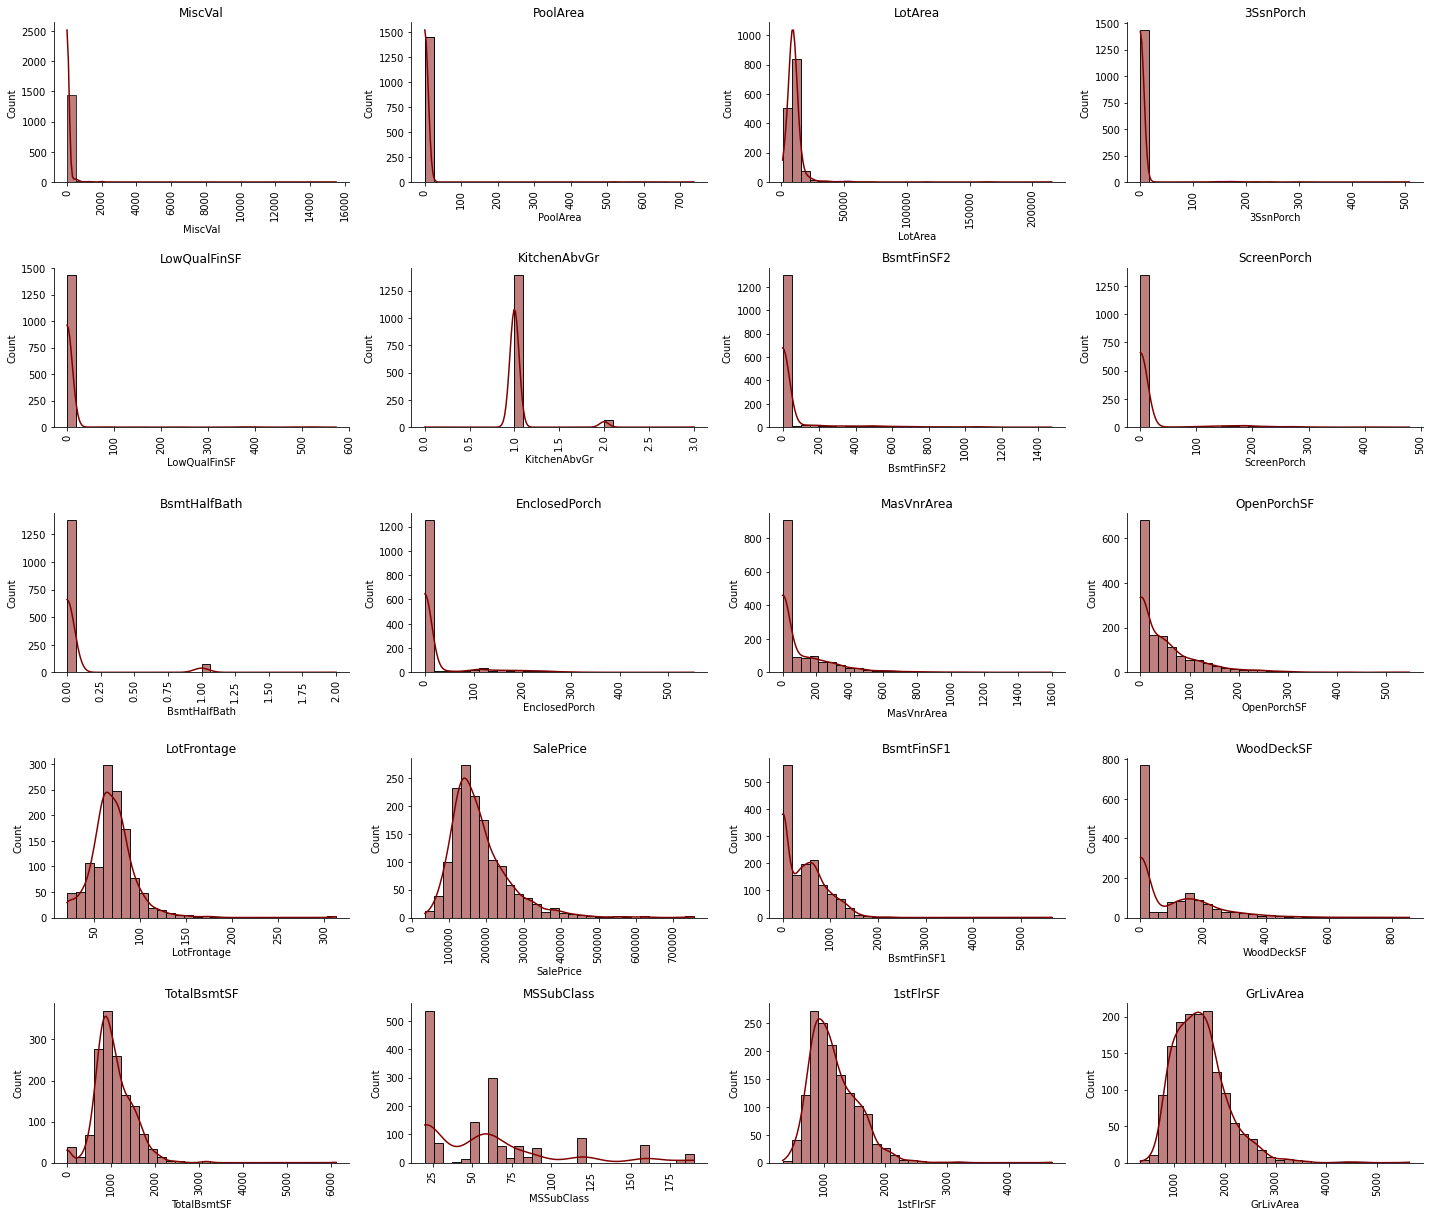

In [103]:
# Univariate statistics
univ_stat_df = sneak_peek(hp_df, 'SalePrice', figsize = (20,17))

OverallQual  GrLivArea  GarageCars  GarageArea  TotalBsmtSF  \
r_pear               0.791      0.709       0.640       0.623        0.614   
p_val(r_pear)        0.000      0.000       0.000       0.000        0.000   
r_spr                0.810      0.731       0.691       0.649        0.603   
p_val(r_spr)         0.000      0.000       0.000       0.000        0.000   

               1stFlrSF  FullBath  TotRmsAbvGrd  YearBuilt  YearRemodAdd  \
r_pear            0.606     0.561         0.534      0.523         0.507   
p_val(r_pear)     0.000     0.000         0.000      0.000         0.000   
r_spr             0.575     0.636         0.533      0.653         0.571   
p_val(r_spr)      0.000     0.000         0.000      0.000         0.000   

               Fireplaces  BsmtFinSF1  WoodDeckSF  2ndFlrSF  OpenPorchSF  \
r_pear              0.467       0.386       0.324     0.319        0.316   
p_val(r_pear)       0.000       0.000       0.000     0.000        0.000   
r_spr               0.519       0.302       0.354     0.294        0.478   
p_val(r_spr)        0.000       0.000       0.000     0.000        0.000   

               HalfBath  LotArea  BsmtFullBath  BsmtUnfSF  BedroomAbvGr  \
r_pear            0.284    0.264         0.227      0.214         0.168   
p_val(r_pear)     0.000    0.000         0.000      0.000         0.000   
r_spr             0.343    0.456         0.225      0.185         0.235   
p_val(r_spr)      0.000    0.000         0.000      0.000         0.000   

               ScreenPorch  PoolArea  MoSold  3SsnPorch  BsmtFinSF2  \
r_pear               0.111     0.092   0.046      0.045      -0.011   
p_val(r_pear)        0.000     0.000   0.076      0.089       0.664   
r_spr                0.100     0.058   0.069      0.065      -0.039   
p_val(r_spr)         0.000     0.026   0.008      0.012       0.138   

               BsmtHalfBath  MiscVal     Id  LowQualFinSF  YrSold  \
r_pear               -0.017   -0.021 -0.022        -0.026  -0.029   
p_val(r_pear)         0.520    0.418  0.403         0.328   0.269   
r_spr                -0.012   -0.063 -0.019        -0.068  -0.030   
p_val(r_spr)          0.642    0.017  0.479         0.010   0.254   

               OverallCond  MSSubClass  EnclosedPorch  KitchenAbvGr  
r_pear              -0.078      -0.084         -0.129        -0.136  
p_val(r_pear)        0.003       0.001          0.000         0.000  
r_spr               -0.129       0.007         -0.218        -0.165  
p_val(r_spr)         0.000       0.784          0.000         0.000

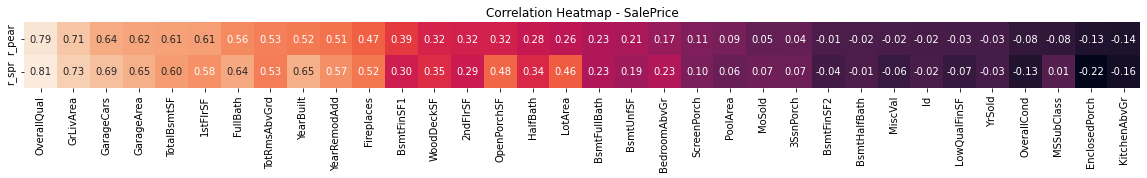

In [104]:
# correlation
corr_df = corr(hp_df, 'SalePrice', list(num_cols_hp.drop('SalePrice')), figsize = (20,17))
corr_df

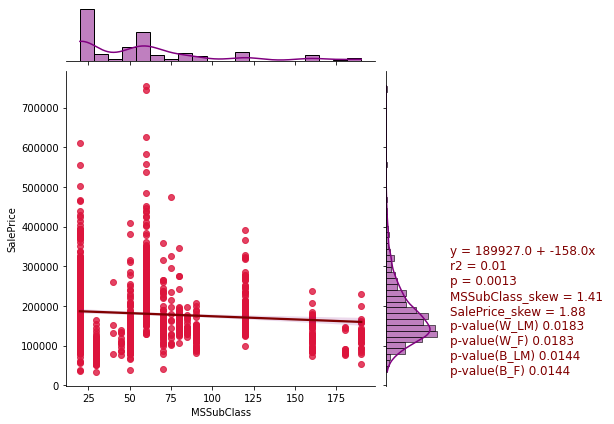

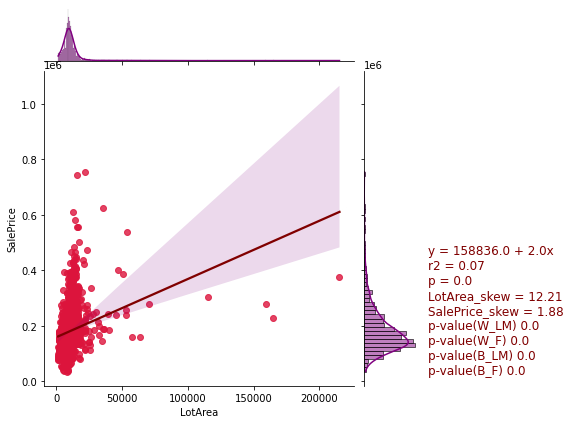

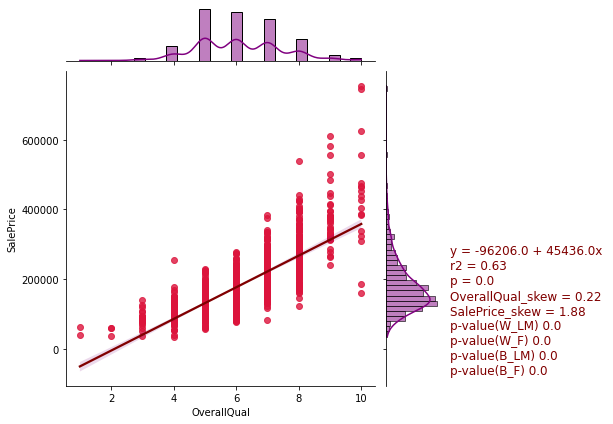

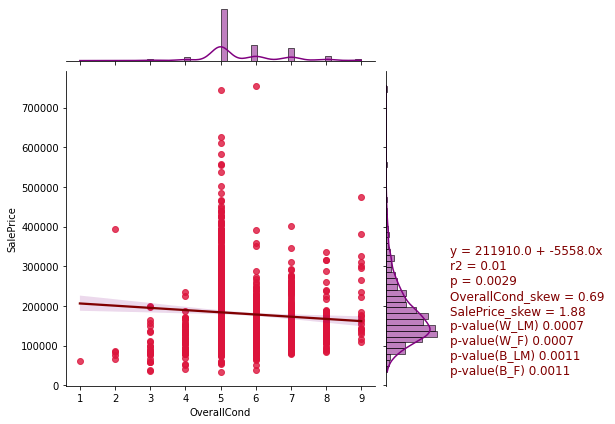

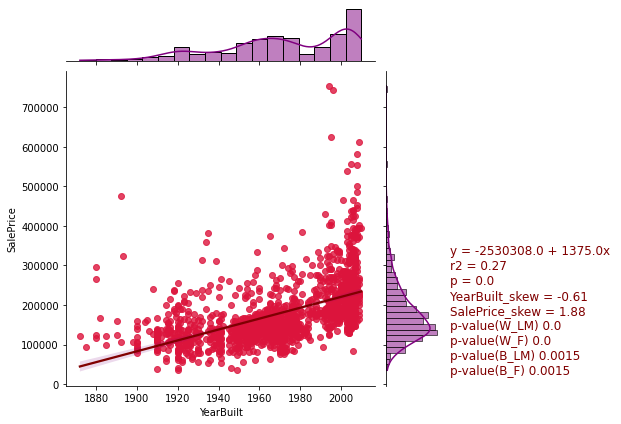

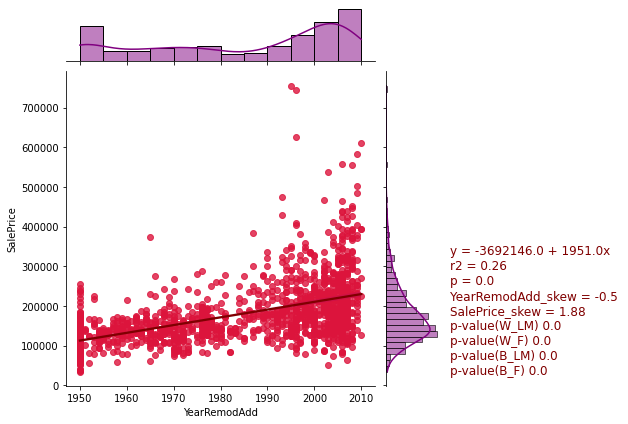

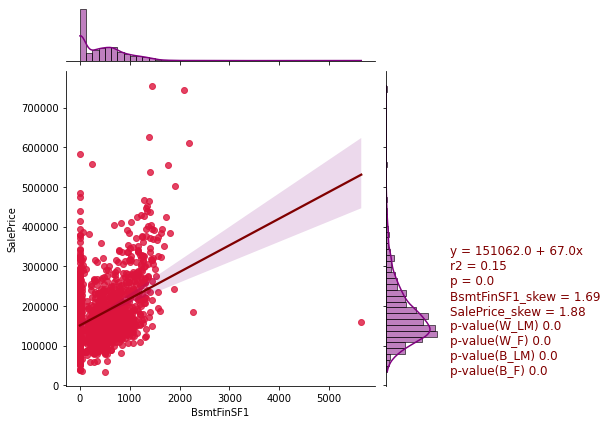

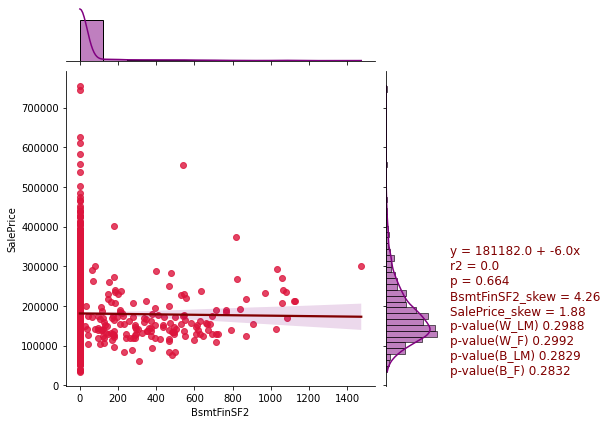

In [179]:
# Bivariate analysis - numeric features

plot_cols = num_cols_hp.drop(['Id', 'SalePrice'])[:10]

resid_df, cols = jplt(hp_df, 'SalePrice', list(plot_cols))

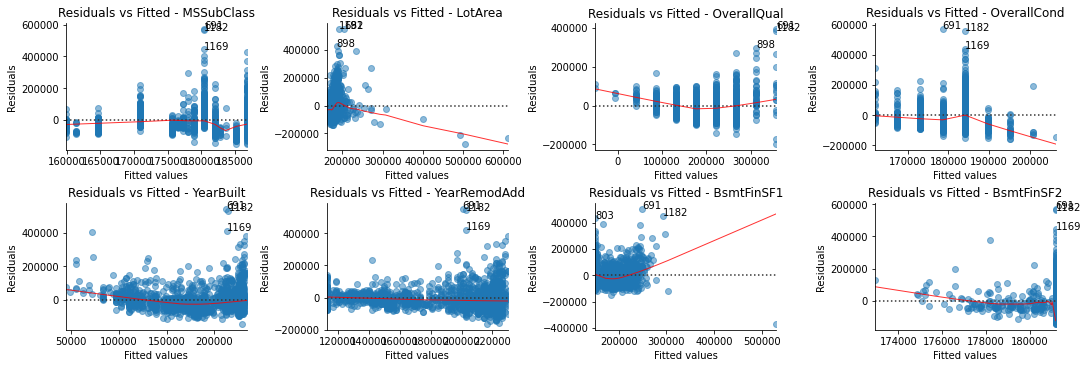

In [181]:
# Homoscedasticity, residuals vs fitted values - single feature fit
resid_plot(resid_df, 'SalePrice', cols, lowess = True, figsize=(15, 5))

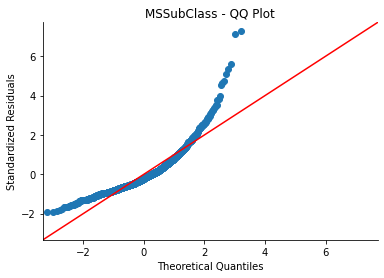

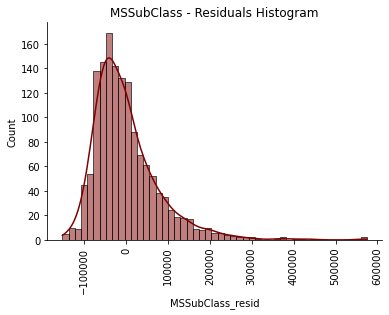

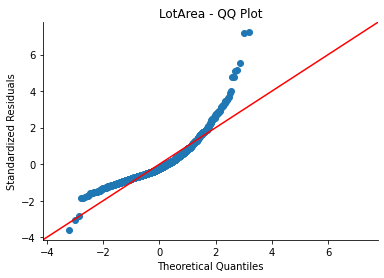

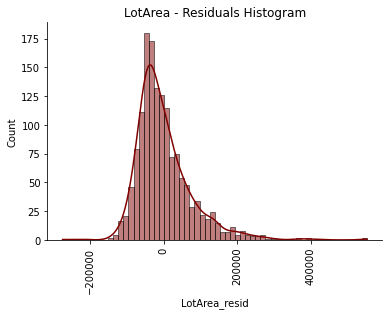

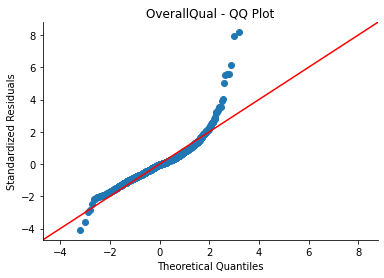

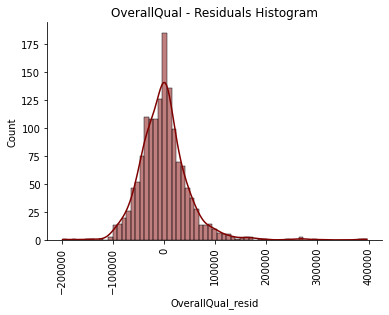

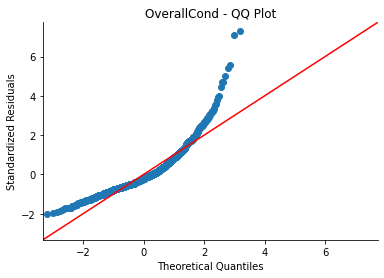

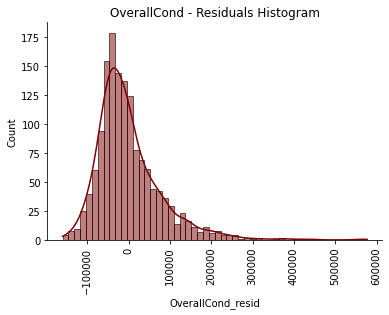

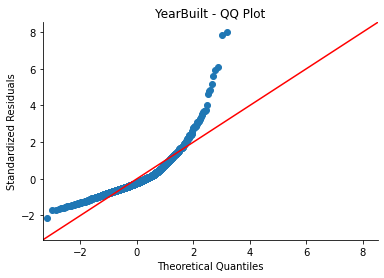

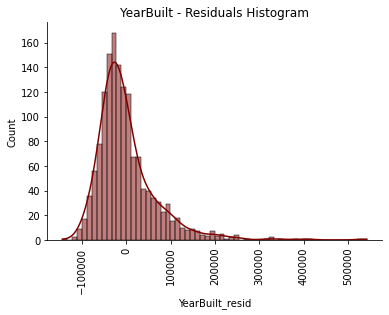

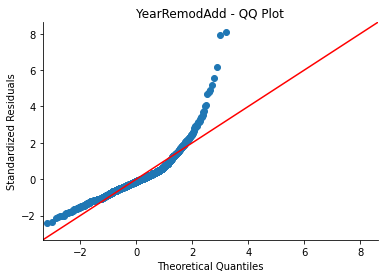

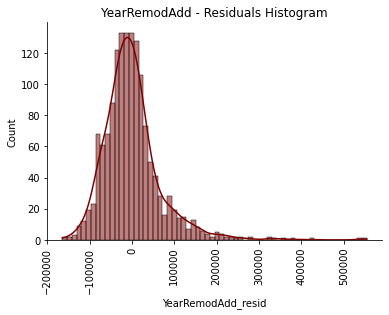

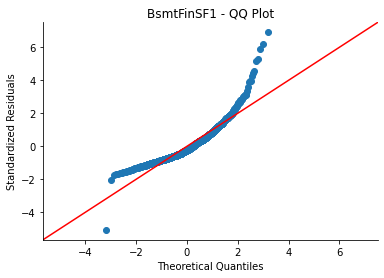

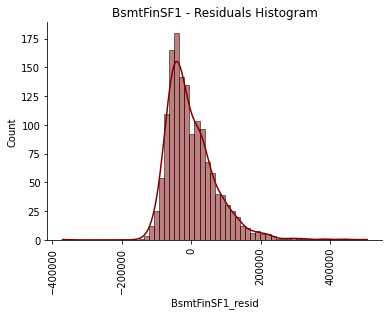

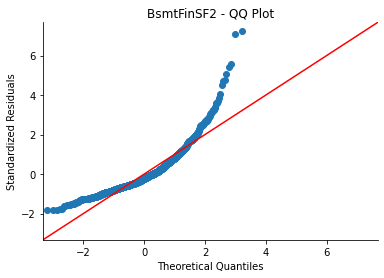

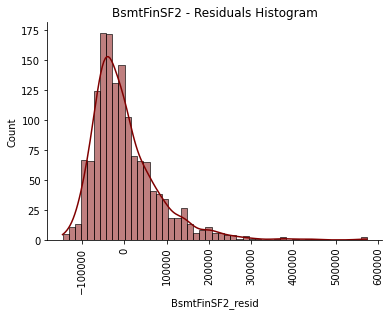

In [169]:
# Residual normality - single feature fit
qq_plt(resid_df, list(cols))

'**Excluded Features**'

'Utilities, Neighborhood, Condition1, Condition2, RoofStyle, RoofMatl, Exterior1st, Exterior2nd, ExterCond, Foundation, BsmtCond, Heating, HeatingQC, Electrical, Functional, GarageQual, GarageCond, PoolQC, MiscFeature, SaleType'

'**One-way ANOVA / Kruskal-Wallis H**'

ExterQual  KitchenQual   CentralAir SaleCondition  \
eq_var(lev)   False (0.0)  False (0.0)  False (0.0)   False (0.0)   
eq_var(bart)  False (0.0)  False (0.0)  False (0.0)   False (0.0)   
f_stat             443.33       407.81        98.31         45.58   
p_val(f)              0.0          0.0          0.0           0.0   
h_stat             683.44       661.48        143.2        168.32   
p_val(h)              0.0          0.0          0.0           0.0   
min_smpl             14.0         39.0         95.0           4.0   
max_smpl            906.0        735.0       1365.0        1198.0   
smpl_std            420.0        347.0        898.0         470.0   
n_grps                4.0          4.0          2.0           6.0   

                 MSZoning      PavedDrive        LotShape   HouseStyle  \
eq_var(lev)   False (0.0)  False (0.0001)  False (0.0041)  False (0.0)   
eq_var(bart)  False (0.0)     False (0.0)     False (0.0)  False (0.0)   
f_stat              43.84           42.02           40.13         19.6   
p_val(f)              0.0             0.0             0.0          0.0   
h_stat             270.07          115.84          150.95       185.43   
p_val(h)              0.0             0.0             0.0          0.0   
min_smpl             10.0            30.0            10.0          8.0   
max_smpl           1151.0          1340.0           925.0        726.0   
smpl_std            487.0           740.0           432.0        264.0   
n_grps                5.0             3.0             4.0          8.0   

                 BldgType     LandContour       LotConfig         Street  \
eq_var(lev)   False (0.0)  False (0.0007)   True (0.3979)  True (0.7539)   
eq_var(bart)  False (0.0)     False (0.0)  False (0.0071)  True (0.5777)   
f_stat              13.01           12.85            7.81           2.46   
p_val(f)              0.0             0.0             0.0          0.117   
h_stat               69.8           35.31           35.72           3.06   
p_val(h)              0.0             0.0             0.0         0.0801   
min_smpl             31.0            36.0             4.0            6.0   
max_smpl           1220.0          1311.0          1052.0         1454.0   
smpl_std            520.0           631.0           436.0         1024.0   
n_grps                5.0             4.0             5.0            2.0   

                  LandSlope  
eq_var(lev)   True (0.0749)  
eq_var(bart)  True (0.1632)  
f_stat                 1.96  
p_val(f)             0.1414  
h_stat                 3.94  
p_val(h)             0.1395  
min_smpl               13.0  
max_smpl             1382.0  
smpl_std              776.0  
n_grps                  3.0

'**t-test / Mann–Whitney U test**'

BldgType     BldgType    BldgType    BldgType     BldgType  \
equl_v_lev  False (0.0)  False (0.0)  True (0.0)  True (0.0)  False (0.0)   
group_one        Duplex       2fmCon      2fmCon      2fmCon       Duplex   
group_two        TwnhsE       TwnhsE       Twnhs      Duplex        Twnhs   
t_stat            -7.05        -6.27       -0.84       -0.69        -0.32   
p_val_t             0.0          0.0      0.4049      0.4957        0.748   
p_val_mw            0.0          0.0      0.4629      0.3636       0.7506   

               BldgType    BldgType     BldgType     BldgType     BldgType  \
equl_v_lev  False (0.0)  True (0.0)  False (0.0)  False (0.0)  False (0.0)   
group_one          1Fam      TwnhsE         1Fam         1Fam         1Fam   
group_two        TwnhsE       Twnhs        Twnhs       2fmCon       Duplex   
t_stat             0.62        5.45         7.45         8.44        11.53   
p_val_t          0.5372         0.0          0.0          0.0          0.0   
p_val_mw         0.5153         0.0          0.0          0.0          0.0   

              ExterQual    ExterQual   ExterQual   ExterQual    ExterQual  \
equl_v_lev  False (0.0)  False (0.0)  True (0.0)  True (0.0)  False (0.0)   
group_one            TA           Gd          TA          Gd           Ex   
group_two            Ex           Ex          Fa          Fa           Fa   
t_stat           -13.76        -8.25        5.25       12.92        14.45   
p_val_t             0.0          0.0      0.0001         0.0          0.0   
p_val_mw            0.0          0.0         0.0         0.0          0.0   

              ExterQual  HouseStyle  HouseStyle  HouseStyle  HouseStyle  \
equl_v_lev  False (0.0)  True (0.0)  True (0.0)  True (0.0)  True (0.0)   
group_one            Gd      1.5Unf      SFoyer      1.5Fin      1.5Unf   
group_two            TA        SLvl        SLvl        SLvl      SFoyer   
t_stat            24.81       -8.12       -4.58       -3.65       -3.49   
p_val_t             0.0         0.0         0.0      0.0003      0.0012   
p_val_mw            0.0         0.0         0.0         0.0      0.0029   

             HouseStyle  HouseStyle   HouseStyle   HouseStyle  HouseStyle  \
equl_v_lev  False (0.0)  True (0.0)  False (0.0)  False (0.0)  True (0.0)   
group_one        1.5Unf      1.5Unf       SFoyer       1.5Fin      2.5Unf   
group_two        2.5Fin      2.5Unf       2.5Fin       2.5Fin      2.5Fin   
t_stat            -2.61       -2.37        -2.02        -1.83       -1.36   
p_val_t          0.0341      0.0366       0.0823       0.1091      0.2034   
p_val_mw         0.0046      0.0093       0.0175       0.0219       0.206   

             HouseStyle  HouseStyle  HouseStyle  HouseStyle  HouseStyle  \
equl_v_lev  False (0.0)  True (0.0)  True (0.0)  True (0.0)  True (0.0)   
group_one          SLvl      SFoyer      1Story      1.5Fin      2Story   
group_two        2.5Fin      2.5Unf      2.5Fin      2.5Unf      2.5Fin   
t_stat            -1.27       -1.12       -1.05       -0.72       -0.24   
p_val_t          0.2447      0.2864       0.328      0.4863      0.8194   
p_val_mw         0.0804      0.7497      0.2466      0.4235         1.0   

            HouseStyle  HouseStyle  HouseStyle   HouseStyle  HouseStyle  \
equl_v_lev  True (0.0)  True (0.0)  True (0.0)  False (0.0)  True (0.0)   
group_one         SLvl      1Story      1.5Fin       1Story      2Story   
group_two       2.5Unf      2.5Unf      SFoyer         SLvl      2.5Unf   
t_stat            0.47        0.96        1.21         1.67        2.67   
p_val_t         0.6467      0.3607      0.2295       0.0968      0.0218   
p_val_mw        0.0479       0.309      0.6369       0.4523      0.0054   

            HouseStyle   HouseStyle  HouseStyle   HouseStyle   HouseStyle  \
equl_v_lev  True (0.0)  False (0.0)  True (0.0)  False (0.0)  False (0.0)   
group_one       1.5Fin       1Story      2Story       2Story       1Story   
group_two       1.5Unf       1.5Fin    

'**Post-hoc (TukeyHSD)**'

BldgType BldgType BldgType BldgType BldgType BldgType ExterQual  \
group1     1Fam     1Fam     1Fam   Duplex   2fmCon    Twnhs        Ex   
group2   Duplex    Twnhs   2fmCon   TwnhsE   TwnhsE   TwnhsE        Fa   
p-adj       0.0   0.0004   0.0006   0.0021   0.0067    0.009       0.0   
reject     True     True     True     True     True     True      True   

       ExterQual ExterQual ExterQual ExterQual ExterQual HouseStyle  \
group1        Ex        Ex        Fa        Gd        Fa     1.5Fin   
group2        Gd        TA        Gd        TA        TA     1Story   
p-adj        0.0       0.0       0.0       0.0    0.0016        0.0   
reject      True      True      True      True      True       True   

       HouseStyle HouseStyle HouseStyle HouseStyle HouseStyle HouseStyle  \
group1     1.5Fin     1.5Unf     1Story     2Story     2Story     1.5Unf   
group2     2Story     2Story     2Story     SFoyer       SLvl     2.5Fin   
p-adj         0.0        0.0        0.0        0.0     0.0005     0.0255   
reject       True       True       True       True       True       True   

       HouseStyle HouseStyle KitchenQual KitchenQual KitchenQual KitchenQual  \
group1     1.5Unf     1Story          Ex          Ex          Ex          Fa   
group2     1Story     SFoyer          Fa          Gd          TA          Gd   
p-adj      0.0299     0.0315         0.0         0.0         0.0         0.0   
reject       True       True        True        True        True        True   

       KitchenQual KitchenQual LandContour LandContour LandContour  \
group1          Gd          Fa         Bnk         HLS         Bnk   
group2          TA          TA         HLS         Lvl         Low   
p-adj          0.0      0.0021         0.0         0.0      0.0013   
reject        True        True        True        True        True   

       LandContour LotConfig LotConfig LotConfig LotShape LotShape LotShape  \
group1         Bnk   CulDSac    Corner   CulDSac      IR1      IR2      IR1   
group2         Lvl    Inside   CulDSac       FR2      Reg      Reg      IR2   
p-adj       0.0015       0.0    0.0001    0.0098      0.0      0.0    0.034   
reject        True      True      True      True     True     True     True   

       MSZoning MSZoning MSZoning MSZoning MSZoning MSZoning PavedDrive  \
group1  C (all)  C (all)       FV       RL       FV       RH          N   
group2       FV       RL       RM       RM       RH       RL          Y   
p-adj       0.0      0.0      0.0      0.0   0.0008   0.0147        0.0   
reject     True     True     True     True     True     True       True   

       PavedDrive SaleCondition SaleCondition SaleCondition SaleCondition  \
group1          P       Abnorml        Alloca        Family        Normal   
group2          Y       Partial       Partial       Partial       Partial   
p-adj      0.0005           0.0           0.0           0.0           0.0   
reject       True          True          True          True          True   

       SaleCondition SaleCondition  
group1       AdjLand       Abnorml  
group2       Partial        Normal  
p-adj         0.0001        0.0026  
reject          True          True

'**Post-hoc (Bonferroni)**'

BldgType BldgType BldgType BldgType BldgType BldgType ExterQual  \
group_one   Duplex   2fmCon   TwnhsE     1Fam     1Fam     1Fam        TA   
group_two   TwnhsE   TwnhsE    Twnhs    Twnhs   2fmCon   Duplex        Ex   
adj-thrsh    0.005    0.005    0.005    0.005    0.005    0.005    0.0083   

          ExterQual ExterQual ExterQual ExterQual ExterQual HouseStyle  \
group_one        Gd        TA        Gd        Ex        Gd     1.5Unf   
group_two        Ex        Fa        Fa        Fa        TA       SLvl   
adj-thrsh    0.0083    0.0083    0.0083    0.0083    0.0083     0.0018   

          HouseStyle HouseStyle HouseStyle HouseStyle HouseStyle HouseStyle  \
group_one     SFoyer     1.5Fin     1.5Unf     1.5Fin     1Story     2Story   
group_two       SLvl       SLvl     SFoyer     1.5Unf     1.5Fin     1Story   
adj-thrsh     0.0018     0.0018     0.0018     0.0018     0.0018     0.0018   

          HouseStyle HouseStyle HouseStyle HouseStyle HouseStyle HouseStyle  \
group_one     2Story     1Story     2Story     1Story     2Story     2Story   
group_two       SLvl     SFoyer     1.5Fin     1.5Unf     SFoyer     1.5Unf   
adj-thrsh     0.0018     0.0018     0.0018     0.0018     0.0018     0.0018   

          KitchenQual KitchenQual KitchenQual KitchenQual KitchenQual  \
group_one          TA          Gd          TA          Ex          Gd   
group_two          Ex          Ex          Fa          Fa          Fa   
adj-thrsh      0.0083      0.0083      0.0083      0.0083      0.0083   

          KitchenQual LandContour LandContour LandContour LandContour  \
group_one          Gd         Bnk         Bnk         Lvl         Lvl   
group_two          TA         HLS         Low         HLS         Bnk   
adj-thrsh      0.0083      0.0083      0.0083      0.0083      0.0083   

          LotConfig LotConfig LotConfig LotShape LotShape MSZoning MSZoning  \
group_one    Inside    Corner       FR2      Reg      Reg       RM  C (all)   
group_two   CulDSac   CulDSac   CulDSac      IR1      IR2       FV       FV   
adj-thrsh     0.005     0.005     0.005   0.0083   0.0083    0.005    0.005   

          MSZoning MSZoning MSZoning MSZoning MSZoning MSZoning MSZoning  \
group_one  C (all)       RL       RM       RL       FV       RL       RL   
group_two       RH       FV  C (all)       RH       RH  C (all)       RM   
adj-thrsh    0.005    0.005    0.005    0.005    0.005    0.005    0.005   

          PavedDrive PavedDrive SaleCondition SaleCondition SaleCondition  \
group_one          Y          Y        Normal       Abnorml        Normal   
group_two          P          N       Partial       Partial       Abnorml   
adj-thrsh     0.0167     0.0167        0.0033        0.0033        0.0033   

          SaleCondition SaleCondition SaleCondition  
group_one       Partial       Partial       Partial  
group_two        Alloca        Family       AdjLand  
adj-thrsh        0.0033        0.0033        0.0033

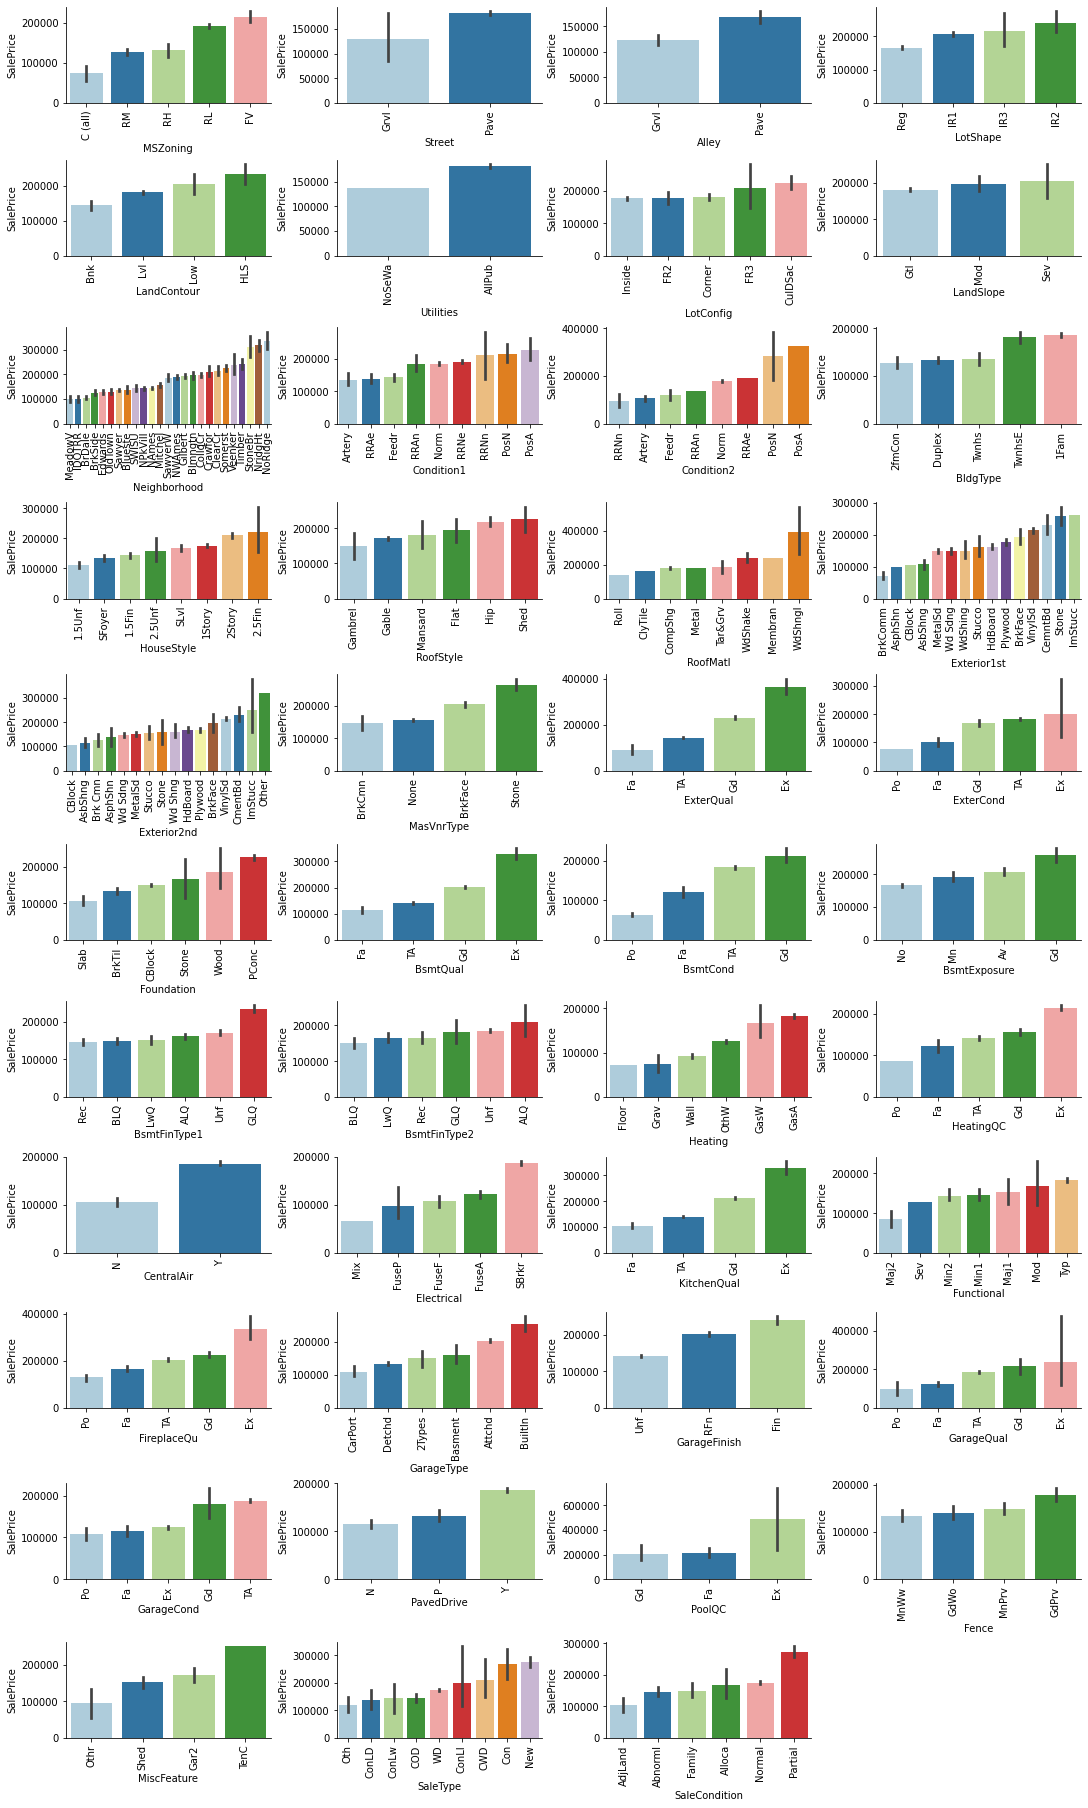

In [108]:
# Bivariate analysis - categorical features
anova_df, t_tst_df, bonfer_df, tuk_df = cat_analysis(hp_df, 'SalePrice', list(cat_cols_hp), figsize = (15,25))

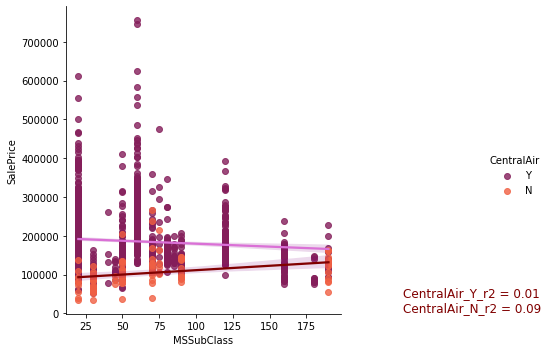

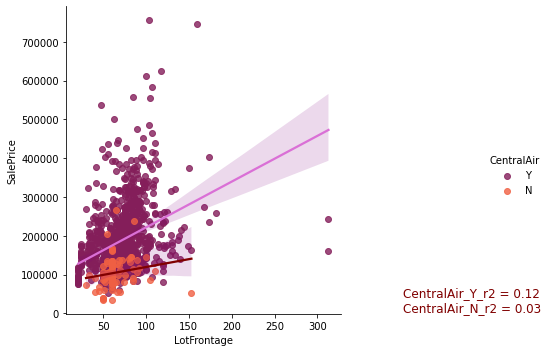

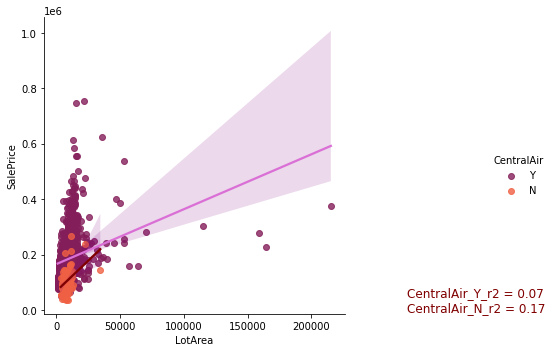

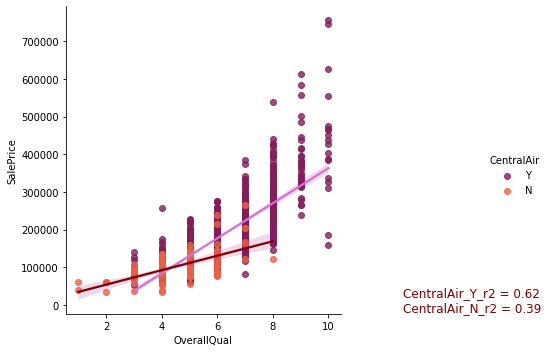

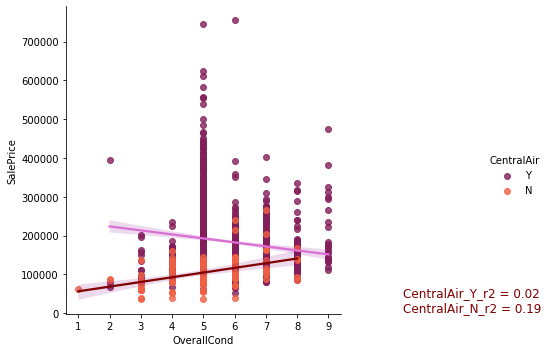

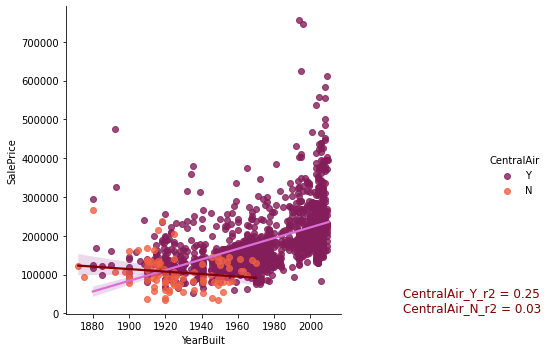

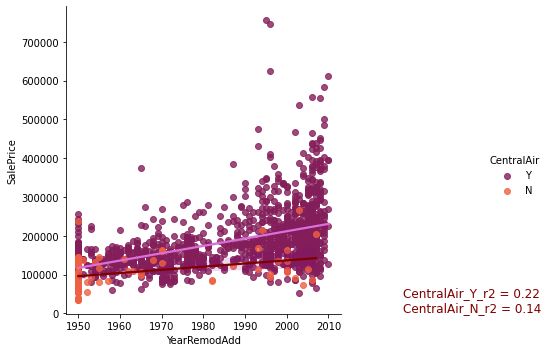

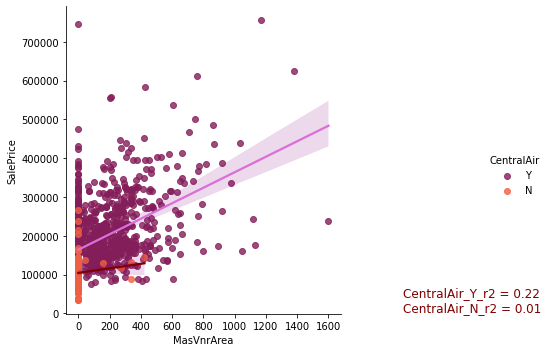

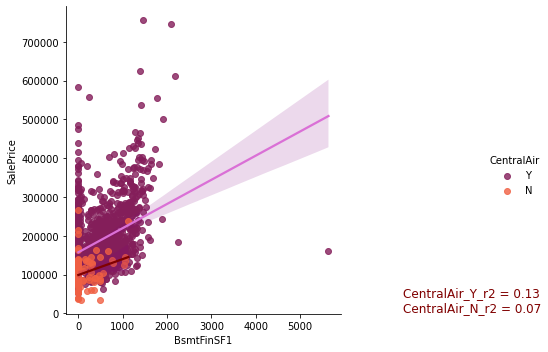

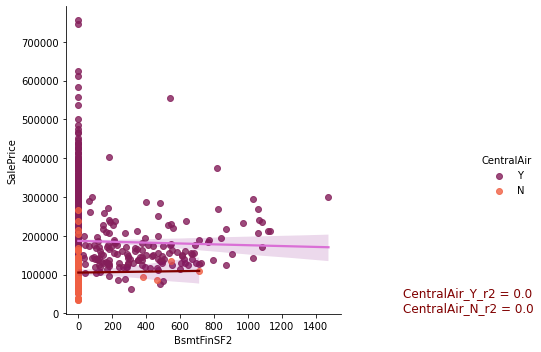

In [171]:
# Multivariate analysis - trend line
multi_reg_vis(hp_df, 'SalePrice', list(num_cols_hp.drop(['Id', 'SalePrice']))[:10], 'CentralAir')

##### I hope you enjoyed the analysis as much I did, till we meet again next year. Happy New Year (published on 31-12-2022).

**<a href="#toc" style='color:#00ffff'>Table of contents</a>**